In [1]:
import numpy as np
import pylab
from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix
from scipy.sparse.linalg import eigsh
import sys
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from sklearn.neighbors import NearestNeighbors
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from scipy.sparse import linalg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

The following code is a modified version, with the original code sourced from https://github.com/theorod93.

In [6]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    if sumP == 0:
        sumP = 1
    if math.isinf(sumP):
        sumP = 1
    if math.isnan(sumP):
        sumP = 1
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [7]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

In [8]:
def tsne_without_pca(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
    t-SNE:
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    (d1,d2) = P.shape
    k = np.argwhere(np.isnan(P))
    (kDim1, kDim2) = k.shape
    for i in range(kDim1):
        d1 = k[i][0]
        d2 = k[i][1]
        P[d1][d2] = 0

    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.                                                                  # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [9]:
def multi_SNE_without_pca(X, no_dims = 2, perplexity = 30.0, max_iter = 1000):
    """
    Multi-SNE: 
        Runs t-SNE on the array(list) X, which includes M datasets
        in the NxD_i for each dataset X_i to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity),
        where X is an MxNxD_i, i from 1 to M NumPy array.
    """
    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    M = len(X)
    print('m',M)
    Xtemp = X[1]
    XsTemp = np.array(Xtemp)
    baselineDim = XsTemp.shape[0]  # number of data
    print('baselineDim:', baselineDim)
    for set in range(M):
        Xtemp = X[set]
        XsTemp = np.array(Xtemp)
        dimToCheck = XsTemp.shape[0]
        if dimToCheck != baselineDim:
            print("Error: Number of rows (samples) must be the same in all data-sets of list X.")
            return -1


    Xpca = X
    a = [(0,0),(0,0), (0,0)]
    b = [(0,0),(0,0)]
    c = [(0,0),(0,0)]
    d = [(0,0),(0,0)]
    e = [(0,0),(0,0)]
    f = [(0,0),(0,0)]
    g = [(0,0),(0,0)]
    if M==2:
        Xi = [a,b]
    elif M ==3:
        Xi = [a,b,c]
    elif M ==4:
        Xi = [a,b,c,d]
    elif M ==5:
        Xi = [a,b,c,d,e]
    elif M ==6:
        Xi = [a,b,c,d,e,f]
    elif M ==7:
        Xi = [a,b,c,d,e,f,g]
    Y = np.random.randn(baselineDim, no_dims)  # number & p & norm(0,1)
    dY =  np.zeros((baselineDim, no_dims))
    iY = np.zeros((baselineDim, no_dims))
    gains = np.zeros((baselineDim, no_dims))
    P = Xi
    # Compute p-values
    for set in range(M):
        XsetTemp = Xpca[set]
        Xset = np.array(XsetTemp)
        (nI, dI) = Xset.shape
        # Compute p-values for each data-set
        Ptemp = x2p(Xset, 1e-5, perplexity)
        (d1,d2) = Ptemp.shape
        k = np.argwhere(np.isnan(Ptemp))
        (kDim1, kDim2) = k.shape
        for i in range(kDim1):
            d1 = k[i][0]
            d2 = k[i][1]
            Ptemp[d1][d2] = 0
        Ptemp = Ptemp + np.transpose(Ptemp)
        Ptemp = Ptemp / np.sum(Ptemp)
        Ptemp = Ptemp * 4.          # early exaggeration
        Ptemp = np.maximum(Ptemp, 1e-12)
        P[set] = Ptemp

    ## Run iterations
    for iter in range(max_iter):
        sum_Y = np.sum(np.square(Y),1) # Sum of columns squared element-wise
        num = -2. * np.dot(Y, Y.T) # matrix multiplication
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(baselineDim), range(baselineDim)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        # For each data-set
        for set in range(M):
            # Compute pairwise affinities
            # Compute gradient
            Ptemp = P[set]
            Pset = np.array(Ptemp)
            PQ = Pset - Q
            if set == 0:
                for i in range(baselineDim):
                    dY[i, :] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)
            else:
                for i in range(baselineDim):
                    dY[i, :] = dY[i,:] + np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
        (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y,0), (baselineDim,1))

        # Stop lying about P-Values
        for set in range(M):
            PsetTemp = P[set]
            Pset = np.array(PsetTemp)
            if (iter + 1) % 10 ==0:
                C = np.sum(Pset * np.log(Pset / Q))
                print("Iteration %d: error is %f" % (iter + 1, C))
            if iter == 100:
                Pset = Pset / 4.
                P[set] = Pset

    # Return solution
    return Y

All the code that follows was written by myself.

In [10]:
def pca_function(X,k):
    n, d = X.shape
    
    if d > k:
        
        X_normalized = X - np.mean(X, axis=0)

        pca = PCA(n_components= k, svd_solver='full')

        X_pca = pca.fit_transform(X_normalized)

        return X_pca
    
    else:
        return X

In [11]:
def multiPCA(X=np.array([[]]), no_dims=50):
    """
        Runs PCA on M datasets, each being a NxD_i array in order to
        reduce their dimensionality to no_dims dimensions. PCA is applied
        on each dataset separately
    """
    print(no_dims)
    M = len(X)
    Yout = X
    for view in range(M):
        print(104)
        Y = pca_function(X[view], no_dims)
        Yout[view] = Y
        
    dlist = [Yout[i].shape[1] for i in range(M)]
    print(dlist)
    
    
    if len(set(dlist)) == 1:
        
        a, b = Yout[0].shape
        Z = np.zeros([M, a, b])
        for view in range(M):
            Z[view] = Yout[view]
    
        print(Z.shape)

        return Z
    
    else:
        return Yout

In [222]:
def separate_multi_sne(x_train, y_train, x_test, perplexity = 5, infor = False, update = False):
    '''
    x_test: M*N*D
    
    x_train:M*N*D
    
    '''
    
    if update:
        x_p = x_train.copy()
        y_p = y_train.copy()
    
    dY_list = []
    dY_init_list = []
    Yout_test = []
    eps = 0.1
    for i in range(len(x_test[0])):
        print(f'computing for {i}-th data point')
        X = [k[i]for k in x_test]
        Plist = []
        for j in range(len(x_test)):
            beta_max = np.inf
            beta_min = - np.inf
            X_i = X[j].copy()
            D_i = np.sum((x_train[j].copy()-X_i)**2,axis = 1)
            beta = 1
            while sum(np.exp(- D_i * beta))<1:
                beta = beta/2
    
            P = np.exp(- D_i * beta)
            P = P/sum(P)
            P = np.maximum(P, 1e-12)
            perp = 2**(-sum(P*(np.log2(P))))
            if perp > perplexity:
                itera = 0
                while perp> perplexity:
                    
                    beta = beta * 2
                    P = np.exp(- D_i * beta)
                    P = P/sum(P)
                    P = np.maximum(P, 1e-12)
                    perp = 2**(-sum(P*(np.log2(P))))
                beta_max = beta
                beta_min = beta/2
            else:
                itera = 0
                while perp< perplexity:
                    beta = beta / 2
                    P = np.exp(- D_i * beta)
                    P = P/sum(P)
                    P = np.maximum(P, 1e-12)
                    perp = 2**(-sum(P*(np.log2(P))))
                beta_max = beta*2
                beta_min = beta
                
            itera = 0
            
            perp = 0

            while abs(perp - perplexity) > eps and beta_min != beta_max and itera < 500:
                itera += 1
                beta = (beta_max + beta_min)/2
                P = np.exp(- D_i * beta)
                
                if sum(P) == 0:
                    break
                P = P/sum(P)
                P = np.maximum(P, 1e-12)
                perp = 2**(-sum(P*(np.log2(P))))
                if perp > perplexity:
                    beta_min = beta
                elif perp < perplexity:
                    beta_max = beta
                else:
                    break
            beta = (beta_max + beta_min)/2
            P = np.exp(- D_i * beta)
            
            if sum(P) != 0:
                P = P/sum(P)
            P = np.maximum(P, 1e-12)
            P = P/sum(P)
            perp = 2**(-sum(P*(np.log2(P))))
            Plist.append(P)

        Yout_init = np.zeros(len(np.mean(y_train, axis = 0)))
        initial_momentum = 0.5
        final_momentum = 0.8
        eta = 1
        iY = 0
        scale = max(np.sum(y_train**2, axis = 1)**0.5)
        
        for m in range(500):
            D = y_train - Yout_init
            Q = 1/(1.+np.sum(D**2,axis = 1))
            Q = Q/sum(Q)
            
            dY=0

            for l in range(len(Plist)):
                dY += np.sum(4*(D.T*(Plist[l]-Q).T)/(1.+np.sum(D**2,axis = 1)).T, axis = 1) 
                
            if m ==0:
                dY_init_list.append(dY)

            k = Yout_init.copy()
            
            
            dY_std = dY/(sum(dY**2)**0.5)
            
            
            loss = np.sum([sum(r*np.log(r/Q)) for r in Plist])
            
            if m % 10 == 0 and infor:
                print(loss)
            
            mom = 0.1
            if m < 30:
                w = 5 * dY_std * scale/38.6 + 0.5 * iY
            
            elif m < 130 and m >= 30:
                w = 2 * dY_std * scale/38.6 + 0.5 * iY
                
            else: 
                w = 0.2 * dY_std * scale/38.6 + 0.5 * iY

            Yout_init = Yout_init + w

            iY = Yout_init - k 
            
            if m == 499:
                dY_list.append(dY)

        Yout_test.append(Yout_init)
        
        if update:
            for k in range(len(x_train)):
                x_train[k] = np.vstack([x_train[k].copy(), X[k]])
            y_train =  np.vstack([y_train.copy(), Yout_init])
            
            print(len(x_train[0]))
            print(len(y_train))
            print(len(x_p[0]))
            print(len(y_p))
    if update:
        x_train = x_p
        y_train = y_p
        
    return Yout_test, dY_list, dY_init_list

In [13]:
def pca_var(data,vari, eigen = False):

    multi_cancer_PCA = []
    PCA_component = []
    mu_list = []
    var_list = []
    for i in range(len(data)):
        X = data[i].copy()
        mu = np.mean(X, axis=0)
        var = np.mean(X**2, axis=0) - mu**2
        mu_list.append(mu)
        var_list.append(var)
        X_scaled = (X - mu)/((var)**0.5)
    
        pca = PCA(n_components= vari, svd_solver='full')
        pca.fit(X_scaled)
    
        X_pca = pca.transform(X_scaled)
        multi_cancer_PCA.append(X_pca)
    
        eigenvectors = pca.components_
        PCA_component.append(eigenvectors)
        
    if eigen == True:
        return multi_cancer_PCA, PCA_component, mu_list, var_list
        
    else:
    
        return multi_cancer_PCA

### Data pre-pocessing

Cancer data

In [2]:
breast_gene = pd.read_csv('breast_gene.csv')
breast_methy= pd.read_csv('breast_methy.csv')
breast_mirna = pd.read_csv('breast_mirna.csv')
a = breast_gene.columns.to_numpy()
b = breast_methy.columns.to_numpy()
c = breast_mirna.columns.to_numpy()
k = []
for i in range(len(a[1:-1])):
    k.append(a[1:-1][i][:12] == b[1:-1][i][:12])
    k.append(c[1:-1][i][:12] == b[1:-1][i][:12])

print('all code of breast cancer patient are in same order:',all(k))

kidney_gene = pd.read_csv('kidney_gene.csv')
kidney_methy= pd.read_csv('kidney_methy.csv')
kidney_mirna = pd.read_csv('kidney_mirna.csv')
a = kidney_gene.columns.to_numpy()
b = kidney_methy.columns.to_numpy()
c = kidney_mirna.columns.to_numpy()
k = []
for i in range(len(a[2:-1])):
    k.append(a[2:-1][i][:12] == b[2:-1][i][:12])
    k.append(c[1:-1][i][:12] == b[2:-1][i][:12])

print('all code of kidney cancer patient is in same order:',all(k))

lung_gene = pd.read_csv('lung_gene.csv')
lung_methy= pd.read_csv('lung_methy.csv')
lung_mirna = pd.read_csv('lung_mirna.csv')
a = lung_gene.columns.to_numpy()
b = lung_methy.columns.to_numpy()
c = lung_mirna.columns.to_numpy()
k = []
for i in range(len(a[1:-1])):
    k.append(a[1:-1][i][:12] == b[1:-1][i][:12])
    k.append(c[1:-1][i][:12] == b[1:-1][i][:12])

print('all code of lung cancer patient are in same order:',all(k))

breast_gene = pd.read_csv('breast_gene.csv').to_numpy().T
kidney_gene = pd.read_csv('kidney_gene.csv').to_numpy().T[1:,:]
lung_gene = pd.read_csv('lung_gene.csv').to_numpy().T

bgn = breast_gene[0].copy()
kgn = kidney_gene[0].copy()
lgn = lung_gene[0].copy()

gene_index_list = []

for i, j in enumerate(bgn,start = 0):
    index_k = np.where(kgn == j)
    index_l = np.where(lgn == j)
    if len(index_k[0]) & len(index_l[0]):
        gene_index_list.append([i, index_k[0][0], index_l[0][0]])

all_gene = []

for index, i in enumerate(gene_index_list, start = 0):
    b = breast_gene[:,i[0]].copy().reshape(-1,1)[1:-1,:]
    k = kidney_gene[:,i[1]].copy().reshape(-1,1)[1:-1,:]
    l = lung_gene[:,i[2]].copy().reshape(-1,1)[1:-1,:]
    total  = np.vstack((b, k, l))
    all_gene.append(total)
    

all_gene_total = np.hstack(all_gene)

n_gene = all_gene_total.astype(float)

breast_methy = pd.read_csv('breast_methy.csv').to_numpy().T
kidney_methy = pd.read_csv('kidney_methy.csv').to_numpy().T[1:,:]
lung_methy = pd.read_csv('lung_methy.csv').to_numpy().T

bmn = breast_methy[0].copy()
kmn = kidney_methy[0].copy()
lmn = lung_methy[0].copy()

methy_index_list = []

for i, j in enumerate(bmn,start = 0):
    index_k = np.where(kmn == j)
    index_l = np.where(lmn == j)
    if len(index_k[0]) & len(index_l[0]):
        methy_index_list.append([i, index_k[0][0], index_l[0][0]])
        
all_methy = []

for index, i in enumerate(methy_index_list, start = 0):
    b = breast_methy[:,i[0]].copy().reshape(-1,1)[1:-1,:]
    k = kidney_methy[:,i[1]].copy().reshape(-1,1)[1:-1,:]
    l = lung_methy[:,i[2]].copy().reshape(-1,1)[1:-1,:]
    total  = np.vstack((b, k, l))
    all_methy.append(total)

all_methy_total = np.hstack(all_methy)

n_methy = all_methy_total.astype(float)

breast_mirna = pd.read_csv('breast_mirna.csv').to_numpy().T
kidney_mirna = pd.read_csv('kidney_mirna.csv').to_numpy().T
lung_mirna = pd.read_csv('lung_mirna.csv').to_numpy().T

brn = breast_mirna[0].copy()
krn = kidney_mirna[0].copy()
lrn = lung_mirna[0].copy()

mirna_index_list = []

for i, j in enumerate(brn,start = 0):
    index_k = np.where(krn == j)
    index_l = np.where(lrn == j)
    if len(index_k[0]) & len(index_l[0]):
        mirna_index_list.append([i, index_k[0][0], index_l[0][0]])
        
all_mirna = []

for index, i in enumerate(mirna_index_list, start = 0):
    b = breast_mirna[:,i[0]].copy().reshape(-1,1)[1:-1,:]
    k = kidney_mirna[:,i[1]].copy().reshape(-1,1)[1:-1,:]
    l = lung_mirna[:,i[2]].copy().reshape(-1,1)[1:-1,:]
    total  = np.vstack((b, k, l))
    all_mirna.append(total)


all_mirna_total = np.hstack(all_mirna)

n_mirna = all_mirna_total.astype(float)

multi_cancer = [n_gene.copy(), n_methy.copy(), n_mirna.copy()]

Y_cancer = [2 for i in range(105)] + [1 for i in range(122)]+ [0 for i in range(106)]
Y_cancer = np.array(Y_cancer)

all code of breast cancer patient are in same order: True
all code of kidney cancer patient is in same order: True
all code of lung cancer patient are in same order: True


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
for i in range(3):
    print(multi_cancer[i].shape)

(333, 10127)
(333, 22503)
(333, 302)


In [14]:
col = ['red','blue','green','cyan', 'm','y','k','navy','gold','salmon']
col_cancer = ['red', 'blue', 'green']
label_cancer = ['lung','kidney','breast']
Y_cancer_col = [col_cancer[i] for i in Y_cancer]
Y_cancer_label = [label_cancer[i] for i in Y_cancer]

Hand writting digits

In [15]:
fac = pd.read_csv('mefeat-fac.csv').to_numpy()
fou = pd.read_csv('mefeat-fou.csv').to_numpy()
kar = pd.read_csv('mefeat-kar.csv').to_numpy()
mor = pd.read_csv('mefeat-mor.csv').to_numpy()
pix = pd.read_csv('mefeat-pix.csv').to_numpy()
zer = pd.read_csv('mefeat-zer.csv').to_numpy()
multi_dig = [fac, fou, kar, mor, pix, zer]
Y_dig = [i for i in range(10)]
Y_dig = [Y_dig[i//200] for i in range(2000)]

compare t-SNE and multi-SNE using cancer dataset.

In [33]:
multi_cancer_pca = pca_var(multi_cancer, 35)

In [34]:
Yout_train_0 = tsne_without_pca(multi_cancer_pca[0],  no_dims = 2,  perplexity = 35.0)

Computing pairwise distances...
Computing P-values for point 0 of 333...
Mean value of sigma: 30.063220
Iteration 10: error is 13.886189
Iteration 20: error is 13.857890
Iteration 30: error is 13.901617
Iteration 40: error is 14.035530
Iteration 50: error is 14.132837
Iteration 60: error is 14.533819
Iteration 70: error is 14.452170
Iteration 80: error is 14.559319
Iteration 90: error is 14.805490
Iteration 100: error is 15.134485
Iteration 110: error is 1.610873
Iteration 120: error is 1.208423
Iteration 130: error is 1.066854
Iteration 140: error is 0.970109
Iteration 150: error is 0.936048
Iteration 160: error is 0.916326
Iteration 170: error is 0.904050
Iteration 180: error is 0.897739
Iteration 190: error is 0.894626
Iteration 200: error is 0.891134
Iteration 210: error is 0.885838
Iteration 220: error is 0.881509
Iteration 230: error is 0.878598
Iteration 240: error is 0.875505
Iteration 250: error is 0.872364
Iteration 260: error is 0.870254
Iteration 270: error is 0.869139
Iter

In [35]:
Yout_train_1 = tsne_without_pca(multi_cancer_pca[1],  no_dims = 2,  perplexity = 35.0)

Computing pairwise distances...
Computing P-values for point 0 of 333...
Mean value of sigma: 44.103206
Iteration 10: error is 13.150910
Iteration 20: error is 12.646147
Iteration 30: error is 12.823664
Iteration 40: error is 12.894167
Iteration 50: error is 12.863759
Iteration 60: error is 12.926061
Iteration 70: error is 12.852762
Iteration 80: error is 12.952439
Iteration 90: error is 13.043227
Iteration 100: error is 12.848273
Iteration 110: error is 1.145322
Iteration 120: error is 0.862500
Iteration 130: error is 0.791341
Iteration 140: error is 0.737818
Iteration 150: error is 0.720125
Iteration 160: error is 0.687587
Iteration 170: error is 0.679500
Iteration 180: error is 0.673969
Iteration 190: error is 0.670876
Iteration 200: error is 0.668153
Iteration 210: error is 0.666466
Iteration 220: error is 0.665203
Iteration 230: error is 0.664725
Iteration 240: error is 0.664339
Iteration 250: error is 0.663832
Iteration 260: error is 0.663461
Iteration 270: error is 0.663079
Iter

In [36]:
Yout_train_2 = tsne_without_pca(multi_cancer_pca[2],  no_dims = 2,  perplexity = 35.0)

Computing pairwise distances...
Computing P-values for point 0 of 333...
Mean value of sigma: 4.889915
Iteration 10: error is 13.435514
Iteration 20: error is 13.226304
Iteration 30: error is 13.411436
Iteration 40: error is 13.977490
Iteration 50: error is 13.910437
Iteration 60: error is 14.501758
Iteration 70: error is 14.502925
Iteration 80: error is 14.704734
Iteration 90: error is 14.550138
Iteration 100: error is 14.737991
Iteration 110: error is 1.968059
Iteration 120: error is 1.495331
Iteration 130: error is 1.290573
Iteration 140: error is 1.147838
Iteration 150: error is 1.072902
Iteration 160: error is 1.051076
Iteration 170: error is 1.039797
Iteration 180: error is 1.033095
Iteration 190: error is 1.029683
Iteration 200: error is 1.026646
Iteration 210: error is 1.024825
Iteration 220: error is 1.023160
Iteration 230: error is 1.021525
Iteration 240: error is 1.020202
Iteration 250: error is 1.017765
Iteration 260: error is 1.016021
Iteration 270: error is 1.015442
Itera

In [37]:
Yout_train_multi = multi_SNE_without_pca(multi_cancer_pca,  no_dims = 2,  perplexity = 35.0)

m 3
baselineDim: 333
Computing pairwise distances...
Computing P-values for point 0 of 333...
Mean value of sigma: 30.063220
Computing pairwise distances...
Computing P-values for point 0 of 333...
Mean value of sigma: 44.103206
Computing pairwise distances...
Computing P-values for point 0 of 333...
Mean value of sigma: 4.889915
Iteration 10: error is 14.444571
Iteration 10: error is 14.637160
Iteration 10: error is 14.031484
Iteration 20: error is 14.774886
Iteration 20: error is 14.651643
Iteration 20: error is 14.327439
Iteration 30: error is 16.586977
Iteration 30: error is 16.272459
Iteration 30: error is 16.338548
Iteration 40: error is 17.791773
Iteration 40: error is 17.052056
Iteration 40: error is 17.429361
Iteration 50: error is 17.624514
Iteration 50: error is 17.125747
Iteration 50: error is 17.201278
Iteration 60: error is 17.118794
Iteration 60: error is 16.744515
Iteration 60: error is 16.916611
Iteration 70: error is 17.143379
Iteration 70: error is 16.637342
Iteratio

Iteration 810: error is 1.369586
Iteration 810: error is 1.327791
Iteration 810: error is 1.608139
Iteration 820: error is 1.369586
Iteration 820: error is 1.327791
Iteration 820: error is 1.608139
Iteration 830: error is 1.369586
Iteration 830: error is 1.327791
Iteration 830: error is 1.608139
Iteration 840: error is 1.369586
Iteration 840: error is 1.327791
Iteration 840: error is 1.608139
Iteration 850: error is 1.369586
Iteration 850: error is 1.327791
Iteration 850: error is 1.608139
Iteration 860: error is 1.369586
Iteration 860: error is 1.327791
Iteration 860: error is 1.608139
Iteration 870: error is 1.369586
Iteration 870: error is 1.327791
Iteration 870: error is 1.608139
Iteration 880: error is 1.369586
Iteration 880: error is 1.327791
Iteration 880: error is 1.608139
Iteration 890: error is 1.369586
Iteration 890: error is 1.327791
Iteration 890: error is 1.608139
Iteration 900: error is 1.369586
Iteration 900: error is 1.327791
Iteration 900: error is 1.608139
Iteration 

In [60]:
data = [(Yout_train_0[:,0], Yout_train_0[:,1]), (Yout_train_1[:,0], Yout_train_1[:,1]), (Yout_train_2[:,0], Yout_train_2[:,1]), (Yout_train_multi[:,0], Yout_train_multi[:,1])]
np.save('data_1.npy', data)

In [16]:
result = np.load('result.npy')

In [21]:
result.shape

(3, 20, 333, 2)

In [23]:
11//5

2

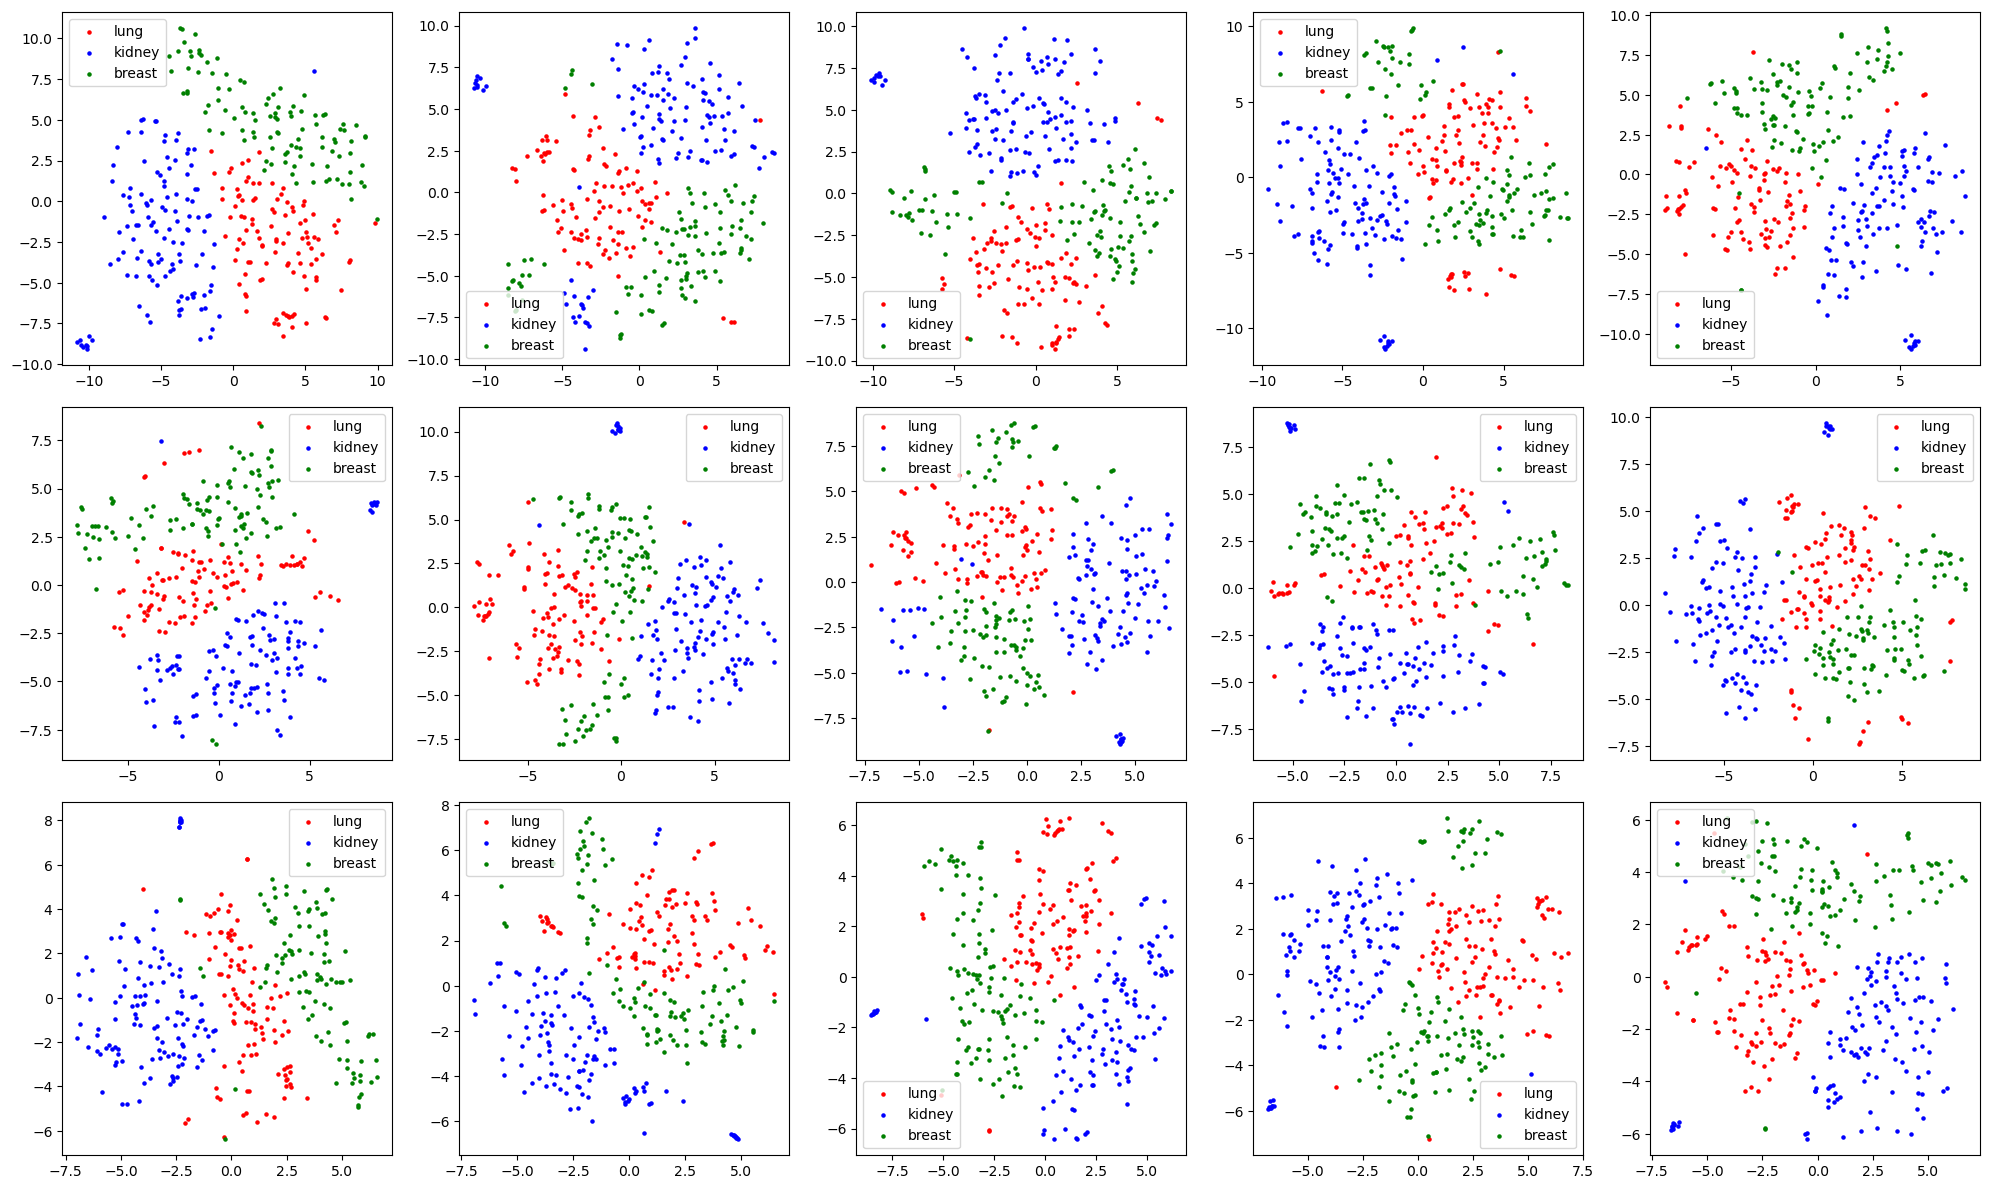

In [34]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

for i, ax in enumerate(axs.flat):
    x, y = result[i//5][i%5][:,0],result[i//5][i%5][:,1]
    for color, label in zip(col_cancer, label_cancer):
        indices = np.where(np.array(Y_cancer_col) == color)
        ax.scatter(x[indices], y[indices], color=color, label=label, s =5)
    ax.legend()
    
plt.tight_layout()  # Adjust the spacing between plots
plt.show()

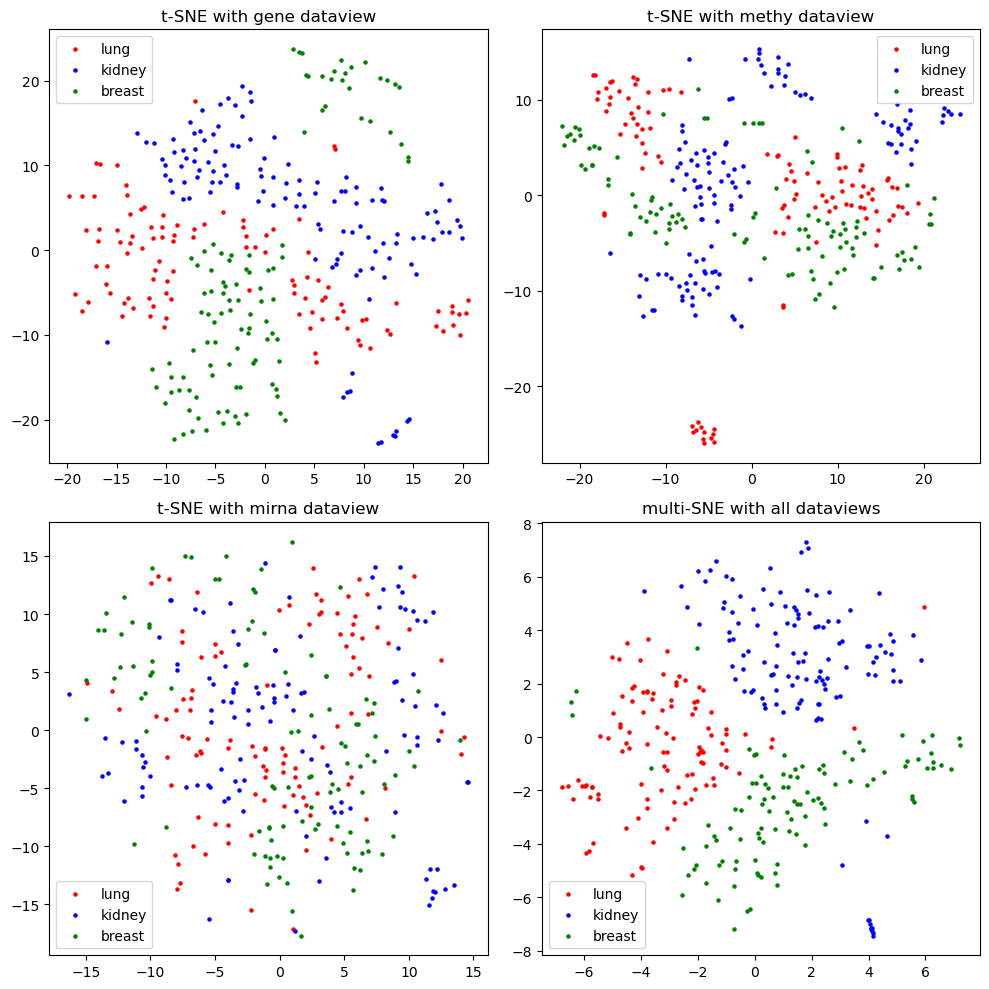

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# List of all x and y datasets
data = np.load('data_1.npy')

# Loop through the data and create scatter plots
for i, ax in enumerate(axs.flat):
    x, y = data[i]
    for color, label in zip(col_cancer, label_cancer):
        indices = np.where(np.array(Y_cancer_col) == color)
        ax.scatter(x[indices], y[indices], color=color, label=label, s =5)
    ax.legend()

axs[0, 0].set_title('t-SNE with gene dataview')
axs[0, 1].set_title('t-SNE with methy dataview')
axs[1, 0].set_title('t-SNE with mirna dataview')
axs[1, 1].set_title('multi-SNE with all dataviews')
# Display the figure
plt.tight_layout()  # Adjust the spacing between plots
plt.show()

In [36]:
multi_digit_pca = pca_var(multi_dig, 0.8)

In [37]:
Yout_dig = multi_SNE_without_pca(multi_digit_pca,  no_dims = 2,  perplexity = 35.0)

m 6
baselineDim: 2000
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 3.531015
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 2.634254
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 2.565436
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 0.104981
Computing pairwise distanc

Iteration 350: error is 1.271712
Iteration 350: error is 2.328288
Iteration 360: error is 1.401949
Iteration 360: error is 2.588447
Iteration 360: error is 1.633110
Iteration 360: error is 2.996658
Iteration 360: error is 1.270911
Iteration 360: error is 2.328571
Iteration 370: error is 1.401364
Iteration 370: error is 2.588961
Iteration 370: error is 1.632563
Iteration 370: error is 2.997422
Iteration 370: error is 1.270172
Iteration 370: error is 2.328859
Iteration 380: error is 1.400897
Iteration 380: error is 2.589469
Iteration 380: error is 1.632058
Iteration 380: error is 2.998127
Iteration 380: error is 1.269432
Iteration 380: error is 2.329102
Iteration 390: error is 1.400486
Iteration 390: error is 2.589861
Iteration 390: error is 1.631630
Iteration 390: error is 2.998739
Iteration 390: error is 1.268865
Iteration 390: error is 2.329292
Iteration 400: error is 1.400070
Iteration 400: error is 2.590204
Iteration 400: error is 1.631251
Iteration 400: error is 2.999295
Iteration 

Iteration 770: error is 3.004885
Iteration 770: error is 1.263105
Iteration 770: error is 2.332194
Iteration 780: error is 1.396012
Iteration 780: error is 2.593742
Iteration 780: error is 1.627751
Iteration 780: error is 3.004909
Iteration 780: error is 1.263086
Iteration 780: error is 2.332206
Iteration 790: error is 1.395995
Iteration 790: error is 2.593755
Iteration 790: error is 1.627740
Iteration 790: error is 3.004926
Iteration 790: error is 1.263068
Iteration 790: error is 2.332222
Iteration 800: error is 1.395981
Iteration 800: error is 2.593768
Iteration 800: error is 1.627729
Iteration 800: error is 3.004942
Iteration 800: error is 1.263050
Iteration 800: error is 2.332234
Iteration 810: error is 1.395967
Iteration 810: error is 2.593779
Iteration 810: error is 1.627719
Iteration 810: error is 3.004960
Iteration 810: error is 1.263032
Iteration 810: error is 2.332247
Iteration 820: error is 1.395955
Iteration 820: error is 2.593790
Iteration 820: error is 1.627709
Iteration 

In [44]:
col = ['red','blue','green','cyan', 'm','y','k','navy','gold','salmon']
y_col = [col[i]for i in Y_dig]
labels = ['0','1','2','3','4','5','6','7','8','9']

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\3862371552.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx = np.where(Y_dig == i)


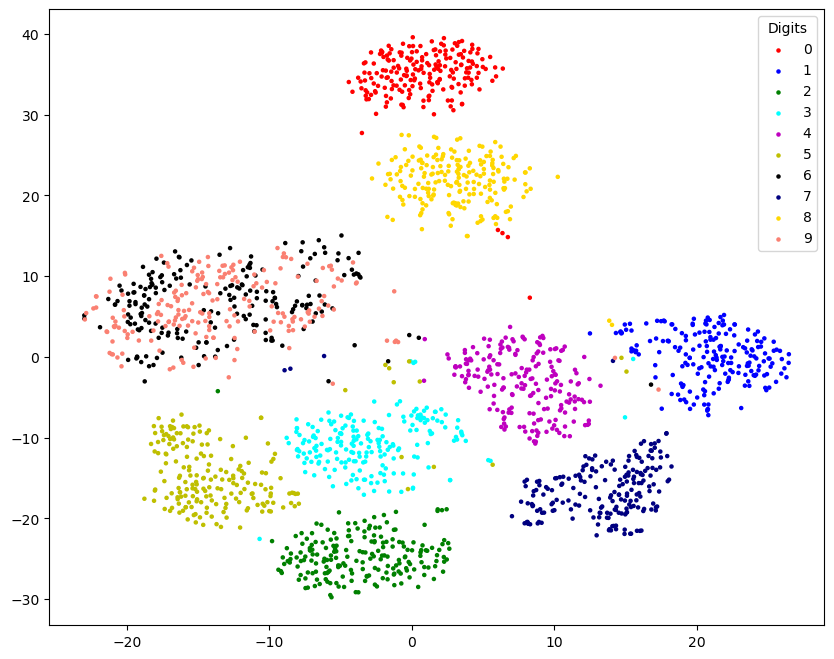

In [45]:

#a = np.array(Yout_test)
plt.figure(figsize=(10,8))
plt.scatter(Yout_dig[:,0], Yout_dig[:,1], c= y_col,marker = "o",s=5)
#plt.scatter(a[:,0], a[:,1], c= y_test,marker = ">")
for i in range(10):
    idx = np.where(Y_dig == i)
    plt.scatter(Yout_dig[idx, 0], Yout_dig[idx, 1], c=col[i], label=labels[i], s=5)

# Add legend
plt.legend(title='Digits')
plt.show()

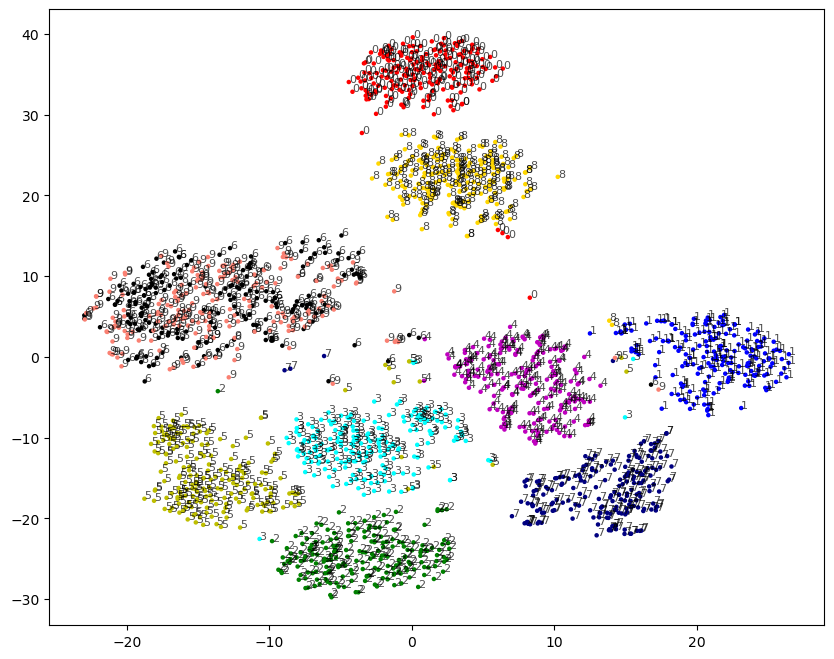

In [42]:
#a = np.array(Yout_test)
plt.figure(figsize=(10,8))
plt.scatter(Yout_dig[:,0], Yout_dig[:,1], c= y_col,marker = "o",s=5)
#plt.scatter(a[:,0], a[:,1], c= y_test,marker = ">")

for i in range(len(Yout_dig)):
    plt.annotate(str(Y_dig[i]), (Yout_dig[i, 0], Yout_dig[i, 1]), fontsize=8, alpha=0.7)


plt.show()

In [66]:
acc = []
for i in range(5):
    a_train, a_test, b_train, b_test = train_test_split(Yout_train_0, Y_cancer, test_size=0.5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    acc.append(accuracy)
print(f"t-SNE with gene dataview Accuracy: {np.mean(acc)}")

t-SNE with gene dataview Accuracy: 0.9221556886227547


In [67]:
acc = []
for i in range(5):
    a_train, a_test, b_train, b_test = train_test_split(Yout_train_1, Y_cancer, test_size=0.5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    acc.append(accuracy)
print(f"t-SNE with methy dataview Accuracy: {np.mean(acc)}")

t-SNE with methy dataview Accuracy: 0.8850299401197604


In [69]:
acc = []
for i in range(5):
    a_train, a_test, b_train, b_test = train_test_split(Yout_train_2, Y_cancer, test_size=0.5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    acc.append(accuracy)
print(f"t-SNE with mirna dataview Accuracy: {np.mean(acc)}")

t-SNE with mirna dataview Accuracy: 0.5712574850299401


In [70]:
acc = []
for i in range(5):
    a_train, a_test, b_train, b_test = train_test_split(Yout_train_multi, Y_cancer, test_size=0.5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    acc.append(accuracy)
print(f"multi-SNE with all dataviews Accuracy: {np.mean(acc)}")

multi-SNE with all dataviews Accuracy: 0.954491017964072


In [48]:
acc = []
for i in range(5):
    a_train, a_test, b_train, b_test = train_test_split(multi_cancer[0], Y_cancer, test_size=0.5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    acc.append(accuracy)
print(f"multi-SNE with gene Accuracy: {np.mean(acc)}")

multi-SNE with gene Accuracy: 0.5365269461077844


In [49]:
acc = []
for i in range(5):
    a_train, a_test, b_train, b_test = train_test_split(multi_cancer[1], Y_cancer, test_size=0.5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    acc.append(accuracy)
print(f"multi-SNE with methy Accuracy: {np.mean(acc)}")

multi-SNE with methy Accuracy: 0.48742514970059875


In [54]:
acc = []
for i in range(5):
    a_train, a_test, b_train, b_test = train_test_split(multi_cancer[2], Y_cancer, test_size=0.5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    acc.append(accuracy)
print(f"multi-SNE with mirna Accuracy: {np.mean(acc)}")

multi-SNE with mirna Accuracy: 0.5580838323353292


How to set the initial dimension, why apply PCA first.

In [57]:
init_dim_list = [i*5+10 for i in range(40)]

Yout_list = []

In [72]:
X_train_1 = np.hstack([multi_cancer[0].copy(), multi_cancer[1].copy(), multi_cancer[2].copy()])
X_train, X_test, y_train, y_test = train_test_split(X_train_1, Y_cancer, test_size=0.5)
X_train_multi = np.split(X_train, [10127, 10127+22503], axis=1)
X_test_multi = np.split(X_test, [10127, 10127+22503], axis=1)

In [79]:
for i in range(40):
    a = pca_var(X_train_multi, init_dim_list[i])
    Yout_list.append(multi_SNE_without_pca(a,  no_dims = 2,  perplexity = 35.0))

m 3
baselineDim: 166
Computing pairwise distances...
Computing P-values for point 0 of 166...


C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 29.948924
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 45.981212
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 4.924252
Iteration 10: error is 12.619566
Iteration 10: error is 12.560639
Iteration 10: error is 12.366061
Iteration 20: error is 13.037653
Iteration 20: error is 13.072984
Iteration 20: error is 12.971608
Iteration 30: error is 14.549529
Iteration 30: error is 14.516445
Iteration 30: error is 14.353898
Iteration 40: error is 14.656940
Iteration 40: error is 14.746560
Iteration 40: error is 14.369839
Iteration 50: error is 14.440367
Iteration 50: error is 14.510388
Iteration 50: error is 14.196660
Iteration 60: error is 14.002373
Iteration 60: error is 14.187989
Iteration 60: error is 13.817363
Iteration 70: error is 14.237625
Iteration 70: error is 14.316654
Iteration 70: error is 14.075638
Iteration 80: error is 13.944172
Iteration 80: error is 13.930338
Ite

Iteration 820: error is 1.436638
Iteration 820: error is 1.513454
Iteration 820: error is 1.521165
Iteration 830: error is 1.433580
Iteration 830: error is 1.511772
Iteration 830: error is 1.517239
Iteration 840: error is 1.432607
Iteration 840: error is 1.509044
Iteration 840: error is 1.512886
Iteration 850: error is 1.432455
Iteration 850: error is 1.505959
Iteration 850: error is 1.506754
Iteration 860: error is 1.433576
Iteration 860: error is 1.501766
Iteration 860: error is 1.501984
Iteration 870: error is 1.433461
Iteration 870: error is 1.498965
Iteration 870: error is 1.498445
Iteration 880: error is 1.432462
Iteration 880: error is 1.496477
Iteration 880: error is 1.495050
Iteration 890: error is 1.430952
Iteration 890: error is 1.492593
Iteration 890: error is 1.489534
Iteration 900: error is 1.430941
Iteration 900: error is 1.489615
Iteration 900: error is 1.482180
Iteration 910: error is 1.430419
Iteration 910: error is 1.490710
Iteration 910: error is 1.474787
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.294961
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 48.471415
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.288457
Iteration 10: error is 13.077030
Iteration 10: error is 13.348752
Iteration 10: error is 12.542332
Iteration 20: error is 13.247778
Iteration 20: error is 13.288017
Iteration 20: error is 13.062445
Iteration 30: error is 13.783688
Iteration 30: error is 13.901888
Iteration 30: error is 13.709474
Iteration 40: error is 14.533531
Iteration 40: error is 14.367258
Iteration 40: error is 13.919103
Iteration 50: error is 13.872261
Iteration 50: error is 13.946956
Iteration 50: error is 13.730780
Iteration 60: error is 14.284435
Iteration 60: error is 13.808218
Iteration 60: error is 14.027852
Iteration 70: error is 15.282645
Iteration 70: error is 14.737608
Iteration 70: error is 14.702405
Iteration 80: error is 14.841352
Iteration 80: error is 14.738180
Ite

Iteration 830: error is 1.556983
Iteration 830: error is 1.436511
Iteration 830: error is 1.617185
Iteration 840: error is 1.554238
Iteration 840: error is 1.433487
Iteration 840: error is 1.611788
Iteration 850: error is 1.548051
Iteration 850: error is 1.427021
Iteration 850: error is 1.609057
Iteration 860: error is 1.543054
Iteration 860: error is 1.417519
Iteration 860: error is 1.608371
Iteration 870: error is 1.539331
Iteration 870: error is 1.410452
Iteration 870: error is 1.607613
Iteration 880: error is 1.536272
Iteration 880: error is 1.405365
Iteration 880: error is 1.606339
Iteration 890: error is 1.533998
Iteration 890: error is 1.398166
Iteration 890: error is 1.603667
Iteration 900: error is 1.532275
Iteration 900: error is 1.390624
Iteration 900: error is 1.598142
Iteration 910: error is 1.529954
Iteration 910: error is 1.388929
Iteration 910: error is 1.595290
Iteration 920: error is 1.530032
Iteration 920: error is 1.386825
Iteration 920: error is 1.593547
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 33.452145
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 49.712073
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.472919
Iteration 10: error is 13.399671
Iteration 10: error is 13.063467
Iteration 10: error is 13.122873
Iteration 20: error is 13.629916
Iteration 20: error is 13.367336
Iteration 20: error is 13.604773
Iteration 30: error is 14.916287
Iteration 30: error is 14.550698
Iteration 30: error is 14.373005
Iteration 40: error is 15.320143
Iteration 40: error is 14.713316
Iteration 40: error is 14.774865
Iteration 50: error is 15.343953
Iteration 50: error is 14.929131
Iteration 50: error is 14.768241
Iteration 60: error is 15.373525
Iteration 60: error is 14.982913
Iteration 60: error is 14.523410
Iteration 70: error is 15.599520
Iteration 70: error is 15.611135
Iteration 70: error is 15.077268
Iteration 80: error is 15.598550
Iteration 80: error is 15.403840
Ite

Iteration 830: error is 0.970600
Iteration 830: error is 1.034744
Iteration 830: error is 1.065632
Iteration 840: error is 0.970600
Iteration 840: error is 1.034744
Iteration 840: error is 1.065632
Iteration 850: error is 0.970600
Iteration 850: error is 1.034744
Iteration 850: error is 1.065632
Iteration 860: error is 0.970600
Iteration 860: error is 1.034744
Iteration 860: error is 1.065632
Iteration 870: error is 0.970600
Iteration 870: error is 1.034744
Iteration 870: error is 1.065632
Iteration 880: error is 0.970600
Iteration 880: error is 1.034744
Iteration 880: error is 1.065632
Iteration 890: error is 0.970600
Iteration 890: error is 1.034744
Iteration 890: error is 1.065632
Iteration 900: error is 0.970600
Iteration 900: error is 1.034744
Iteration 900: error is 1.065632
Iteration 910: error is 0.970600
Iteration 910: error is 1.034744
Iteration 910: error is 1.065632
Iteration 920: error is 0.970600
Iteration 920: error is 1.034744
Iteration 920: error is 1.065632
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 34.510212
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 50.756610
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.581719
Iteration 10: error is 13.323313
Iteration 10: error is 13.255451
Iteration 10: error is 13.162183
Iteration 20: error is 14.180150
Iteration 20: error is 13.760773
Iteration 20: error is 13.665461
Iteration 30: error is 15.297350
Iteration 30: error is 14.909551
Iteration 30: error is 14.627769
Iteration 40: error is 15.361433
Iteration 40: error is 14.824704
Iteration 40: error is 14.683962
Iteration 50: error is 15.390983
Iteration 50: error is 14.707078
Iteration 50: error is 14.810769
Iteration 60: error is 15.095064
Iteration 60: error is 14.532318
Iteration 60: error is 14.798619
Iteration 70: error is 15.400514
Iteration 70: error is 14.888344
Iteration 70: error is 14.842473
Iteration 80: error is 15.170333
Iteration 80: error is 14.421078
Ite

Iteration 820: error is 1.060617
Iteration 820: error is 0.959681
Iteration 820: error is 1.015698
Iteration 830: error is 1.060617
Iteration 830: error is 0.959681
Iteration 830: error is 1.015698
Iteration 840: error is 1.060617
Iteration 840: error is 0.959681
Iteration 840: error is 1.015698
Iteration 850: error is 1.060617
Iteration 850: error is 0.959681
Iteration 850: error is 1.015698
Iteration 860: error is 1.060617
Iteration 860: error is 0.959681
Iteration 860: error is 1.015698
Iteration 870: error is 1.060617
Iteration 870: error is 0.959681
Iteration 870: error is 1.015698
Iteration 880: error is 1.060617
Iteration 880: error is 0.959681
Iteration 880: error is 1.015698
Iteration 890: error is 1.060617
Iteration 890: error is 0.959681
Iteration 890: error is 1.015698
Iteration 900: error is 1.060617
Iteration 900: error is 0.959681
Iteration 900: error is 1.015698
Iteration 910: error is 1.060617
Iteration 910: error is 0.959681
Iteration 910: error is 1.015698
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 35.194496
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 51.523397
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.678239
Iteration 10: error is 12.599128
Iteration 10: error is 12.836858
Iteration 10: error is 12.277701
Iteration 20: error is 14.385961
Iteration 20: error is 14.348089
Iteration 20: error is 13.978096
Iteration 30: error is 15.615960
Iteration 30: error is 15.495273
Iteration 30: error is 14.716754
Iteration 40: error is 15.885640
Iteration 40: error is 15.622267
Iteration 40: error is 15.083356
Iteration 50: error is 16.132606
Iteration 50: error is 15.855807
Iteration 50: error is 15.543209
Iteration 60: error is 15.691646
Iteration 60: error is 15.712756
Iteration 60: error is 15.416181
Iteration 70: error is 15.312133
Iteration 70: error is 15.280020
Iteration 70: error is 15.055424
Iteration 80: error is 15.359897
Iteration 80: error is 15.177021
Ite

Iteration 820: error is 0.952074
Iteration 820: error is 0.998562
Iteration 820: error is 0.984188
Iteration 830: error is 0.952078
Iteration 830: error is 0.998565
Iteration 830: error is 0.984181
Iteration 840: error is 0.952078
Iteration 840: error is 0.998561
Iteration 840: error is 0.984184
Iteration 850: error is 0.952077
Iteration 850: error is 0.998567
Iteration 850: error is 0.984180
Iteration 860: error is 0.952077
Iteration 860: error is 0.998564
Iteration 860: error is 0.984183
Iteration 870: error is 0.952076
Iteration 870: error is 0.998564
Iteration 870: error is 0.984183
Iteration 880: error is 0.952077
Iteration 880: error is 0.998565
Iteration 880: error is 0.984182
Iteration 890: error is 0.952076
Iteration 890: error is 0.998565
Iteration 890: error is 0.984183
Iteration 900: error is 0.952076
Iteration 900: error is 0.998565
Iteration 900: error is 0.984183
Iteration 910: error is 0.952076
Iteration 910: error is 0.998565
Iteration 910: error is 0.984183
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 35.748040
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 52.168790
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.781420
Iteration 10: error is 13.748374
Iteration 10: error is 13.596517
Iteration 10: error is 13.583387
Iteration 20: error is 14.967282
Iteration 20: error is 14.414609
Iteration 20: error is 14.895670
Iteration 30: error is 17.487854
Iteration 30: error is 16.843386
Iteration 30: error is 16.929089
Iteration 40: error is 17.376532
Iteration 40: error is 16.892395
Iteration 40: error is 16.917350
Iteration 50: error is 15.728028
Iteration 50: error is 15.140328
Iteration 50: error is 15.298253
Iteration 60: error is 17.065900
Iteration 60: error is 16.316387
Iteration 60: error is 16.113516
Iteration 70: error is 17.271446
Iteration 70: error is 16.230548
Iteration 70: error is 16.452219
Iteration 80: error is 17.577845
Iteration 80: error is 16.908255
Ite

Iteration 820: error is 0.978592
Iteration 820: error is 0.941192
Iteration 820: error is 1.008035
Iteration 830: error is 0.979394
Iteration 830: error is 0.941410
Iteration 830: error is 1.006959
Iteration 840: error is 0.979087
Iteration 840: error is 0.941587
Iteration 840: error is 1.007080
Iteration 850: error is 0.979059
Iteration 850: error is 0.941573
Iteration 850: error is 1.007118
Iteration 860: error is 0.978943
Iteration 860: error is 0.941584
Iteration 860: error is 1.007223
Iteration 870: error is 0.978926
Iteration 870: error is 0.941577
Iteration 870: error is 1.007246
Iteration 880: error is 0.978931
Iteration 880: error is 0.941581
Iteration 880: error is 1.007237
Iteration 890: error is 0.978940
Iteration 890: error is 0.941583
Iteration 890: error is 1.007226
Iteration 900: error is 0.978938
Iteration 900: error is 0.941587
Iteration 900: error is 1.007224
Iteration 910: error is 0.978938
Iteration 910: error is 0.941586
Iteration 910: error is 1.007224
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 36.194881
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 52.573209
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.846472
Iteration 10: error is 12.884923
Iteration 10: error is 12.597338
Iteration 10: error is 12.822239
Iteration 20: error is 14.122724
Iteration 20: error is 13.977862
Iteration 20: error is 13.777166
Iteration 30: error is 16.011160
Iteration 30: error is 15.549635
Iteration 30: error is 15.311746
Iteration 40: error is 17.128963
Iteration 40: error is 16.034381
Iteration 40: error is 15.966756
Iteration 50: error is 17.467094
Iteration 50: error is 16.488842
Iteration 50: error is 16.273530
Iteration 60: error is 17.255038
Iteration 60: error is 16.116653
Iteration 60: error is 15.994009
Iteration 70: error is 17.329462
Iteration 70: error is 16.232742
Iteration 70: error is 15.883545
Iteration 80: error is 16.288510
Iteration 80: error is 15.795137
Ite

Iteration 820: error is 1.337061
Iteration 820: error is 1.409867
Iteration 820: error is 1.345503
Iteration 830: error is 1.326817
Iteration 830: error is 1.403955
Iteration 830: error is 1.337947
Iteration 840: error is 1.313824
Iteration 840: error is 1.399124
Iteration 840: error is 1.333293
Iteration 850: error is 1.306185
Iteration 850: error is 1.395891
Iteration 850: error is 1.328361
Iteration 860: error is 1.296523
Iteration 860: error is 1.393427
Iteration 860: error is 1.327703
Iteration 870: error is 1.291274
Iteration 870: error is 1.376609
Iteration 870: error is 1.323919
Iteration 880: error is 1.282622
Iteration 880: error is 1.367556
Iteration 880: error is 1.322986
Iteration 890: error is 1.275758
Iteration 890: error is 1.362307
Iteration 890: error is 1.322804
Iteration 900: error is 1.275644
Iteration 900: error is 1.356292
Iteration 900: error is 1.322867
Iteration 910: error is 1.276982
Iteration 910: error is 1.350305
Iteration 910: error is 1.321988
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 36.470685
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 53.045218
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.901897
Iteration 10: error is 12.523232
Iteration 10: error is 12.250590
Iteration 10: error is 11.994184
Iteration 20: error is 14.606240
Iteration 20: error is 14.234408
Iteration 20: error is 13.979446
Iteration 30: error is 16.732358
Iteration 30: error is 15.832864
Iteration 30: error is 15.398177
Iteration 40: error is 17.116521
Iteration 40: error is 16.546773
Iteration 40: error is 15.924313
Iteration 50: error is 18.123543
Iteration 50: error is 17.264443
Iteration 50: error is 16.738772
Iteration 60: error is 17.440752
Iteration 60: error is 16.560845
Iteration 60: error is 16.277987
Iteration 70: error is 18.141179
Iteration 70: error is 17.486733
Iteration 70: error is 17.722167
Iteration 80: error is 17.961768
Iteration 80: error is 17.252831
Ite

Iteration 820: error is 1.343015
Iteration 820: error is 1.369741
Iteration 820: error is 1.286906
Iteration 830: error is 1.342576
Iteration 830: error is 1.365755
Iteration 830: error is 1.284433
Iteration 840: error is 1.342116
Iteration 840: error is 1.360595
Iteration 840: error is 1.281523
Iteration 850: error is 1.340719
Iteration 850: error is 1.350193
Iteration 850: error is 1.277192
Iteration 860: error is 1.336762
Iteration 860: error is 1.337308
Iteration 860: error is 1.273193
Iteration 870: error is 1.332361
Iteration 870: error is 1.327659
Iteration 870: error is 1.273861
Iteration 880: error is 1.325910
Iteration 880: error is 1.318263
Iteration 880: error is 1.274027
Iteration 890: error is 1.318136
Iteration 890: error is 1.317770
Iteration 890: error is 1.267067
Iteration 900: error is 1.309808
Iteration 900: error is 1.312223
Iteration 900: error is 1.269635
Iteration 910: error is 1.302137
Iteration 910: error is 1.310181
Iteration 910: error is 1.269439
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 36.832289
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 53.602272
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.962175
Iteration 10: error is 13.345858
Iteration 10: error is 13.457899
Iteration 10: error is 13.271152
Iteration 20: error is 15.457579
Iteration 20: error is 15.464261
Iteration 20: error is 15.056850
Iteration 30: error is 17.064172
Iteration 30: error is 16.771504
Iteration 30: error is 16.277027
Iteration 40: error is 17.870021
Iteration 40: error is 16.811764
Iteration 40: error is 16.463208
Iteration 50: error is 17.448972
Iteration 50: error is 16.207481
Iteration 50: error is 15.966791
Iteration 60: error is 16.889831
Iteration 60: error is 16.036947
Iteration 60: error is 16.148979
Iteration 70: error is 17.548015
Iteration 70: error is 16.528663
Iteration 70: error is 16.695349
Iteration 80: error is 16.830843
Iteration 80: error is 16.095279
Ite

Iteration 820: error is 1.366337
Iteration 820: error is 1.470431
Iteration 820: error is 1.351365
Iteration 830: error is 1.366015
Iteration 830: error is 1.468578
Iteration 830: error is 1.349890
Iteration 840: error is 1.365618
Iteration 840: error is 1.467239
Iteration 840: error is 1.348913
Iteration 850: error is 1.364838
Iteration 850: error is 1.465465
Iteration 850: error is 1.348406
Iteration 860: error is 1.363162
Iteration 860: error is 1.463451
Iteration 860: error is 1.347964
Iteration 870: error is 1.360007
Iteration 870: error is 1.460876
Iteration 870: error is 1.346920
Iteration 880: error is 1.356792
Iteration 880: error is 1.459121
Iteration 880: error is 1.344893
Iteration 890: error is 1.352852
Iteration 890: error is 1.457656
Iteration 890: error is 1.343421
Iteration 900: error is 1.350760
Iteration 900: error is 1.453850
Iteration 900: error is 1.342986
Iteration 910: error is 1.350006
Iteration 910: error is 1.449857
Iteration 910: error is 1.341312
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 37.060794
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 54.088381
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.994295
Iteration 10: error is 13.406313
Iteration 10: error is 13.228166
Iteration 10: error is 13.407340
Iteration 20: error is 14.859660
Iteration 20: error is 14.077032
Iteration 20: error is 14.598012
Iteration 30: error is 15.427081
Iteration 30: error is 15.010078
Iteration 30: error is 15.281686
Iteration 40: error is 16.417883
Iteration 40: error is 15.626992
Iteration 40: error is 15.991761
Iteration 50: error is 17.190145
Iteration 50: error is 16.742269
Iteration 50: error is 16.332933
Iteration 60: error is 17.348097
Iteration 60: error is 16.195696
Iteration 60: error is 16.709925
Iteration 70: error is 17.719649
Iteration 70: error is 15.843161
Iteration 70: error is 16.444775
Iteration 80: error is 17.974788
Iteration 80: error is 16.790789
Ite

Iteration 820: error is 1.309044
Iteration 820: error is 1.356497
Iteration 820: error is 1.390782
Iteration 830: error is 1.308031
Iteration 830: error is 1.355808
Iteration 830: error is 1.389962
Iteration 840: error is 1.307364
Iteration 840: error is 1.354147
Iteration 840: error is 1.388715
Iteration 850: error is 1.306979
Iteration 850: error is 1.350433
Iteration 850: error is 1.389162
Iteration 860: error is 1.305835
Iteration 860: error is 1.346562
Iteration 860: error is 1.390618
Iteration 870: error is 1.304590
Iteration 870: error is 1.344214
Iteration 870: error is 1.391110
Iteration 880: error is 1.303865
Iteration 880: error is 1.341791
Iteration 880: error is 1.390522
Iteration 890: error is 1.303184
Iteration 890: error is 1.338334
Iteration 890: error is 1.389169
Iteration 900: error is 1.303030
Iteration 900: error is 1.334050
Iteration 900: error is 1.388847
Iteration 910: error is 1.301645
Iteration 910: error is 1.331396
Iteration 910: error is 1.389259
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 37.334064
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 54.657228
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.026259
Iteration 10: error is 13.541992
Iteration 10: error is 13.063136
Iteration 10: error is 13.012278
Iteration 20: error is 14.772884
Iteration 20: error is 14.722197
Iteration 20: error is 14.636124
Iteration 30: error is 16.133289
Iteration 30: error is 15.934672
Iteration 30: error is 15.541797
Iteration 40: error is 16.400974
Iteration 40: error is 15.607751
Iteration 40: error is 15.673087
Iteration 50: error is 17.931454
Iteration 50: error is 16.447035
Iteration 50: error is 16.597333
Iteration 60: error is 17.731600
Iteration 60: error is 16.471724
Iteration 60: error is 16.817718
Iteration 70: error is 17.314799
Iteration 70: error is 16.668721
Iteration 70: error is 16.357656
Iteration 80: error is 17.857335
Iteration 80: error is 16.570282
Ite

Iteration 830: error is 1.368990
Iteration 830: error is 1.379009
Iteration 830: error is 1.353612
Iteration 840: error is 1.369288
Iteration 840: error is 1.378798
Iteration 840: error is 1.352514
Iteration 850: error is 1.369690
Iteration 850: error is 1.378596
Iteration 850: error is 1.351567
Iteration 860: error is 1.370273
Iteration 860: error is 1.378304
Iteration 860: error is 1.350613
Iteration 870: error is 1.370797
Iteration 870: error is 1.377828
Iteration 870: error is 1.349649
Iteration 880: error is 1.371249
Iteration 880: error is 1.376637
Iteration 880: error is 1.348560
Iteration 890: error is 1.372897
Iteration 890: error is 1.375146
Iteration 890: error is 1.346407
Iteration 900: error is 1.373922
Iteration 900: error is 1.374232
Iteration 900: error is 1.344180
Iteration 910: error is 1.374644
Iteration 910: error is 1.373006
Iteration 910: error is 1.342279
Iteration 920: error is 1.376049
Iteration 920: error is 1.370170
Iteration 920: error is 1.341422
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 37.552689
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 55.189879
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.072735
Iteration 10: error is 13.701971
Iteration 10: error is 13.530995
Iteration 10: error is 13.287829
Iteration 20: error is 15.914939
Iteration 20: error is 15.493694
Iteration 20: error is 15.713903
Iteration 30: error is 16.864554
Iteration 30: error is 16.225702
Iteration 30: error is 15.784158
Iteration 40: error is 16.717857
Iteration 40: error is 16.265758
Iteration 40: error is 16.269075
Iteration 50: error is 16.632796
Iteration 50: error is 15.984253
Iteration 50: error is 15.801824
Iteration 60: error is 17.342442
Iteration 60: error is 16.706157
Iteration 60: error is 16.393870
Iteration 70: error is 16.866537
Iteration 70: error is 15.477007
Iteration 70: error is 15.219128
Iteration 80: error is 17.177713
Iteration 80: error is 15.854291
Ite

Iteration 820: error is 0.941920
Iteration 820: error is 0.948678
Iteration 820: error is 0.938143
Iteration 830: error is 0.941921
Iteration 830: error is 0.948647
Iteration 830: error is 0.938170
Iteration 840: error is 0.941917
Iteration 840: error is 0.948668
Iteration 840: error is 0.938151
Iteration 850: error is 0.941909
Iteration 850: error is 0.948681
Iteration 850: error is 0.938146
Iteration 860: error is 0.941913
Iteration 860: error is 0.948666
Iteration 860: error is 0.938156
Iteration 870: error is 0.941912
Iteration 870: error is 0.948667
Iteration 870: error is 0.938156
Iteration 880: error is 0.941914
Iteration 880: error is 0.948666
Iteration 880: error is 0.938156
Iteration 890: error is 0.941912
Iteration 890: error is 0.948665
Iteration 890: error is 0.938158
Iteration 900: error is 0.941913
Iteration 900: error is 0.948666
Iteration 900: error is 0.938157
Iteration 910: error is 0.941913
Iteration 910: error is 0.948666
Iteration 910: error is 0.938157
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 37.819435
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 55.824745
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.102740
Iteration 10: error is 13.219328
Iteration 10: error is 13.670375
Iteration 10: error is 13.396807
Iteration 20: error is 13.995492
Iteration 20: error is 14.740556
Iteration 20: error is 14.378255
Iteration 30: error is 16.932668
Iteration 30: error is 15.632559
Iteration 30: error is 15.956765
Iteration 40: error is 18.008350
Iteration 40: error is 17.428905
Iteration 40: error is 17.043860
Iteration 50: error is 18.588473
Iteration 50: error is 17.536224
Iteration 50: error is 17.162180
Iteration 60: error is 19.438954
Iteration 60: error is 18.224662
Iteration 60: error is 18.194786
Iteration 70: error is 18.385376
Iteration 70: error is 17.611117
Iteration 70: error is 17.235503
Iteration 80: error is 21.541458
Iteration 80: error is 18.953911
Ite

Iteration 830: error is 1.314023
Iteration 830: error is 1.340658
Iteration 830: error is 1.300806
Iteration 840: error is 1.311986
Iteration 840: error is 1.336714
Iteration 840: error is 1.303749
Iteration 850: error is 1.311717
Iteration 850: error is 1.336111
Iteration 850: error is 1.302541
Iteration 860: error is 1.311086
Iteration 860: error is 1.334281
Iteration 860: error is 1.301439
Iteration 870: error is 1.312904
Iteration 870: error is 1.328857
Iteration 870: error is 1.298372
Iteration 880: error is 1.310662
Iteration 880: error is 1.324996
Iteration 880: error is 1.296138
Iteration 890: error is 1.310580
Iteration 890: error is 1.316079
Iteration 890: error is 1.295681
Iteration 900: error is 1.309914
Iteration 900: error is 1.311914
Iteration 900: error is 1.294446
Iteration 910: error is 1.308284
Iteration 910: error is 1.313211
Iteration 910: error is 1.288741
Iteration 920: error is 1.307598
Iteration 920: error is 1.311594
Iteration 920: error is 1.287607
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.003956
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 56.515672
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.132341
Iteration 10: error is 14.732696
Iteration 10: error is 14.724245
Iteration 10: error is 14.961749
Iteration 20: error is 15.027301
Iteration 20: error is 15.156210
Iteration 20: error is 15.163830
Iteration 30: error is 20.032373
Iteration 30: error is 19.116440
Iteration 30: error is 19.256462
Iteration 40: error is 19.429366
Iteration 40: error is 18.282924
Iteration 40: error is 18.724629
Iteration 50: error is 19.271987
Iteration 50: error is 17.749099
Iteration 50: error is 18.558642
Iteration 60: error is 18.646744
Iteration 60: error is 17.217324
Iteration 60: error is 17.866999
Iteration 70: error is 18.063781
Iteration 70: error is 17.055877
Iteration 70: error is 18.095942
Iteration 80: error is 18.151820
Iteration 80: error is 17.074014
Ite

Iteration 820: error is 1.426716
Iteration 820: error is 1.298859
Iteration 820: error is 1.355476
Iteration 830: error is 1.427106
Iteration 830: error is 1.297495
Iteration 830: error is 1.354297
Iteration 840: error is 1.427052
Iteration 840: error is 1.295314
Iteration 840: error is 1.354380
Iteration 850: error is 1.426193
Iteration 850: error is 1.292575
Iteration 850: error is 1.355479
Iteration 860: error is 1.425400
Iteration 860: error is 1.289385
Iteration 860: error is 1.356546
Iteration 870: error is 1.425004
Iteration 870: error is 1.286926
Iteration 870: error is 1.357164
Iteration 880: error is 1.425697
Iteration 880: error is 1.284586
Iteration 880: error is 1.356614
Iteration 890: error is 1.427548
Iteration 890: error is 1.280905
Iteration 890: error is 1.354768
Iteration 900: error is 1.428644
Iteration 900: error is 1.278766
Iteration 900: error is 1.351568
Iteration 910: error is 1.426370
Iteration 910: error is 1.279508
Iteration 910: error is 1.350376
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.163516
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 57.250332
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.151770
Iteration 10: error is 14.112243
Iteration 10: error is 13.798450
Iteration 10: error is 13.495027
Iteration 20: error is 14.659830
Iteration 20: error is 15.121377
Iteration 20: error is 14.674744
Iteration 30: error is 16.049175
Iteration 30: error is 17.070369
Iteration 30: error is 16.516804
Iteration 40: error is 17.525885
Iteration 40: error is 16.944987
Iteration 40: error is 16.687390
Iteration 50: error is 18.276800
Iteration 50: error is 17.480316
Iteration 50: error is 17.149290
Iteration 60: error is 18.619504
Iteration 60: error is 17.762234
Iteration 60: error is 17.157153
Iteration 70: error is 18.697099
Iteration 70: error is 17.477392
Iteration 70: error is 17.306288
Iteration 80: error is 17.934487
Iteration 80: error is 16.514110
Ite

Iteration 830: error is 1.340882
Iteration 830: error is 1.363097
Iteration 830: error is 1.311729
Iteration 840: error is 1.339506
Iteration 840: error is 1.362492
Iteration 840: error is 1.309865
Iteration 850: error is 1.337681
Iteration 850: error is 1.361211
Iteration 850: error is 1.306560
Iteration 860: error is 1.335545
Iteration 860: error is 1.357558
Iteration 860: error is 1.304925
Iteration 870: error is 1.328107
Iteration 870: error is 1.353002
Iteration 870: error is 1.304441
Iteration 880: error is 1.336119
Iteration 880: error is 1.361296
Iteration 880: error is 1.315655
Iteration 890: error is 1.327163
Iteration 890: error is 1.351523
Iteration 890: error is 1.315599
Iteration 900: error is 1.325373
Iteration 900: error is 1.342300
Iteration 900: error is 1.301782
Iteration 910: error is 1.320434
Iteration 910: error is 1.338056
Iteration 910: error is 1.288356
Iteration 920: error is 1.311237
Iteration 920: error is 1.322909
Iteration 920: error is 1.284653
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.446060
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 57.993083
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.168039
Iteration 10: error is 13.232765
Iteration 10: error is 13.960570
Iteration 10: error is 13.756409
Iteration 20: error is 15.157561
Iteration 20: error is 14.788943
Iteration 20: error is 14.495336
Iteration 30: error is 17.647660
Iteration 30: error is 16.335515
Iteration 30: error is 16.663250
Iteration 40: error is 17.758345
Iteration 40: error is 16.499512
Iteration 40: error is 17.251044
Iteration 50: error is 16.831106
Iteration 50: error is 15.880435
Iteration 50: error is 16.513665
Iteration 60: error is 18.101636
Iteration 60: error is 16.428242
Iteration 60: error is 16.724397
Iteration 70: error is 18.316693
Iteration 70: error is 16.638152
Iteration 70: error is 16.870469
Iteration 80: error is 18.196196
Iteration 80: error is 16.603513
Ite

Iteration 830: error is 1.364742
Iteration 830: error is 1.451288
Iteration 830: error is 1.324979
Iteration 840: error is 1.364611
Iteration 840: error is 1.449045
Iteration 840: error is 1.324089
Iteration 850: error is 1.364019
Iteration 850: error is 1.447351
Iteration 850: error is 1.322564
Iteration 860: error is 1.363247
Iteration 860: error is 1.445990
Iteration 860: error is 1.320330
Iteration 870: error is 1.362598
Iteration 870: error is 1.444479
Iteration 870: error is 1.317799
Iteration 880: error is 1.361924
Iteration 880: error is 1.442495
Iteration 880: error is 1.315515
Iteration 890: error is 1.361422
Iteration 890: error is 1.440471
Iteration 890: error is 1.313701
Iteration 900: error is 1.360594
Iteration 900: error is 1.439610
Iteration 900: error is 1.312249
Iteration 910: error is 1.359365
Iteration 910: error is 1.439411
Iteration 910: error is 1.310056
Iteration 920: error is 1.357774
Iteration 920: error is 1.439175
Iteration 920: error is 1.307557
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.748271
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 58.683389
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.183048
Iteration 10: error is 13.408818
Iteration 10: error is 13.643789
Iteration 10: error is 13.563036
Iteration 20: error is 15.436818
Iteration 20: error is 14.734160
Iteration 20: error is 14.824526
Iteration 30: error is 18.029034
Iteration 30: error is 17.835619
Iteration 30: error is 17.469185
Iteration 40: error is 17.509378
Iteration 40: error is 17.315760
Iteration 40: error is 16.814767
Iteration 50: error is 17.690388
Iteration 50: error is 17.674771
Iteration 50: error is 17.336328
Iteration 60: error is 19.384231
Iteration 60: error is 17.194781
Iteration 60: error is 17.758134
Iteration 70: error is 19.053380
Iteration 70: error is 18.090549
Iteration 70: error is 18.651634
Iteration 80: error is 18.532817
Iteration 80: error is 17.447325
Ite

Iteration 820: error is 1.398927
Iteration 820: error is 1.327456
Iteration 820: error is 1.351967
Iteration 830: error is 1.397535
Iteration 830: error is 1.327421
Iteration 830: error is 1.351382
Iteration 840: error is 1.396348
Iteration 840: error is 1.327518
Iteration 840: error is 1.350492
Iteration 850: error is 1.395340
Iteration 850: error is 1.327705
Iteration 850: error is 1.348970
Iteration 860: error is 1.394374
Iteration 860: error is 1.328139
Iteration 860: error is 1.346699
Iteration 870: error is 1.392630
Iteration 870: error is 1.328380
Iteration 870: error is 1.345185
Iteration 880: error is 1.391673
Iteration 880: error is 1.327873
Iteration 880: error is 1.344335
Iteration 890: error is 1.391397
Iteration 890: error is 1.326712
Iteration 890: error is 1.343936
Iteration 900: error is 1.390983
Iteration 900: error is 1.325369
Iteration 900: error is 1.343971
Iteration 910: error is 1.390443
Iteration 910: error is 1.324071
Iteration 910: error is 1.344152
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.950013
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 59.298279
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.196752
Iteration 10: error is 14.204379
Iteration 10: error is 13.960045
Iteration 10: error is 13.928193
Iteration 20: error is 16.293752
Iteration 20: error is 15.357562
Iteration 20: error is 16.513177
Iteration 30: error is 19.625733
Iteration 30: error is 17.907309
Iteration 30: error is 18.716515
Iteration 40: error is 20.179991
Iteration 40: error is 18.634922
Iteration 40: error is 18.480956
Iteration 50: error is 20.682634
Iteration 50: error is 19.043040
Iteration 50: error is 18.457221
Iteration 60: error is 18.874806
Iteration 60: error is 18.562673
Iteration 60: error is 18.138565
Iteration 70: error is 21.123061
Iteration 70: error is 19.638694
Iteration 70: error is 18.876850
Iteration 80: error is 21.774443
Iteration 80: error is 18.759260
Ite

Iteration 820: error is 1.275527
Iteration 820: error is 1.309462
Iteration 820: error is 1.288746
Iteration 830: error is 1.271790
Iteration 830: error is 1.309781
Iteration 830: error is 1.288499
Iteration 840: error is 1.269374
Iteration 840: error is 1.309290
Iteration 840: error is 1.288487
Iteration 850: error is 1.268095
Iteration 850: error is 1.309548
Iteration 850: error is 1.287016
Iteration 860: error is 1.267723
Iteration 860: error is 1.310201
Iteration 860: error is 1.283791
Iteration 870: error is 1.266251
Iteration 870: error is 1.312504
Iteration 870: error is 1.281213
Iteration 880: error is 1.265042
Iteration 880: error is 1.313503
Iteration 880: error is 1.280061
Iteration 890: error is 1.264152
Iteration 890: error is 1.313512
Iteration 890: error is 1.279493
Iteration 900: error is 1.262560
Iteration 900: error is 1.312515
Iteration 900: error is 1.280052
Iteration 910: error is 1.262356
Iteration 910: error is 1.311186
Iteration 910: error is 1.279979
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.186341
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 59.886732
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.210515
Iteration 10: error is 13.204135
Iteration 10: error is 13.661935
Iteration 10: error is 13.371624
Iteration 20: error is 15.447469
Iteration 20: error is 15.733078
Iteration 20: error is 15.503688
Iteration 30: error is 17.911155
Iteration 30: error is 17.705970
Iteration 30: error is 16.784397
Iteration 40: error is 18.848492
Iteration 40: error is 19.059026
Iteration 40: error is 18.533584
Iteration 50: error is 20.391691
Iteration 50: error is 21.527798
Iteration 50: error is 20.273565
Iteration 60: error is 19.078209
Iteration 60: error is 19.866790
Iteration 60: error is 18.736963
Iteration 70: error is 20.974498
Iteration 70: error is 20.380044
Iteration 70: error is 19.336266
Iteration 80: error is 20.409124
Iteration 80: error is 19.343230
Ite

Iteration 820: error is 1.409887
Iteration 820: error is 1.286984
Iteration 820: error is 1.286046
Iteration 830: error is 1.409964
Iteration 830: error is 1.286136
Iteration 830: error is 1.285829
Iteration 840: error is 1.410159
Iteration 840: error is 1.285399
Iteration 840: error is 1.285727
Iteration 850: error is 1.410260
Iteration 850: error is 1.285057
Iteration 850: error is 1.285371
Iteration 860: error is 1.410896
Iteration 860: error is 1.283878
Iteration 860: error is 1.284750
Iteration 870: error is 1.411242
Iteration 870: error is 1.280615
Iteration 870: error is 1.281533
Iteration 880: error is 1.408908
Iteration 880: error is 1.280258
Iteration 880: error is 1.277800
Iteration 890: error is 1.406310
Iteration 890: error is 1.280022
Iteration 890: error is 1.276361
Iteration 900: error is 1.405823
Iteration 900: error is 1.279863
Iteration 900: error is 1.275155
Iteration 910: error is 1.405184
Iteration 910: error is 1.279526
Iteration 910: error is 1.274712
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.411582
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 60.593036
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.214399
Iteration 10: error is 14.198339
Iteration 10: error is 13.459858
Iteration 10: error is 12.766827
Iteration 20: error is 16.539810
Iteration 20: error is 16.719435
Iteration 20: error is 15.812609
Iteration 30: error is 19.534926
Iteration 30: error is 19.470456
Iteration 30: error is 17.748232
Iteration 40: error is 20.482027
Iteration 40: error is 20.010782
Iteration 40: error is 19.183181
Iteration 50: error is 21.065747
Iteration 50: error is 19.766052
Iteration 50: error is 19.929525
Iteration 60: error is 20.133980
Iteration 60: error is 18.409351
Iteration 60: error is 18.413890
Iteration 70: error is 21.734806
Iteration 70: error is 19.578868
Iteration 70: error is 20.126347
Iteration 80: error is 22.382531
Iteration 80: error is 19.848225
Ite

Iteration 830: error is 1.450477
Iteration 830: error is 1.445835
Iteration 830: error is 1.333597
Iteration 840: error is 1.451556
Iteration 840: error is 1.438167
Iteration 840: error is 1.331647
Iteration 850: error is 1.452154
Iteration 850: error is 1.431746
Iteration 850: error is 1.330745
Iteration 860: error is 1.450318
Iteration 860: error is 1.430020
Iteration 860: error is 1.328706
Iteration 870: error is 1.448791
Iteration 870: error is 1.428937
Iteration 870: error is 1.328059
Iteration 880: error is 1.447671
Iteration 880: error is 1.427770
Iteration 880: error is 1.327730
Iteration 890: error is 1.447109
Iteration 890: error is 1.426798
Iteration 890: error is 1.327160
Iteration 900: error is 1.447482
Iteration 900: error is 1.424949
Iteration 900: error is 1.326778
Iteration 910: error is 1.447962
Iteration 910: error is 1.421645
Iteration 910: error is 1.326952
Iteration 920: error is 1.449041
Iteration 920: error is 1.418114
Iteration 920: error is 1.326438
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.658110
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 61.112590
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.223471
Iteration 10: error is 14.295588
Iteration 10: error is 14.289171
Iteration 10: error is 13.589374
Iteration 20: error is 16.340214
Iteration 20: error is 15.479922
Iteration 20: error is 15.620826
Iteration 30: error is 20.322014
Iteration 30: error is 18.605567
Iteration 30: error is 18.261555
Iteration 40: error is 20.113641
Iteration 40: error is 17.656056
Iteration 40: error is 17.691481
Iteration 50: error is 20.783017
Iteration 50: error is 18.518538
Iteration 50: error is 18.530008
Iteration 60: error is 22.139451
Iteration 60: error is 18.869668
Iteration 60: error is 19.652929
Iteration 70: error is 22.576572
Iteration 70: error is 19.587992
Iteration 70: error is 20.195582
Iteration 80: error is 21.480011
Iteration 80: error is 18.219408
Ite

Iteration 820: error is 1.407563
Iteration 820: error is 1.349762
Iteration 820: error is 1.361977
Iteration 830: error is 1.405499
Iteration 830: error is 1.352518
Iteration 830: error is 1.355274
Iteration 840: error is 1.403735
Iteration 840: error is 1.352015
Iteration 840: error is 1.350822
Iteration 850: error is 1.402819
Iteration 850: error is 1.350760
Iteration 850: error is 1.348386
Iteration 860: error is 1.402022
Iteration 860: error is 1.350045
Iteration 860: error is 1.347864
Iteration 870: error is 1.401467
Iteration 870: error is 1.349181
Iteration 870: error is 1.348036
Iteration 880: error is 1.400901
Iteration 880: error is 1.348206
Iteration 880: error is 1.348093
Iteration 890: error is 1.400050
Iteration 890: error is 1.346086
Iteration 890: error is 1.348082
Iteration 900: error is 1.397850
Iteration 900: error is 1.343637
Iteration 900: error is 1.346208
Iteration 910: error is 1.398150
Iteration 910: error is 1.341076
Iteration 910: error is 1.343849
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.883336
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 61.687726
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.227265
Iteration 10: error is 14.417091
Iteration 10: error is 14.916640
Iteration 10: error is 14.862486
Iteration 20: error is 17.447434
Iteration 20: error is 17.385040
Iteration 20: error is 17.114790
Iteration 30: error is 21.844873
Iteration 30: error is 20.627039
Iteration 30: error is 20.174488
Iteration 40: error is 22.217230
Iteration 40: error is 20.688106
Iteration 40: error is 20.168237
Iteration 50: error is 22.868640
Iteration 50: error is 22.040751
Iteration 50: error is 21.398794
Iteration 60: error is 21.360733
Iteration 60: error is 20.442023
Iteration 60: error is 20.316456
Iteration 70: error is 20.906680
Iteration 70: error is 20.304473
Iteration 70: error is 19.402165
Iteration 80: error is 22.204064
Iteration 80: error is 20.567946
Ite

Iteration 830: error is 1.319509
Iteration 830: error is 1.431800
Iteration 830: error is 1.333459
Iteration 840: error is 1.318912
Iteration 840: error is 1.431852
Iteration 840: error is 1.332819
Iteration 850: error is 1.317113
Iteration 850: error is 1.432077
Iteration 850: error is 1.330846
Iteration 860: error is 1.316175
Iteration 860: error is 1.433508
Iteration 860: error is 1.327829
Iteration 870: error is 1.313864
Iteration 870: error is 1.433269
Iteration 870: error is 1.328084
Iteration 880: error is 1.312736
Iteration 880: error is 1.433074
Iteration 880: error is 1.327614
Iteration 890: error is 1.313246
Iteration 890: error is 1.432573
Iteration 890: error is 1.325214
Iteration 900: error is 1.312984
Iteration 900: error is 1.433264
Iteration 900: error is 1.322397
Iteration 910: error is 1.313151
Iteration 910: error is 1.432607
Iteration 910: error is 1.320962
Iteration 920: error is 1.312458
Iteration 920: error is 1.433103
Iteration 920: error is 1.319967
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.977905
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 62.177698
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.228632
Iteration 10: error is 14.141540
Iteration 10: error is 13.444697
Iteration 10: error is 13.421218
Iteration 20: error is 16.522127
Iteration 20: error is 16.083714
Iteration 20: error is 15.044410
Iteration 30: error is 20.268567
Iteration 30: error is 19.139911
Iteration 30: error is 18.529307
Iteration 40: error is 21.814602
Iteration 40: error is 19.531918
Iteration 40: error is 19.042679
Iteration 50: error is 20.937958
Iteration 50: error is 20.337153
Iteration 50: error is 19.488743
Iteration 60: error is 20.649510
Iteration 60: error is 17.628907
Iteration 60: error is 18.373587
Iteration 70: error is 20.537601
Iteration 70: error is 19.167830
Iteration 70: error is 18.687811
Iteration 80: error is 20.266119
Iteration 80: error is 19.580118
Ite

Iteration 830: error is 1.383544
Iteration 830: error is 1.390569
Iteration 830: error is 1.253275
Iteration 840: error is 1.381824
Iteration 840: error is 1.391088
Iteration 840: error is 1.250726
Iteration 850: error is 1.379412
Iteration 850: error is 1.391846
Iteration 850: error is 1.248495
Iteration 860: error is 1.378422
Iteration 860: error is 1.392114
Iteration 860: error is 1.247574
Iteration 870: error is 1.377952
Iteration 870: error is 1.392142
Iteration 870: error is 1.247006
Iteration 880: error is 1.377612
Iteration 880: error is 1.392569
Iteration 880: error is 1.245920
Iteration 890: error is 1.377180
Iteration 890: error is 1.392871
Iteration 890: error is 1.244731
Iteration 900: error is 1.376879
Iteration 900: error is 1.393178
Iteration 900: error is 1.243276
Iteration 910: error is 1.376467
Iteration 910: error is 1.393540
Iteration 910: error is 1.241883
Iteration 920: error is 1.374910
Iteration 920: error is 1.393146
Iteration 920: error is 1.241441
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 40.104812
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 62.500907
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.220678
Iteration 10: error is 15.862352
Iteration 10: error is 14.220167
Iteration 10: error is 14.449044
Iteration 20: error is 18.546699
Iteration 20: error is 15.842128
Iteration 20: error is 16.333125
Iteration 30: error is 21.909883
Iteration 30: error is 19.801855
Iteration 30: error is 19.620021
Iteration 40: error is 19.401637
Iteration 40: error is 21.085271
Iteration 40: error is 18.434140
Iteration 50: error is 19.327604
Iteration 50: error is 20.744204
Iteration 50: error is 18.539339
Iteration 60: error is 20.192674
Iteration 60: error is 20.842152
Iteration 60: error is 19.256902
Iteration 70: error is 19.027173
Iteration 70: error is 19.362579
Iteration 70: error is 18.293344
Iteration 80: error is 20.429273
Iteration 80: error is 19.140993
Ite

Iteration 830: error is 1.373419
Iteration 830: error is 1.344302
Iteration 830: error is 1.344637
Iteration 840: error is 1.371756
Iteration 840: error is 1.343802
Iteration 840: error is 1.343055
Iteration 850: error is 1.370505
Iteration 850: error is 1.333734
Iteration 850: error is 1.344567
Iteration 860: error is 1.363896
Iteration 860: error is 1.310253
Iteration 860: error is 1.351432
Iteration 870: error is 1.359813
Iteration 870: error is 1.299969
Iteration 870: error is 1.353716
Iteration 880: error is 1.360223
Iteration 880: error is 1.297564
Iteration 880: error is 1.351511
Iteration 890: error is 1.359436
Iteration 890: error is 1.296187
Iteration 890: error is 1.350247
Iteration 900: error is 1.357402
Iteration 900: error is 1.294761
Iteration 900: error is 1.349834
Iteration 910: error is 1.354955
Iteration 910: error is 1.294236
Iteration 910: error is 1.347609
Iteration 920: error is 1.354102
Iteration 920: error is 1.293023
Iteration 920: error is 1.345109
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 40.113369
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 62.952788
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.215986
Iteration 10: error is 15.020563
Iteration 10: error is 14.106096
Iteration 10: error is 14.213376
Iteration 20: error is 16.475094
Iteration 20: error is 16.486250
Iteration 20: error is 15.794474
Iteration 30: error is 23.038114
Iteration 30: error is 19.694091
Iteration 30: error is 18.920800
Iteration 40: error is 23.210526
Iteration 40: error is 20.573116
Iteration 40: error is 18.981321
Iteration 50: error is 23.115984
Iteration 50: error is 20.081824
Iteration 50: error is 19.123869
Iteration 60: error is 23.268970
Iteration 60: error is 19.848194
Iteration 60: error is 19.389689
Iteration 70: error is 24.012516
Iteration 70: error is 18.775877
Iteration 70: error is 18.728286
Iteration 80: error is 22.829144
Iteration 80: error is 19.212065
Ite

Iteration 820: error is 1.445180
Iteration 820: error is 1.380839
Iteration 820: error is 1.370334
Iteration 830: error is 1.444339
Iteration 830: error is 1.379876
Iteration 830: error is 1.370289
Iteration 840: error is 1.443169
Iteration 840: error is 1.378916
Iteration 840: error is 1.369962
Iteration 850: error is 1.442357
Iteration 850: error is 1.378039
Iteration 850: error is 1.369434
Iteration 860: error is 1.441573
Iteration 860: error is 1.376196
Iteration 860: error is 1.368903
Iteration 870: error is 1.440737
Iteration 870: error is 1.373341
Iteration 870: error is 1.368230
Iteration 880: error is 1.439527
Iteration 880: error is 1.372170
Iteration 880: error is 1.367511
Iteration 890: error is 1.438760
Iteration 890: error is 1.372020
Iteration 890: error is 1.366533
Iteration 900: error is 1.438444
Iteration 900: error is 1.371751
Iteration 900: error is 1.365723
Iteration 910: error is 1.438508
Iteration 910: error is 1.371383
Iteration 910: error is 1.364579
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 40.227702
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 63.352130
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.210584
Iteration 10: error is 14.922475
Iteration 10: error is 12.866010
Iteration 10: error is 13.423040
Iteration 20: error is 20.713596
Iteration 20: error is 16.150510
Iteration 20: error is 16.667919
Iteration 30: error is 22.068513
Iteration 30: error is 19.641487
Iteration 30: error is 18.829122
Iteration 40: error is 22.588018
Iteration 40: error is 20.946572
Iteration 40: error is 19.764163
Iteration 50: error is 25.223591
Iteration 50: error is 20.924749
Iteration 50: error is 21.102122
Iteration 60: error is 25.483158
Iteration 60: error is 21.334868
Iteration 60: error is 20.670399
Iteration 70: error is 24.959160
Iteration 70: error is 20.631724
Iteration 70: error is 21.289782
Iteration 80: error is 23.211599
Iteration 80: error is 19.000299
Ite

Iteration 820: error is 1.419638
Iteration 820: error is 1.456768
Iteration 820: error is 1.379717
Iteration 830: error is 1.416818
Iteration 830: error is 1.452686
Iteration 830: error is 1.376874
Iteration 840: error is 1.412389
Iteration 840: error is 1.450045
Iteration 840: error is 1.373391
Iteration 850: error is 1.408673
Iteration 850: error is 1.447174
Iteration 850: error is 1.371243
Iteration 860: error is 1.406581
Iteration 860: error is 1.445746
Iteration 860: error is 1.370282
Iteration 870: error is 1.405558
Iteration 870: error is 1.444253
Iteration 870: error is 1.369566
Iteration 880: error is 1.404695
Iteration 880: error is 1.441781
Iteration 880: error is 1.368878
Iteration 890: error is 1.403317
Iteration 890: error is 1.439185
Iteration 890: error is 1.367929
Iteration 900: error is 1.402029
Iteration 900: error is 1.436473
Iteration 900: error is 1.366062
Iteration 910: error is 1.399936
Iteration 910: error is 1.433120
Iteration 910: error is 1.362963
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 40.187673
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 63.457322
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.203239
Iteration 10: error is 14.889076
Iteration 10: error is 15.095050
Iteration 10: error is 14.916520
Iteration 20: error is 17.817036
Iteration 20: error is 17.269690
Iteration 20: error is 16.743518
Iteration 30: error is 22.211359
Iteration 30: error is 19.552815
Iteration 30: error is 20.052868
Iteration 40: error is 22.279447
Iteration 40: error is 20.077223
Iteration 40: error is 19.781170
Iteration 50: error is 21.655389
Iteration 50: error is 20.859042
Iteration 50: error is 20.108567
Iteration 60: error is 20.134088
Iteration 60: error is 21.509260
Iteration 60: error is 18.818531
Iteration 70: error is 21.419271
Iteration 70: error is 20.247278
Iteration 70: error is 19.981136
Iteration 80: error is 23.563299
Iteration 80: error is 21.602677
Ite

Iteration 820: error is 1.305209
Iteration 820: error is 1.365080
Iteration 820: error is 1.325742
Iteration 830: error is 1.299077
Iteration 830: error is 1.366426
Iteration 830: error is 1.323545
Iteration 840: error is 1.296275
Iteration 840: error is 1.365534
Iteration 840: error is 1.322972
Iteration 850: error is 1.293739
Iteration 850: error is 1.363841
Iteration 850: error is 1.322606
Iteration 860: error is 1.294610
Iteration 860: error is 1.359910
Iteration 860: error is 1.322251
Iteration 870: error is 1.295888
Iteration 870: error is 1.356612
Iteration 870: error is 1.320442
Iteration 880: error is 1.296145
Iteration 880: error is 1.354828
Iteration 880: error is 1.318292
Iteration 890: error is 1.295197
Iteration 890: error is 1.354210
Iteration 890: error is 1.316272
Iteration 900: error is 1.294565
Iteration 900: error is 1.351075
Iteration 900: error is 1.312010
Iteration 910: error is 1.295905
Iteration 910: error is 1.347166
Iteration 910: error is 1.310948
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 40.110867
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 63.219692
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.197931
Iteration 10: error is 14.697053
Iteration 10: error is 14.364004
Iteration 10: error is 13.839763
Iteration 20: error is 16.715607
Iteration 20: error is 15.943791
Iteration 20: error is 16.029037
Iteration 30: error is 22.111643
Iteration 30: error is 21.322641
Iteration 30: error is 19.002767
Iteration 40: error is 20.986688
Iteration 40: error is 21.397017
Iteration 40: error is 19.530672
Iteration 50: error is 21.342192
Iteration 50: error is 21.245444
Iteration 50: error is 19.665812
Iteration 60: error is 21.590065
Iteration 60: error is 19.613454
Iteration 60: error is 19.350292
Iteration 70: error is 20.220977
Iteration 70: error is 19.571826
Iteration 70: error is 18.515993
Iteration 80: error is 19.407309
Iteration 80: error is 19.600124
Ite

Iteration 830: error is 1.367971
Iteration 830: error is 1.431649
Iteration 830: error is 1.258027
Iteration 840: error is 1.367536
Iteration 840: error is 1.429869
Iteration 840: error is 1.257879
Iteration 850: error is 1.367010
Iteration 850: error is 1.427284
Iteration 850: error is 1.256709
Iteration 860: error is 1.366979
Iteration 860: error is 1.422138
Iteration 860: error is 1.254854
Iteration 870: error is 1.365905
Iteration 870: error is 1.417090
Iteration 870: error is 1.250601
Iteration 880: error is 1.364944
Iteration 880: error is 1.413659
Iteration 880: error is 1.245866
Iteration 890: error is 1.364402
Iteration 890: error is 1.411610
Iteration 890: error is 1.240846
Iteration 900: error is 1.365120
Iteration 900: error is 1.410234
Iteration 900: error is 1.236864
Iteration 910: error is 1.364630
Iteration 910: error is 1.406372
Iteration 910: error is 1.236955
Iteration 920: error is 1.363097
Iteration 920: error is 1.406522
Iteration 920: error is 1.233124
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.904803
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 62.767566
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.188669
Iteration 10: error is 13.778786
Iteration 10: error is 14.731780
Iteration 10: error is 13.953199
Iteration 20: error is 14.711916
Iteration 20: error is 16.966617
Iteration 20: error is 15.356296
Iteration 30: error is 18.670287
Iteration 30: error is 19.400253
Iteration 30: error is 17.639547
Iteration 40: error is 19.464593
Iteration 40: error is 20.073775
Iteration 40: error is 18.436966
Iteration 50: error is 20.462959
Iteration 50: error is 19.380476
Iteration 50: error is 17.818559
Iteration 60: error is 21.758579
Iteration 60: error is 18.469708
Iteration 60: error is 18.571865
Iteration 70: error is 21.926090
Iteration 70: error is 20.512649
Iteration 70: error is 19.117035
Iteration 80: error is 21.124818
Iteration 80: error is 22.810593
Ite

Iteration 820: error is 1.413337
Iteration 820: error is 1.510090
Iteration 820: error is 1.370375
Iteration 830: error is 1.411951
Iteration 830: error is 1.509483
Iteration 830: error is 1.369315
Iteration 840: error is 1.411316
Iteration 840: error is 1.509050
Iteration 840: error is 1.368264
Iteration 850: error is 1.411127
Iteration 850: error is 1.508645
Iteration 850: error is 1.367124
Iteration 860: error is 1.410970
Iteration 860: error is 1.508263
Iteration 860: error is 1.366018
Iteration 870: error is 1.410437
Iteration 870: error is 1.507942
Iteration 870: error is 1.364897
Iteration 880: error is 1.409831
Iteration 880: error is 1.507584
Iteration 880: error is 1.364017
Iteration 890: error is 1.409312
Iteration 890: error is 1.506893
Iteration 890: error is 1.363374
Iteration 900: error is 1.408070
Iteration 900: error is 1.505992
Iteration 900: error is 1.362739
Iteration 910: error is 1.406992
Iteration 910: error is 1.505809
Iteration 910: error is 1.362653
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.339058
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 62.031121
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.182847
Iteration 10: error is 13.940247
Iteration 10: error is 16.067136
Iteration 10: error is 14.156725
Iteration 20: error is 16.130147
Iteration 20: error is 16.311726
Iteration 20: error is 14.331575
Iteration 30: error is 20.292156
Iteration 30: error is 19.803162
Iteration 30: error is 18.477488
Iteration 40: error is 21.687583
Iteration 40: error is 23.941635
Iteration 40: error is 20.271710
Iteration 50: error is 21.237210
Iteration 50: error is 24.763927
Iteration 50: error is 20.339017
Iteration 60: error is 21.438040
Iteration 60: error is 23.825862
Iteration 60: error is 19.886153
Iteration 70: error is 20.826526
Iteration 70: error is 21.597209
Iteration 70: error is 18.820633
Iteration 80: error is 22.965408
Iteration 80: error is 22.958480
Ite

Iteration 820: error is 1.473796
Iteration 820: error is 1.515727
Iteration 820: error is 1.391342
Iteration 830: error is 1.474078
Iteration 830: error is 1.512889
Iteration 830: error is 1.390196
Iteration 840: error is 1.474720
Iteration 840: error is 1.509252
Iteration 840: error is 1.387315
Iteration 850: error is 1.474139
Iteration 850: error is 1.504276
Iteration 850: error is 1.382760
Iteration 860: error is 1.471448
Iteration 860: error is 1.498366
Iteration 860: error is 1.381279
Iteration 870: error is 1.470450
Iteration 870: error is 1.493258
Iteration 870: error is 1.380539
Iteration 880: error is 1.469591
Iteration 880: error is 1.491488
Iteration 880: error is 1.377627
Iteration 890: error is 1.467740
Iteration 890: error is 1.488902
Iteration 890: error is 1.376082
Iteration 900: error is 1.465476
Iteration 900: error is 1.486320
Iteration 900: error is 1.374582
Iteration 910: error is 1.462915
Iteration 910: error is 1.484273
Iteration 910: error is 1.373361
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.466919
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 60.173981
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.174224
Iteration 10: error is 14.494897
Iteration 10: error is 15.143244
Iteration 10: error is 14.073504
Iteration 20: error is 18.554952
Iteration 20: error is 17.615382
Iteration 20: error is 17.061962
Iteration 30: error is 19.393048
Iteration 30: error is 20.153909
Iteration 30: error is 18.912489
Iteration 40: error is 19.657056
Iteration 40: error is 20.965687
Iteration 40: error is 18.672491
Iteration 50: error is 22.306200
Iteration 50: error is 21.313482
Iteration 50: error is 19.812694
Iteration 60: error is 21.479890
Iteration 60: error is 21.338915
Iteration 60: error is 19.101498
Iteration 70: error is 22.911622
Iteration 70: error is 22.252303
Iteration 70: error is 19.756118
Iteration 80: error is 23.130098
Iteration 80: error is 22.816744
Ite

Iteration 820: error is 1.456729
Iteration 820: error is 1.418265
Iteration 820: error is 1.396629
Iteration 830: error is 1.456091
Iteration 830: error is 1.418231
Iteration 830: error is 1.395837
Iteration 840: error is 1.455581
Iteration 840: error is 1.417957
Iteration 840: error is 1.395100
Iteration 850: error is 1.454496
Iteration 850: error is 1.417170
Iteration 850: error is 1.395749
Iteration 860: error is 1.452681
Iteration 860: error is 1.415664
Iteration 860: error is 1.396671
Iteration 870: error is 1.450602
Iteration 870: error is 1.414241
Iteration 870: error is 1.394979
Iteration 880: error is 1.449580
Iteration 880: error is 1.415955
Iteration 880: error is 1.390064
Iteration 890: error is 1.448885
Iteration 890: error is 1.415585
Iteration 890: error is 1.389112
Iteration 900: error is 1.447600
Iteration 900: error is 1.415935
Iteration 900: error is 1.387759
Iteration 910: error is 1.446059
Iteration 910: error is 1.415693
Iteration 910: error is 1.385351
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 37.797741
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 57.017213
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.166033
Iteration 10: error is 15.206229
Iteration 10: error is 15.517303
Iteration 10: error is 14.660229
Iteration 20: error is 18.346188
Iteration 20: error is 17.921749
Iteration 20: error is 16.521027
Iteration 30: error is 20.769883
Iteration 30: error is 19.060887
Iteration 30: error is 19.297864
Iteration 40: error is 20.377271
Iteration 40: error is 20.497617
Iteration 40: error is 20.045671
Iteration 50: error is 22.159995
Iteration 50: error is 21.387623
Iteration 50: error is 20.678229
Iteration 60: error is 20.550388
Iteration 60: error is 20.254140
Iteration 60: error is 19.705157
Iteration 70: error is 22.444060
Iteration 70: error is 21.180646
Iteration 70: error is 21.066153
Iteration 80: error is 22.373423
Iteration 80: error is 21.413822
Ite

Iteration 820: error is 1.431712
Iteration 820: error is 1.433691
Iteration 820: error is 1.394274
Iteration 830: error is 1.430462
Iteration 830: error is 1.432337
Iteration 830: error is 1.392318
Iteration 840: error is 1.428877
Iteration 840: error is 1.430937
Iteration 840: error is 1.389820
Iteration 850: error is 1.426373
Iteration 850: error is 1.429465
Iteration 850: error is 1.387142
Iteration 860: error is 1.422570
Iteration 860: error is 1.427770
Iteration 860: error is 1.384498
Iteration 870: error is 1.416667
Iteration 870: error is 1.426391
Iteration 870: error is 1.382034
Iteration 880: error is 1.409094
Iteration 880: error is 1.425301
Iteration 880: error is 1.379096
Iteration 890: error is 1.400499
Iteration 890: error is 1.424232
Iteration 890: error is 1.376358
Iteration 900: error is 1.419936
Iteration 900: error is 1.419572
Iteration 900: error is 1.389035
Iteration 910: error is 1.417969
Iteration 910: error is 1.418269
Iteration 910: error is 1.387037
Iteration 

ValueError: n_components=170 must be between 0 and min(n_samples, n_features)=166 with svd_solver='full'

In [82]:
len(Yout_list)

32

In [90]:
acc_list = []
for r in range(32):
    acc = []
    for i in range(5):
        a_train, a_test, b_train, b_test = train_test_split(Yout_list[r], y_train, test_size=0.2)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(a_train, b_train)
        y_pred = knn.predict(a_test)
        accuracy = accuracy_score(b_test, y_pred)
        acc.append(accuracy)
    acc_list.append(np.mean(acc))

In [59]:
acc_list = np.load('data_2.npy') 

In [61]:
acc_list.shape

(32,)

In [62]:
a=  np.load('data_1.npy') 

(4, 2, 333)

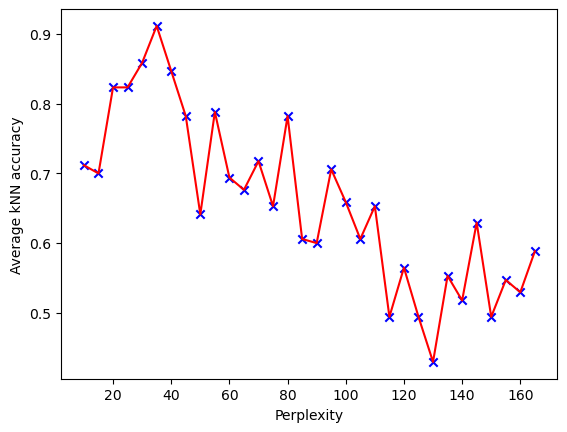

In [68]:
x = [init_dim_list[i] for i in range(32)]
plt.plot(x,acc_list,color='red')
plt.scatter(x,acc_list,marker = 'x',color = 'blue')
plt.ylabel('Average kNN accuracy')
plt.xlabel('Perplexity')
plt.show()

In [97]:
perp_list = [i*2+3 for i in range(40)]

Yout_list = []

In [98]:
for i in range(40):
    a = pca_var(X_train_multi, 35)
    Yout_list.append(multi_SNE_without_pca(a,  no_dims = 2,  perplexity = perp_list[i]))

m 3
baselineDim: 166
Computing pairwise distances...
Computing P-values for point 0 of 166...


C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 20.252641
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 27.341741
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 3.133315
Iteration 10: error is 23.767885
Iteration 10: error is 22.923209
Iteration 10: error is 22.511337
Iteration 20: error is 22.319371
Iteration 20: error is 21.814190
Iteration 20: error is 21.230407
Iteration 30: error is 22.651230
Iteration 30: error is 22.324568
Iteration 30: error is 22.090954
Iteration 40: error is 23.041781
Iteration 40: error is 22.303813
Iteration 40: error is 22.254035
Iteration 50: error is 22.006828
Iteration 50: error is 21.967160
Iteration 50: error is 22.323685
Iteration 60: error is 22.637859
Iteration 60: error is 22.638307
Iteration 60: error is 22.018526
Iteration 70: error is 22.934968
Iteration 70: error is 22.688064
Iteration 70: error is 22.157125
Iteration 80: error is 22.688426
Iteration 80: error is 22.594004
Ite

Iteration 830: error is 2.620347
Iteration 830: error is 2.435887
Iteration 830: error is 2.649964
Iteration 840: error is 2.615873
Iteration 840: error is 2.430557
Iteration 840: error is 2.650757
Iteration 850: error is 2.608328
Iteration 850: error is 2.425066
Iteration 850: error is 2.653289
Iteration 860: error is 2.599400
Iteration 860: error is 2.420119
Iteration 860: error is 2.655456
Iteration 870: error is 2.590857
Iteration 870: error is 2.414697
Iteration 870: error is 2.655894
Iteration 880: error is 2.580283
Iteration 880: error is 2.408963
Iteration 880: error is 2.654027
Iteration 890: error is 2.566222
Iteration 890: error is 2.400465
Iteration 890: error is 2.654808
Iteration 900: error is 2.550676
Iteration 900: error is 2.390965
Iteration 900: error is 2.653895
Iteration 910: error is 2.535914
Iteration 910: error is 2.384004
Iteration 910: error is 2.649075
Iteration 920: error is 2.509181
Iteration 920: error is 2.370931
Iteration 920: error is 2.643409
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 23.501358
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 32.547330
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 3.625561
Iteration 10: error is 20.837071
Iteration 10: error is 20.916944
Iteration 10: error is 20.599946
Iteration 20: error is 21.167764
Iteration 20: error is 21.303207
Iteration 20: error is 20.921444
Iteration 30: error is 20.970179
Iteration 30: error is 21.172903
Iteration 30: error is 21.448755
Iteration 40: error is 20.282235
Iteration 40: error is 20.948059
Iteration 40: error is 20.624231
Iteration 50: error is 20.899475
Iteration 50: error is 20.915959
Iteration 50: error is 20.668339
Iteration 60: error is 20.273791
Iteration 60: error is 20.843399
Iteration 60: error is 20.511891
Iteration 70: error is 20.842044
Iteration 70: error is 21.147546
Iteration 70: error is 21.024041
Iteration 80: error is 21.678838
Iteration 80: error is 21.721217
Ite

Iteration 820: error is 2.285035
Iteration 820: error is 2.419183
Iteration 820: error is 2.449860
Iteration 830: error is 2.274343
Iteration 830: error is 2.404667
Iteration 830: error is 2.442557
Iteration 840: error is 2.263736
Iteration 840: error is 2.391381
Iteration 840: error is 2.442781
Iteration 850: error is 2.254770
Iteration 850: error is 2.383333
Iteration 850: error is 2.440915
Iteration 860: error is 2.244627
Iteration 860: error is 2.378203
Iteration 860: error is 2.438369
Iteration 870: error is 2.235453
Iteration 870: error is 2.373184
Iteration 870: error is 2.435030
Iteration 880: error is 2.225135
Iteration 880: error is 2.367326
Iteration 880: error is 2.432813
Iteration 890: error is 2.209814
Iteration 890: error is 2.358833
Iteration 890: error is 2.432473
Iteration 900: error is 2.191811
Iteration 900: error is 2.340865
Iteration 900: error is 2.432022
Iteration 910: error is 2.178146
Iteration 910: error is 2.321192
Iteration 910: error is 2.429367
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 25.385843
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 35.571608
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 3.938865
Iteration 10: error is 20.013058
Iteration 10: error is 19.985761
Iteration 10: error is 19.662729
Iteration 20: error is 21.066319
Iteration 20: error is 20.980229
Iteration 20: error is 20.251798
Iteration 30: error is 20.296917
Iteration 30: error is 20.363284
Iteration 30: error is 19.951165
Iteration 40: error is 20.666447
Iteration 40: error is 20.436011
Iteration 40: error is 20.279943
Iteration 50: error is 20.429999
Iteration 50: error is 20.365903
Iteration 50: error is 20.256115
Iteration 60: error is 19.664532
Iteration 60: error is 20.449312
Iteration 60: error is 19.659239
Iteration 70: error is 19.380355
Iteration 70: error is 19.775050
Iteration 70: error is 19.332503
Iteration 80: error is 19.439798
Iteration 80: error is 19.348071
Ite

Iteration 820: error is 2.250375
Iteration 820: error is 2.021732
Iteration 820: error is 2.496516
Iteration 830: error is 2.229180
Iteration 830: error is 1.998526
Iteration 830: error is 2.480505
Iteration 840: error is 2.198187
Iteration 840: error is 1.976687
Iteration 840: error is 2.456502
Iteration 850: error is 2.168891
Iteration 850: error is 1.968196
Iteration 850: error is 2.440034
Iteration 860: error is 2.133318
Iteration 860: error is 1.961139
Iteration 860: error is 2.413902
Iteration 870: error is 2.111477
Iteration 870: error is 1.949533
Iteration 870: error is 2.390495
Iteration 880: error is 2.088464
Iteration 880: error is 1.950999
Iteration 880: error is 2.363277
Iteration 890: error is 2.081942
Iteration 890: error is 1.934400
Iteration 890: error is 2.329630
Iteration 900: error is 2.084316
Iteration 900: error is 1.929218
Iteration 900: error is 2.319312
Iteration 910: error is 2.084120
Iteration 910: error is 1.906902
Iteration 910: error is 2.305585
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 26.764500
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 37.772663
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 4.173363
Iteration 10: error is 18.294908
Iteration 10: error is 18.409954
Iteration 10: error is 17.836863
Iteration 20: error is 18.362677
Iteration 20: error is 18.602070
Iteration 20: error is 18.455608
Iteration 30: error is 19.894725
Iteration 30: error is 19.489593
Iteration 30: error is 19.327007
Iteration 40: error is 20.052961
Iteration 40: error is 20.149204
Iteration 40: error is 20.002754
Iteration 50: error is 19.897098
Iteration 50: error is 19.879432
Iteration 50: error is 19.774346
Iteration 60: error is 19.961296
Iteration 60: error is 19.306984
Iteration 60: error is 19.767199
Iteration 70: error is 19.318068
Iteration 70: error is 19.119827
Iteration 70: error is 19.135864
Iteration 80: error is 19.210781
Iteration 80: error is 19.038511
Ite

Iteration 820: error is 1.869266
Iteration 820: error is 1.818984
Iteration 820: error is 2.094397
Iteration 830: error is 1.862838
Iteration 830: error is 1.804542
Iteration 830: error is 2.091344
Iteration 840: error is 1.966941
Iteration 840: error is 1.934225
Iteration 840: error is 2.145245
Iteration 850: error is 2.027725
Iteration 850: error is 2.003025
Iteration 850: error is 2.192879
Iteration 860: error is 2.022532
Iteration 860: error is 1.996170
Iteration 860: error is 2.193300
Iteration 870: error is 2.005622
Iteration 870: error is 1.988775
Iteration 870: error is 2.191319
Iteration 880: error is 1.998169
Iteration 880: error is 1.987705
Iteration 880: error is 2.182798
Iteration 890: error is 1.991377
Iteration 890: error is 1.986820
Iteration 890: error is 2.177996
Iteration 900: error is 1.983357
Iteration 900: error is 1.985220
Iteration 900: error is 2.171479
Iteration 910: error is 1.975197
Iteration 910: error is 1.983467
Iteration 910: error is 2.162420
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 27.880093
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 39.546682
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 4.365051
Iteration 10: error is 17.988622
Iteration 10: error is 17.568227
Iteration 10: error is 17.066140
Iteration 20: error is 18.792433
Iteration 20: error is 18.418544
Iteration 20: error is 18.665385
Iteration 30: error is 19.129084
Iteration 30: error is 18.532331
Iteration 30: error is 18.788949
Iteration 40: error is 18.922342
Iteration 40: error is 18.250384
Iteration 40: error is 18.895077
Iteration 50: error is 18.587753
Iteration 50: error is 18.345146
Iteration 50: error is 18.659981
Iteration 60: error is 19.845088
Iteration 60: error is 18.910606
Iteration 60: error is 19.396073
Iteration 70: error is 19.108370
Iteration 70: error is 18.706582
Iteration 70: error is 18.964070
Iteration 80: error is 20.051670
Iteration 80: error is 19.284359
Ite

Iteration 820: error is 2.030518
Iteration 820: error is 1.713092
Iteration 820: error is 2.080583
Iteration 830: error is 2.023116
Iteration 830: error is 1.711528
Iteration 830: error is 2.080982
Iteration 840: error is 2.016833
Iteration 840: error is 1.708501
Iteration 840: error is 2.082496
Iteration 850: error is 2.009597
Iteration 850: error is 1.705294
Iteration 850: error is 2.082389
Iteration 860: error is 2.000927
Iteration 860: error is 1.702702
Iteration 860: error is 2.078420
Iteration 870: error is 1.991331
Iteration 870: error is 1.698231
Iteration 870: error is 2.077578
Iteration 880: error is 1.980331
Iteration 880: error is 1.697763
Iteration 880: error is 2.076565
Iteration 890: error is 1.968432
Iteration 890: error is 1.701856
Iteration 890: error is 2.070033
Iteration 900: error is 1.956037
Iteration 900: error is 1.704604
Iteration 900: error is 2.067569
Iteration 910: error is 1.947020
Iteration 910: error is 1.707710
Iteration 910: error is 2.066702
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 28.833563
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 41.062839
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 4.530447
Iteration 10: error is 17.066499
Iteration 10: error is 16.547811
Iteration 10: error is 16.554950
Iteration 20: error is 18.513642
Iteration 20: error is 18.594930
Iteration 20: error is 18.061259
Iteration 30: error is 19.256717
Iteration 30: error is 18.640108
Iteration 30: error is 18.230330
Iteration 40: error is 18.894487
Iteration 40: error is 18.341727
Iteration 40: error is 18.386941
Iteration 50: error is 19.004144
Iteration 50: error is 18.646058
Iteration 50: error is 18.736442
Iteration 60: error is 19.143859
Iteration 60: error is 18.398716
Iteration 60: error is 18.764383
Iteration 70: error is 18.329013
Iteration 70: error is 18.245301
Iteration 70: error is 17.937020
Iteration 80: error is 18.363780
Iteration 80: error is 17.956578
Ite

Iteration 820: error is 2.116307
Iteration 820: error is 2.132627
Iteration 820: error is 2.301688
Iteration 830: error is 2.086924
Iteration 830: error is 2.095329
Iteration 830: error is 2.268502
Iteration 840: error is 2.065940
Iteration 840: error is 2.061385
Iteration 840: error is 2.241278
Iteration 850: error is 2.046714
Iteration 850: error is 2.025558
Iteration 850: error is 2.216022
Iteration 860: error is 2.032036
Iteration 860: error is 1.989778
Iteration 860: error is 2.199844
Iteration 870: error is 2.014417
Iteration 870: error is 1.960972
Iteration 870: error is 2.173631
Iteration 880: error is 2.004634
Iteration 880: error is 1.943181
Iteration 880: error is 2.155032
Iteration 890: error is 1.995929
Iteration 890: error is 1.920483
Iteration 890: error is 2.136116
Iteration 900: error is 1.991436
Iteration 900: error is 1.898708
Iteration 900: error is 2.126384
Iteration 910: error is 1.987553
Iteration 910: error is 1.877122
Iteration 910: error is 2.111792
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 29.677190
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 42.406339
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 4.678170
Iteration 10: error is 16.119482
Iteration 10: error is 16.264874
Iteration 10: error is 16.141936
Iteration 20: error is 16.720639
Iteration 20: error is 16.804402
Iteration 20: error is 16.384240
Iteration 30: error is 18.018933
Iteration 30: error is 18.106859
Iteration 30: error is 17.304752
Iteration 40: error is 18.511639
Iteration 40: error is 18.544135
Iteration 40: error is 17.952716
Iteration 50: error is 18.307044
Iteration 50: error is 17.891968
Iteration 50: error is 17.371349
Iteration 60: error is 18.435931
Iteration 60: error is 18.195766
Iteration 60: error is 17.651290
Iteration 70: error is 18.795164
Iteration 70: error is 18.176920
Iteration 70: error is 17.044289
Iteration 80: error is 19.241247
Iteration 80: error is 18.640251
Ite

Iteration 820: error is 1.667453
Iteration 820: error is 1.752234
Iteration 820: error is 1.863904
Iteration 830: error is 1.666849
Iteration 830: error is 1.748087
Iteration 830: error is 1.859208
Iteration 840: error is 1.665306
Iteration 840: error is 1.744718
Iteration 840: error is 1.853783
Iteration 850: error is 1.661849
Iteration 850: error is 1.738676
Iteration 850: error is 1.847589
Iteration 860: error is 1.649319
Iteration 860: error is 1.726360
Iteration 860: error is 1.831551
Iteration 870: error is 1.656532
Iteration 870: error is 1.726737
Iteration 870: error is 1.835105
Iteration 880: error is 1.655130
Iteration 880: error is 1.707125
Iteration 880: error is 1.826852
Iteration 890: error is 1.641848
Iteration 890: error is 1.697729
Iteration 890: error is 1.813260
Iteration 900: error is 1.630104
Iteration 900: error is 1.691817
Iteration 900: error is 1.804838
Iteration 910: error is 1.613625
Iteration 910: error is 1.689995
Iteration 910: error is 1.793180
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 30.441907
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 43.626747
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 4.813270
Iteration 10: error is 15.724183
Iteration 10: error is 15.875075
Iteration 10: error is 15.553841
Iteration 20: error is 18.113530
Iteration 20: error is 17.310529
Iteration 20: error is 16.975480
Iteration 30: error is 19.040772
Iteration 30: error is 18.236406
Iteration 30: error is 18.297156
Iteration 40: error is 18.632494
Iteration 40: error is 17.400165
Iteration 40: error is 17.462784
Iteration 50: error is 18.009420
Iteration 50: error is 16.721798
Iteration 50: error is 16.595751
Iteration 60: error is 17.448726
Iteration 60: error is 17.195565
Iteration 60: error is 16.588833
Iteration 70: error is 17.937034
Iteration 70: error is 17.563304
Iteration 70: error is 17.360162
Iteration 80: error is 17.869093
Iteration 80: error is 17.715024
Ite

Iteration 820: error is 1.678711
Iteration 820: error is 1.441154
Iteration 820: error is 1.737109
Iteration 830: error is 1.674431
Iteration 830: error is 1.443012
Iteration 830: error is 1.735544
Iteration 840: error is 1.671851
Iteration 840: error is 1.444490
Iteration 840: error is 1.732662
Iteration 850: error is 1.668353
Iteration 850: error is 1.445492
Iteration 850: error is 1.728916
Iteration 860: error is 1.661798
Iteration 860: error is 1.446275
Iteration 860: error is 1.725848
Iteration 870: error is 1.656072
Iteration 870: error is 1.440547
Iteration 870: error is 1.718586
Iteration 880: error is 1.649963
Iteration 880: error is 1.424284
Iteration 880: error is 1.699632
Iteration 890: error is 1.647896
Iteration 890: error is 1.415228
Iteration 890: error is 1.688303
Iteration 900: error is 1.647965
Iteration 900: error is 1.412964
Iteration 900: error is 1.682462
Iteration 910: error is 1.649256
Iteration 910: error is 1.414928
Iteration 910: error is 1.673587
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 31.147682
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 44.755628
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 4.938980
Iteration 10: error is 16.301025
Iteration 10: error is 16.038430
Iteration 10: error is 15.656406
Iteration 20: error is 17.162745
Iteration 20: error is 16.777420
Iteration 20: error is 16.828878
Iteration 30: error is 17.069511
Iteration 30: error is 17.035319
Iteration 30: error is 16.756377
Iteration 40: error is 18.137136
Iteration 40: error is 17.647125
Iteration 40: error is 17.064951
Iteration 50: error is 18.236822
Iteration 50: error is 18.057150
Iteration 50: error is 17.093903
Iteration 60: error is 18.433900
Iteration 60: error is 17.838938
Iteration 60: error is 17.252363
Iteration 70: error is 18.400096
Iteration 70: error is 17.642639
Iteration 70: error is 17.718158
Iteration 80: error is 17.898428
Iteration 80: error is 17.670823
Ite

Iteration 820: error is 1.361841
Iteration 820: error is 1.171535
Iteration 820: error is 1.443545
Iteration 830: error is 1.361849
Iteration 830: error is 1.171533
Iteration 830: error is 1.443540
Iteration 840: error is 1.361841
Iteration 840: error is 1.171543
Iteration 840: error is 1.443537
Iteration 850: error is 1.361843
Iteration 850: error is 1.171543
Iteration 850: error is 1.443536
Iteration 860: error is 1.361841
Iteration 860: error is 1.171545
Iteration 860: error is 1.443535
Iteration 870: error is 1.361843
Iteration 870: error is 1.171544
Iteration 870: error is 1.443534
Iteration 880: error is 1.361844
Iteration 880: error is 1.171544
Iteration 880: error is 1.443534
Iteration 890: error is 1.361844
Iteration 890: error is 1.171543
Iteration 890: error is 1.443534
Iteration 900: error is 1.361844
Iteration 900: error is 1.171543
Iteration 900: error is 1.443534
Iteration 910: error is 1.361844
Iteration 910: error is 1.171543
Iteration 910: error is 1.443534
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 31.808185
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 45.814353
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.057513
Iteration 10: error is 15.136399
Iteration 10: error is 15.380102
Iteration 10: error is 14.969966
Iteration 20: error is 16.088299
Iteration 20: error is 16.126046
Iteration 20: error is 15.743278
Iteration 30: error is 16.621500
Iteration 30: error is 16.743940
Iteration 30: error is 16.206837
Iteration 40: error is 17.520477
Iteration 40: error is 16.951612
Iteration 40: error is 17.206513
Iteration 50: error is 17.231197
Iteration 50: error is 16.774990
Iteration 50: error is 16.375028
Iteration 60: error is 17.257761
Iteration 60: error is 16.819740
Iteration 60: error is 16.825580
Iteration 70: error is 17.092734
Iteration 70: error is 16.715543
Iteration 70: error is 16.359498
Iteration 80: error is 16.980113
Iteration 80: error is 16.657054
Ite

Iteration 830: error is 1.570972
Iteration 830: error is 1.600138
Iteration 830: error is 1.702782
Iteration 840: error is 1.569549
Iteration 840: error is 1.598031
Iteration 840: error is 1.702039
Iteration 850: error is 1.569429
Iteration 850: error is 1.595783
Iteration 850: error is 1.700859
Iteration 860: error is 1.569930
Iteration 860: error is 1.593024
Iteration 860: error is 1.700253
Iteration 870: error is 1.569723
Iteration 870: error is 1.590237
Iteration 870: error is 1.700472
Iteration 880: error is 1.569305
Iteration 880: error is 1.586790
Iteration 880: error is 1.700702
Iteration 890: error is 1.568025
Iteration 890: error is 1.581802
Iteration 890: error is 1.699966
Iteration 900: error is 1.564104
Iteration 900: error is 1.580005
Iteration 900: error is 1.695918
Iteration 910: error is 1.557639
Iteration 910: error is 1.579430
Iteration 910: error is 1.694358
Iteration 920: error is 1.551290
Iteration 920: error is 1.578818
Iteration 920: error is 1.692189
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.433200
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 46.818157
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.170450
Iteration 10: error is 14.895298
Iteration 10: error is 14.689154
Iteration 10: error is 14.693448
Iteration 20: error is 16.667849
Iteration 20: error is 16.164598
Iteration 20: error is 15.659412
Iteration 30: error is 17.090327
Iteration 30: error is 16.881563
Iteration 30: error is 16.459928
Iteration 40: error is 16.518286
Iteration 40: error is 16.561356
Iteration 40: error is 16.414061
Iteration 50: error is 18.268437
Iteration 50: error is 17.632483
Iteration 50: error is 17.456388
Iteration 60: error is 18.149804
Iteration 60: error is 17.301375
Iteration 60: error is 16.742015
Iteration 70: error is 17.121890
Iteration 70: error is 16.685970
Iteration 70: error is 16.901010
Iteration 80: error is 16.477114
Iteration 80: error is 16.113270
Ite

Iteration 830: error is 1.430114
Iteration 830: error is 1.412649
Iteration 830: error is 1.474479
Iteration 840: error is 1.425635
Iteration 840: error is 1.410331
Iteration 840: error is 1.475236
Iteration 850: error is 1.418710
Iteration 850: error is 1.409941
Iteration 850: error is 1.476146
Iteration 860: error is 1.415508
Iteration 860: error is 1.408622
Iteration 860: error is 1.475603
Iteration 870: error is 1.411982
Iteration 870: error is 1.406389
Iteration 870: error is 1.478172
Iteration 880: error is 1.407607
Iteration 880: error is 1.396820
Iteration 880: error is 1.481253
Iteration 890: error is 1.397059
Iteration 890: error is 1.384710
Iteration 890: error is 1.487534
Iteration 900: error is 1.391493
Iteration 900: error is 1.375151
Iteration 900: error is 1.490959
Iteration 910: error is 1.389076
Iteration 910: error is 1.370333
Iteration 910: error is 1.489101
Iteration 920: error is 1.385958
Iteration 920: error is 1.362717
Iteration 920: error is 1.484321
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 33.029972
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 47.778301
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.278973
Iteration 10: error is 14.254111
Iteration 10: error is 14.025593
Iteration 10: error is 13.761386
Iteration 20: error is 14.911378
Iteration 20: error is 14.704640
Iteration 20: error is 14.158099
Iteration 30: error is 15.980289
Iteration 30: error is 15.480645
Iteration 30: error is 15.167031
Iteration 40: error is 16.481218
Iteration 40: error is 15.487902
Iteration 40: error is 15.309543
Iteration 50: error is 16.439757
Iteration 50: error is 15.663127
Iteration 50: error is 15.490984
Iteration 60: error is 16.895302
Iteration 60: error is 16.386784
Iteration 60: error is 15.930920
Iteration 70: error is 16.821474
Iteration 70: error is 16.193028
Iteration 70: error is 16.083256
Iteration 80: error is 16.155748
Iteration 80: error is 16.142391
Ite

Iteration 820: error is 1.441393
Iteration 820: error is 1.456978
Iteration 820: error is 1.456455
Iteration 830: error is 1.439414
Iteration 830: error is 1.453954
Iteration 830: error is 1.457347
Iteration 840: error is 1.439349
Iteration 840: error is 1.451207
Iteration 840: error is 1.457678
Iteration 850: error is 1.439088
Iteration 850: error is 1.450174
Iteration 850: error is 1.457351
Iteration 860: error is 1.438140
Iteration 860: error is 1.447427
Iteration 860: error is 1.457094
Iteration 870: error is 1.439007
Iteration 870: error is 1.447030
Iteration 870: error is 1.452892
Iteration 880: error is 1.440409
Iteration 880: error is 1.445961
Iteration 880: error is 1.447248
Iteration 890: error is 1.438509
Iteration 890: error is 1.443440
Iteration 890: error is 1.444545
Iteration 900: error is 1.439160
Iteration 900: error is 1.442387
Iteration 900: error is 1.442505
Iteration 910: error is 1.438894
Iteration 910: error is 1.442413
Iteration 910: error is 1.440411
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 33.604037
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 48.703323
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.383985
Iteration 10: error is 14.518306
Iteration 10: error is 14.289453
Iteration 10: error is 13.913025
Iteration 20: error is 14.075358
Iteration 20: error is 14.110489
Iteration 20: error is 13.701434
Iteration 30: error is 15.317683
Iteration 30: error is 15.178543
Iteration 30: error is 14.766821
Iteration 40: error is 15.685805
Iteration 40: error is 15.746858
Iteration 40: error is 15.801892
Iteration 50: error is 17.289826
Iteration 50: error is 16.755471
Iteration 50: error is 16.771283
Iteration 60: error is 16.927894
Iteration 60: error is 16.641257
Iteration 60: error is 16.450078
Iteration 70: error is 16.462148
Iteration 70: error is 16.172811
Iteration 70: error is 15.929796
Iteration 80: error is 16.514573
Iteration 80: error is 16.242266
Ite

Iteration 820: error is 1.354965
Iteration 820: error is 1.166918
Iteration 820: error is 1.334699
Iteration 830: error is 1.290382
Iteration 830: error is 1.139916
Iteration 830: error is 1.258439
Iteration 840: error is 1.304191
Iteration 840: error is 1.023423
Iteration 840: error is 1.247919
Iteration 850: error is 1.301383
Iteration 850: error is 1.017669
Iteration 850: error is 1.204612
Iteration 860: error is 1.275316
Iteration 860: error is 1.031659
Iteration 860: error is 1.195381
Iteration 870: error is 1.264492
Iteration 870: error is 1.017347
Iteration 870: error is 1.197595
Iteration 880: error is 1.247169
Iteration 880: error is 1.023314
Iteration 880: error is 1.192853
Iteration 890: error is 1.247908
Iteration 890: error is 1.021368
Iteration 890: error is 1.189923
Iteration 900: error is 1.242982
Iteration 900: error is 1.023620
Iteration 900: error is 1.191247
Iteration 910: error is 1.243066
Iteration 910: error is 1.024826
Iteration 910: error is 1.189707
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 34.159717
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 49.599972
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.486205
Iteration 10: error is 14.253953
Iteration 10: error is 14.095249
Iteration 10: error is 13.935979
Iteration 20: error is 14.635195
Iteration 20: error is 14.782223
Iteration 20: error is 14.404288
Iteration 30: error is 15.806960
Iteration 30: error is 15.365272
Iteration 30: error is 15.238507
Iteration 40: error is 16.048801
Iteration 40: error is 15.967339
Iteration 40: error is 16.005611
Iteration 50: error is 15.760034
Iteration 50: error is 15.736087
Iteration 50: error is 15.798637
Iteration 60: error is 16.430096
Iteration 60: error is 16.080773
Iteration 60: error is 15.525806
Iteration 70: error is 16.258187
Iteration 70: error is 15.938703
Iteration 70: error is 15.135844
Iteration 80: error is 16.373816
Iteration 80: error is 15.654332
Ite

Iteration 830: error is 1.427206
Iteration 830: error is 1.350450
Iteration 830: error is 1.385224
Iteration 840: error is 1.426745
Iteration 840: error is 1.348023
Iteration 840: error is 1.382674
Iteration 850: error is 1.422983
Iteration 850: error is 1.345545
Iteration 850: error is 1.381629
Iteration 860: error is 1.418409
Iteration 860: error is 1.343262
Iteration 860: error is 1.382040
Iteration 870: error is 1.413901
Iteration 870: error is 1.339716
Iteration 870: error is 1.380939
Iteration 880: error is 1.411634
Iteration 880: error is 1.335515
Iteration 880: error is 1.380516
Iteration 890: error is 1.410924
Iteration 890: error is 1.333563
Iteration 890: error is 1.379217
Iteration 900: error is 1.409383
Iteration 900: error is 1.331865
Iteration 900: error is 1.378242
Iteration 910: error is 1.405066
Iteration 910: error is 1.328189
Iteration 910: error is 1.374967
Iteration 920: error is 1.403798
Iteration 920: error is 1.324175
Iteration 920: error is 1.370890
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 34.700471
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 50.473595
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.586211
Iteration 10: error is 13.485853
Iteration 10: error is 13.569284
Iteration 10: error is 13.413610
Iteration 20: error is 14.090599
Iteration 20: error is 14.092432
Iteration 20: error is 14.026148
Iteration 30: error is 16.393037
Iteration 30: error is 16.366171
Iteration 30: error is 16.263586
Iteration 40: error is 16.795415
Iteration 40: error is 17.048161
Iteration 40: error is 16.746262
Iteration 50: error is 18.192326
Iteration 50: error is 18.004183
Iteration 50: error is 18.099468
Iteration 60: error is 16.875414
Iteration 60: error is 16.895364
Iteration 60: error is 16.573391
Iteration 70: error is 17.386244
Iteration 70: error is 16.844848
Iteration 70: error is 16.788252
Iteration 80: error is 17.494753
Iteration 80: error is 16.798225
Ite

Iteration 830: error is 1.430298
Iteration 830: error is 1.277830
Iteration 830: error is 1.402771
Iteration 840: error is 1.426404
Iteration 840: error is 1.275504
Iteration 840: error is 1.403640
Iteration 850: error is 1.421444
Iteration 850: error is 1.269551
Iteration 850: error is 1.403091
Iteration 860: error is 1.417113
Iteration 860: error is 1.259607
Iteration 860: error is 1.403681
Iteration 870: error is 1.407423
Iteration 870: error is 1.258430
Iteration 870: error is 1.402390
Iteration 880: error is 1.402578
Iteration 880: error is 1.258214
Iteration 880: error is 1.396868
Iteration 890: error is 1.402126
Iteration 890: error is 1.256630
Iteration 890: error is 1.392254
Iteration 900: error is 1.400210
Iteration 900: error is 1.254371
Iteration 900: error is 1.391578
Iteration 910: error is 1.398361
Iteration 910: error is 1.253087
Iteration 910: error is 1.389420
Iteration 920: error is 1.396782
Iteration 920: error is 1.252059
Iteration 920: error is 1.388194
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 35.229132
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 51.328649
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.684480
Iteration 10: error is 13.384558
Iteration 10: error is 13.223453
Iteration 10: error is 12.884942
Iteration 20: error is 14.208969
Iteration 20: error is 14.305016
Iteration 20: error is 14.316966
Iteration 30: error is 16.208839
Iteration 30: error is 16.356513
Iteration 30: error is 16.117298
Iteration 40: error is 16.450259
Iteration 40: error is 15.591528
Iteration 40: error is 15.977162
Iteration 50: error is 16.330774
Iteration 50: error is 16.125640
Iteration 50: error is 16.203438
Iteration 60: error is 16.945911
Iteration 60: error is 16.078432
Iteration 60: error is 16.795916
Iteration 70: error is 17.387626
Iteration 70: error is 16.530219
Iteration 70: error is 16.770526
Iteration 80: error is 17.911853
Iteration 80: error is 16.726601
Ite

Iteration 820: error is 1.367659
Iteration 820: error is 1.530537
Iteration 820: error is 1.431500
Iteration 830: error is 1.363281
Iteration 830: error is 1.521893
Iteration 830: error is 1.427008
Iteration 840: error is 1.361582
Iteration 840: error is 1.512677
Iteration 840: error is 1.424806
Iteration 850: error is 1.359558
Iteration 850: error is 1.505201
Iteration 850: error is 1.425239
Iteration 860: error is 1.355566
Iteration 860: error is 1.499266
Iteration 860: error is 1.424732
Iteration 870: error is 1.352287
Iteration 870: error is 1.490833
Iteration 870: error is 1.423384
Iteration 880: error is 1.349085
Iteration 880: error is 1.485428
Iteration 880: error is 1.423004
Iteration 890: error is 1.347837
Iteration 890: error is 1.482777
Iteration 890: error is 1.421073
Iteration 900: error is 1.347281
Iteration 900: error is 1.477414
Iteration 900: error is 1.419867
Iteration 910: error is 1.346598
Iteration 910: error is 1.468827
Iteration 910: error is 1.420176
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 35.748040
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 52.168790
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.781420
Iteration 10: error is 12.546757
Iteration 10: error is 12.894268
Iteration 10: error is 12.332515
Iteration 20: error is 14.151981
Iteration 20: error is 14.208590
Iteration 20: error is 13.691179
Iteration 30: error is 15.406459
Iteration 30: error is 14.715425
Iteration 30: error is 14.858292
Iteration 40: error is 16.423757
Iteration 40: error is 15.515697
Iteration 40: error is 15.364265
Iteration 50: error is 15.945418
Iteration 50: error is 15.121499
Iteration 50: error is 15.207221
Iteration 60: error is 16.416688
Iteration 60: error is 15.542972
Iteration 60: error is 15.957366
Iteration 70: error is 16.682569
Iteration 70: error is 15.710551
Iteration 70: error is 16.168961
Iteration 80: error is 16.827590
Iteration 80: error is 15.525918
Ite

Iteration 820: error is 0.961815
Iteration 820: error is 0.957076
Iteration 820: error is 1.017376
Iteration 830: error is 0.961816
Iteration 830: error is 0.957075
Iteration 830: error is 1.017377
Iteration 840: error is 0.961815
Iteration 840: error is 0.957076
Iteration 840: error is 1.017377
Iteration 850: error is 0.961815
Iteration 850: error is 0.957076
Iteration 850: error is 1.017377
Iteration 860: error is 0.961815
Iteration 860: error is 0.957076
Iteration 860: error is 1.017376
Iteration 870: error is 0.961815
Iteration 870: error is 0.957076
Iteration 870: error is 1.017377
Iteration 880: error is 0.961815
Iteration 880: error is 0.957076
Iteration 880: error is 1.017377
Iteration 890: error is 0.961815
Iteration 890: error is 0.957076
Iteration 890: error is 1.017377
Iteration 900: error is 0.961815
Iteration 900: error is 0.957076
Iteration 900: error is 1.017377
Iteration 910: error is 0.961815
Iteration 910: error is 0.957076
Iteration 910: error is 1.017377
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 36.259183
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 52.997147
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.877379
Iteration 10: error is 12.328000
Iteration 10: error is 12.678183
Iteration 10: error is 12.282142
Iteration 20: error is 12.653119
Iteration 20: error is 12.820492
Iteration 20: error is 12.992206
Iteration 30: error is 14.915066
Iteration 30: error is 14.834758
Iteration 30: error is 14.063389
Iteration 40: error is 15.213840
Iteration 40: error is 15.027253
Iteration 40: error is 14.765888
Iteration 50: error is 15.490142
Iteration 50: error is 15.037716
Iteration 50: error is 14.739949
Iteration 60: error is 15.976371
Iteration 60: error is 15.741744
Iteration 60: error is 15.397793
Iteration 70: error is 16.137655
Iteration 70: error is 15.882950
Iteration 70: error is 15.640960
Iteration 80: error is 16.936213
Iteration 80: error is 17.047243
Ite

Iteration 830: error is 1.323493
Iteration 830: error is 1.381178
Iteration 830: error is 1.347649
Iteration 840: error is 1.323243
Iteration 840: error is 1.376510
Iteration 840: error is 1.346647
Iteration 850: error is 1.325983
Iteration 850: error is 1.371621
Iteration 850: error is 1.345365
Iteration 860: error is 1.324794
Iteration 860: error is 1.369853
Iteration 860: error is 1.346139
Iteration 870: error is 1.324532
Iteration 870: error is 1.367747
Iteration 870: error is 1.346442
Iteration 880: error is 1.324659
Iteration 880: error is 1.364867
Iteration 880: error is 1.346995
Iteration 890: error is 1.324546
Iteration 890: error is 1.362815
Iteration 890: error is 1.346898
Iteration 900: error is 1.324346
Iteration 900: error is 1.361667
Iteration 900: error is 1.346012
Iteration 910: error is 1.323630
Iteration 910: error is 1.361366
Iteration 910: error is 1.345564
Iteration 920: error is 1.323388
Iteration 920: error is 1.361315
Iteration 920: error is 1.344858
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 36.764275
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 53.816463
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 5.972662
Iteration 10: error is 12.834545
Iteration 10: error is 12.498205
Iteration 10: error is 12.064948
Iteration 20: error is 13.284676
Iteration 20: error is 12.988734
Iteration 20: error is 12.827228
Iteration 30: error is 15.924907
Iteration 30: error is 15.107088
Iteration 30: error is 15.301077
Iteration 40: error is 16.136935
Iteration 40: error is 15.039883
Iteration 40: error is 14.913882
Iteration 50: error is 16.515267
Iteration 50: error is 15.464169
Iteration 50: error is 15.431042
Iteration 60: error is 16.739484
Iteration 60: error is 15.646631
Iteration 60: error is 15.341564
Iteration 70: error is 16.390606
Iteration 70: error is 15.330092
Iteration 70: error is 15.250789
Iteration 80: error is 17.636921
Iteration 80: error is 16.261369
Ite

Iteration 820: error is 1.286653
Iteration 820: error is 1.288296
Iteration 820: error is 1.324865
Iteration 830: error is 1.288759
Iteration 830: error is 1.281840
Iteration 830: error is 1.323637
Iteration 840: error is 1.289223
Iteration 840: error is 1.277331
Iteration 840: error is 1.321588
Iteration 850: error is 1.286551
Iteration 850: error is 1.277322
Iteration 850: error is 1.320367
Iteration 860: error is 1.283032
Iteration 860: error is 1.276310
Iteration 860: error is 1.316956
Iteration 870: error is 1.278995
Iteration 870: error is 1.273842
Iteration 870: error is 1.313788
Iteration 880: error is 1.274653
Iteration 880: error is 1.272787
Iteration 880: error is 1.312700
Iteration 890: error is 1.272836
Iteration 890: error is 1.270937
Iteration 890: error is 1.312242
Iteration 900: error is 1.271403
Iteration 900: error is 1.269525
Iteration 900: error is 1.311527
Iteration 910: error is 1.268483
Iteration 910: error is 1.268667
Iteration 910: error is 1.311189
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 37.264790
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 54.629107
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.067540
Iteration 10: error is 13.055471
Iteration 10: error is 13.115180
Iteration 10: error is 12.704991
Iteration 20: error is 13.714953
Iteration 20: error is 13.511072
Iteration 20: error is 13.136604
Iteration 30: error is 15.859865
Iteration 30: error is 14.748126
Iteration 30: error is 14.729253
Iteration 40: error is 15.850219
Iteration 40: error is 15.276038
Iteration 40: error is 15.029676
Iteration 50: error is 16.295850
Iteration 50: error is 15.657617
Iteration 50: error is 15.139277
Iteration 60: error is 16.934241
Iteration 60: error is 16.174112
Iteration 60: error is 15.783336
Iteration 70: error is 17.609222
Iteration 70: error is 16.919223
Iteration 70: error is 16.447360
Iteration 80: error is 17.123580
Iteration 80: error is 16.068549
Ite

Iteration 820: error is 1.335508
Iteration 820: error is 1.320934
Iteration 820: error is 1.400637
Iteration 830: error is 1.331436
Iteration 830: error is 1.319521
Iteration 830: error is 1.399682
Iteration 840: error is 1.325980
Iteration 840: error is 1.316944
Iteration 840: error is 1.398207
Iteration 850: error is 1.320110
Iteration 850: error is 1.311951
Iteration 850: error is 1.396575
Iteration 860: error is 1.313739
Iteration 860: error is 1.306195
Iteration 860: error is 1.393855
Iteration 870: error is 1.306658
Iteration 870: error is 1.301737
Iteration 870: error is 1.390174
Iteration 880: error is 1.300878
Iteration 880: error is 1.296854
Iteration 880: error is 1.387362
Iteration 890: error is 1.296415
Iteration 890: error is 1.293093
Iteration 890: error is 1.383427
Iteration 900: error is 1.291286
Iteration 900: error is 1.289163
Iteration 900: error is 1.379062
Iteration 910: error is 1.286366
Iteration 910: error is 1.285573
Iteration 910: error is 1.373539
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 37.762042
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 55.437203
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.162261
Iteration 10: error is 12.598446
Iteration 10: error is 12.300209
Iteration 10: error is 12.112167
Iteration 20: error is 14.308663
Iteration 20: error is 13.686896
Iteration 20: error is 13.708577
Iteration 30: error is 15.816167
Iteration 30: error is 15.139320
Iteration 30: error is 15.041599
Iteration 40: error is 16.226886
Iteration 40: error is 15.652022
Iteration 40: error is 15.346210
Iteration 50: error is 16.931010
Iteration 50: error is 16.279992
Iteration 50: error is 15.918197
Iteration 60: error is 16.425045
Iteration 60: error is 15.818501
Iteration 60: error is 15.375608
Iteration 70: error is 16.405903
Iteration 70: error is 15.890212
Iteration 70: error is 15.734877
Iteration 80: error is 16.935641
Iteration 80: error is 16.235029
Ite

Iteration 830: error is 0.828778
Iteration 830: error is 0.863958
Iteration 830: error is 0.834329
Iteration 840: error is 0.825272
Iteration 840: error is 0.866271
Iteration 840: error is 0.831691
Iteration 850: error is 0.827064
Iteration 850: error is 0.864607
Iteration 850: error is 0.830395
Iteration 860: error is 0.825536
Iteration 860: error is 0.865410
Iteration 860: error is 0.830875
Iteration 870: error is 0.825507
Iteration 870: error is 0.865124
Iteration 870: error is 0.830273
Iteration 880: error is 0.824849
Iteration 880: error is 0.865213
Iteration 880: error is 0.830587
Iteration 890: error is 0.825419
Iteration 890: error is 0.865177
Iteration 890: error is 0.829901
Iteration 900: error is 0.825075
Iteration 900: error is 0.865110
Iteration 900: error is 0.830280
Iteration 910: error is 0.825157
Iteration 910: error is 0.865117
Iteration 910: error is 0.830159
Iteration 920: error is 0.825296
Iteration 920: error is 0.864970
Iteration 920: error is 0.830157
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.257219
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 56.242691
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.257045
Iteration 10: error is 12.855872
Iteration 10: error is 12.938417
Iteration 10: error is 12.740936
Iteration 20: error is 13.494389
Iteration 20: error is 13.241614
Iteration 20: error is 12.631577
Iteration 30: error is 15.383335
Iteration 30: error is 15.033604
Iteration 30: error is 14.349831
Iteration 40: error is 14.489827
Iteration 40: error is 14.322355
Iteration 40: error is 13.702151
Iteration 50: error is 15.744903
Iteration 50: error is 14.874002
Iteration 50: error is 14.412685
Iteration 60: error is 16.532238
Iteration 60: error is 15.801561
Iteration 60: error is 15.351173
Iteration 70: error is 15.969838
Iteration 70: error is 15.183116
Iteration 70: error is 14.981682
Iteration 80: error is 16.246970
Iteration 80: error is 15.088114
Ite

Iteration 820: error is 0.811728
Iteration 820: error is 0.823793
Iteration 820: error is 0.798016
Iteration 830: error is 0.811644
Iteration 830: error is 0.824472
Iteration 830: error is 0.797172
Iteration 840: error is 0.811466
Iteration 840: error is 0.823889
Iteration 840: error is 0.797816
Iteration 850: error is 0.811473
Iteration 850: error is 0.823880
Iteration 850: error is 0.797790
Iteration 860: error is 0.811442
Iteration 860: error is 0.824060
Iteration 860: error is 0.797626
Iteration 870: error is 0.811536
Iteration 870: error is 0.823877
Iteration 870: error is 0.797706
Iteration 880: error is 0.811459
Iteration 880: error is 0.823977
Iteration 880: error is 0.797680
Iteration 890: error is 0.811493
Iteration 890: error is 0.823920
Iteration 890: error is 0.797700
Iteration 900: error is 0.811482
Iteration 900: error is 0.823931
Iteration 900: error is 0.797698
Iteration 910: error is 0.811496
Iteration 910: error is 0.823935
Iteration 910: error is 0.797681
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 38.751378
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 57.047308
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.352101
Iteration 10: error is 12.012271
Iteration 10: error is 12.000320
Iteration 10: error is 11.702088
Iteration 20: error is 12.087794
Iteration 20: error is 12.006854
Iteration 20: error is 12.061597
Iteration 30: error is 13.759233
Iteration 30: error is 13.674474
Iteration 30: error is 13.733015
Iteration 40: error is 14.462957
Iteration 40: error is 14.410064
Iteration 40: error is 14.120079
Iteration 50: error is 14.525197
Iteration 50: error is 14.436913
Iteration 50: error is 14.185754
Iteration 60: error is 14.901077
Iteration 60: error is 14.458430
Iteration 60: error is 14.137806
Iteration 70: error is 14.425681
Iteration 70: error is 14.151584
Iteration 70: error is 13.783579
Iteration 80: error is 14.242154
Iteration 80: error is 14.534264
Ite

Iteration 830: error is 0.792825
Iteration 830: error is 0.769559
Iteration 830: error is 0.763173
Iteration 840: error is 0.792825
Iteration 840: error is 0.769558
Iteration 840: error is 0.763173
Iteration 850: error is 0.792825
Iteration 850: error is 0.769559
Iteration 850: error is 0.763173
Iteration 860: error is 0.792825
Iteration 860: error is 0.769559
Iteration 860: error is 0.763173
Iteration 870: error is 0.792825
Iteration 870: error is 0.769558
Iteration 870: error is 0.763173
Iteration 880: error is 0.792825
Iteration 880: error is 0.769559
Iteration 880: error is 0.763173
Iteration 890: error is 0.792825
Iteration 890: error is 0.769559
Iteration 890: error is 0.763173
Iteration 900: error is 0.792825
Iteration 900: error is 0.769559
Iteration 900: error is 0.763173
Iteration 910: error is 0.792825
Iteration 910: error is 0.769559
Iteration 910: error is 0.763173
Iteration 920: error is 0.792825
Iteration 920: error is 0.769559
Iteration 920: error is 0.763173
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.245484
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 57.852754
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.447620
Iteration 10: error is 12.352085
Iteration 10: error is 12.058468
Iteration 10: error is 12.217443
Iteration 20: error is 13.156305
Iteration 20: error is 12.567391
Iteration 20: error is 12.813324
Iteration 30: error is 15.000106
Iteration 30: error is 14.588231
Iteration 30: error is 14.782329
Iteration 40: error is 14.933390
Iteration 40: error is 14.242804
Iteration 40: error is 14.469869
Iteration 50: error is 14.963879
Iteration 50: error is 14.435090
Iteration 50: error is 14.691096
Iteration 60: error is 14.924482
Iteration 60: error is 14.193991
Iteration 60: error is 14.485245
Iteration 70: error is 14.450882
Iteration 70: error is 13.494240
Iteration 70: error is 13.850429
Iteration 80: error is 15.303926
Iteration 80: error is 14.482382
Ite

Iteration 820: error is 0.764368
Iteration 820: error is 0.704228
Iteration 820: error is 0.760749
Iteration 830: error is 0.764368
Iteration 830: error is 0.704228
Iteration 830: error is 0.760749
Iteration 840: error is 0.764368
Iteration 840: error is 0.704228
Iteration 840: error is 0.760749
Iteration 850: error is 0.764368
Iteration 850: error is 0.704228
Iteration 850: error is 0.760749
Iteration 860: error is 0.764368
Iteration 860: error is 0.704228
Iteration 860: error is 0.760749
Iteration 870: error is 0.764368
Iteration 870: error is 0.704228
Iteration 870: error is 0.760749
Iteration 880: error is 0.764368
Iteration 880: error is 0.704228
Iteration 880: error is 0.760749
Iteration 890: error is 0.764368
Iteration 890: error is 0.704228
Iteration 890: error is 0.760749
Iteration 900: error is 0.764368
Iteration 900: error is 0.704228
Iteration 900: error is 0.760749
Iteration 910: error is 0.764368
Iteration 910: error is 0.704228
Iteration 910: error is 0.760749
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 39.740487
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 58.660543
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.543794
Iteration 10: error is 12.054819
Iteration 10: error is 12.253633
Iteration 10: error is 11.714108
Iteration 20: error is 12.699559
Iteration 20: error is 12.612065
Iteration 20: error is 12.363584
Iteration 30: error is 14.581537
Iteration 30: error is 14.216057
Iteration 30: error is 14.324516
Iteration 40: error is 15.297931
Iteration 40: error is 14.335928
Iteration 40: error is 14.449726
Iteration 50: error is 15.904082
Iteration 50: error is 14.518581
Iteration 50: error is 14.961154
Iteration 60: error is 16.275361
Iteration 60: error is 14.903235
Iteration 60: error is 15.247137
Iteration 70: error is 16.589232
Iteration 70: error is 15.236276
Iteration 70: error is 15.249011
Iteration 80: error is 15.733539
Iteration 80: error is 14.640536
Ite

Iteration 830: error is 0.820993
Iteration 830: error is 0.663468
Iteration 830: error is 0.723754
Iteration 840: error is 0.799333
Iteration 840: error is 0.669641
Iteration 840: error is 0.700568
Iteration 850: error is 0.789670
Iteration 850: error is 0.668883
Iteration 850: error is 0.699072
Iteration 860: error is 0.786420
Iteration 860: error is 0.668898
Iteration 860: error is 0.697706
Iteration 870: error is 0.785616
Iteration 870: error is 0.666722
Iteration 870: error is 0.699354
Iteration 880: error is 0.785876
Iteration 880: error is 0.666693
Iteration 880: error is 0.698674
Iteration 890: error is 0.785378
Iteration 890: error is 0.667650
Iteration 890: error is 0.698048
Iteration 900: error is 0.785559
Iteration 900: error is 0.667142
Iteration 900: error is 0.698312
Iteration 910: error is 0.785323
Iteration 910: error is 0.667412
Iteration 910: error is 0.698249
Iteration 920: error is 0.785515
Iteration 920: error is 0.667243
Iteration 920: error is 0.698215
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 40.237215
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 59.472173
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.640797
Iteration 10: error is 11.887222
Iteration 10: error is 11.963298
Iteration 10: error is 12.081662
Iteration 20: error is 12.602929
Iteration 20: error is 12.047279
Iteration 20: error is 12.355010
Iteration 30: error is 13.806559
Iteration 30: error is 13.658810
Iteration 30: error is 13.501738
Iteration 40: error is 13.796783
Iteration 40: error is 13.286006
Iteration 40: error is 13.134480
Iteration 50: error is 14.166495
Iteration 50: error is 13.598217
Iteration 50: error is 13.591056
Iteration 60: error is 14.371388
Iteration 60: error is 14.121931
Iteration 60: error is 13.803574
Iteration 70: error is 14.289300
Iteration 70: error is 13.661483
Iteration 70: error is 13.865231
Iteration 80: error is 13.605970
Iteration 80: error is 13.423800
Ite

Iteration 820: error is 0.703928
Iteration 820: error is 0.712272
Iteration 820: error is 0.678382
Iteration 830: error is 0.703928
Iteration 830: error is 0.712272
Iteration 830: error is 0.678382
Iteration 840: error is 0.703928
Iteration 840: error is 0.712272
Iteration 840: error is 0.678382
Iteration 850: error is 0.703928
Iteration 850: error is 0.712272
Iteration 850: error is 0.678382
Iteration 860: error is 0.703928
Iteration 860: error is 0.712272
Iteration 860: error is 0.678382
Iteration 870: error is 0.703928
Iteration 870: error is 0.712272
Iteration 870: error is 0.678382
Iteration 880: error is 0.703928
Iteration 880: error is 0.712272
Iteration 880: error is 0.678382
Iteration 890: error is 0.703928
Iteration 890: error is 0.712272
Iteration 890: error is 0.678382
Iteration 900: error is 0.703928
Iteration 900: error is 0.712272
Iteration 900: error is 0.678382
Iteration 910: error is 0.703928
Iteration 910: error is 0.712272
Iteration 910: error is 0.678382
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 40.736502
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 60.289109
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.738803
Iteration 10: error is 12.290240
Iteration 10: error is 12.182561
Iteration 10: error is 12.156237
Iteration 20: error is 12.313210
Iteration 20: error is 12.003845
Iteration 20: error is 11.711912
Iteration 30: error is 14.052553
Iteration 30: error is 13.467022
Iteration 30: error is 13.425549
Iteration 40: error is 14.508090
Iteration 40: error is 13.871859
Iteration 40: error is 14.097185
Iteration 50: error is 15.416356
Iteration 50: error is 14.399150
Iteration 50: error is 14.500244
Iteration 60: error is 14.781015
Iteration 60: error is 14.313455
Iteration 60: error is 14.248343
Iteration 70: error is 13.826172
Iteration 70: error is 13.547748
Iteration 70: error is 13.355937
Iteration 80: error is 14.069933
Iteration 80: error is 13.682195
Ite

Iteration 830: error is 0.692640
Iteration 830: error is 0.627064
Iteration 830: error is 0.663008
Iteration 840: error is 0.692640
Iteration 840: error is 0.627063
Iteration 840: error is 0.663008
Iteration 850: error is 0.692640
Iteration 850: error is 0.627064
Iteration 850: error is 0.663008
Iteration 860: error is 0.692640
Iteration 860: error is 0.627063
Iteration 860: error is 0.663008
Iteration 870: error is 0.692640
Iteration 870: error is 0.627063
Iteration 870: error is 0.663008
Iteration 880: error is 0.692640
Iteration 880: error is 0.627063
Iteration 880: error is 0.663008
Iteration 890: error is 0.692640
Iteration 890: error is 0.627063
Iteration 890: error is 0.663008
Iteration 900: error is 0.692640
Iteration 900: error is 0.627063
Iteration 900: error is 0.663008
Iteration 910: error is 0.692640
Iteration 910: error is 0.627063
Iteration 910: error is 0.663008
Iteration 920: error is 0.692640
Iteration 920: error is 0.627063
Iteration 920: error is 0.663008
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 41.239109
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 61.112682
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.837987
Iteration 10: error is 11.167373
Iteration 10: error is 11.123856
Iteration 10: error is 11.005718
Iteration 20: error is 12.228800
Iteration 20: error is 12.348902
Iteration 20: error is 12.324343
Iteration 30: error is 13.998328
Iteration 30: error is 13.944116
Iteration 30: error is 14.126519
Iteration 40: error is 14.086902
Iteration 40: error is 13.932037
Iteration 40: error is 13.750770
Iteration 50: error is 14.414231
Iteration 50: error is 14.192735
Iteration 50: error is 13.942668
Iteration 60: error is 14.497919
Iteration 60: error is 14.057911
Iteration 60: error is 13.820138
Iteration 70: error is 15.065123
Iteration 70: error is 14.800537
Iteration 70: error is 14.430854
Iteration 80: error is 15.094335
Iteration 80: error is 14.517191
Ite

Iteration 820: error is 0.681278
Iteration 820: error is 0.586329
Iteration 820: error is 0.644544
Iteration 830: error is 0.681312
Iteration 830: error is 0.586281
Iteration 830: error is 0.644557
Iteration 840: error is 0.681249
Iteration 840: error is 0.586358
Iteration 840: error is 0.644541
Iteration 850: error is 0.681278
Iteration 850: error is 0.586310
Iteration 850: error is 0.644560
Iteration 860: error is 0.681265
Iteration 860: error is 0.586328
Iteration 860: error is 0.644555
Iteration 870: error is 0.681272
Iteration 870: error is 0.586324
Iteration 870: error is 0.644551
Iteration 880: error is 0.681271
Iteration 880: error is 0.586327
Iteration 880: error is 0.644549
Iteration 890: error is 0.681273
Iteration 890: error is 0.586322
Iteration 890: error is 0.644552
Iteration 900: error is 0.681271
Iteration 900: error is 0.586325
Iteration 900: error is 0.644552
Iteration 910: error is 0.681272
Iteration 910: error is 0.586324
Iteration 910: error is 0.644551
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 41.745818
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 61.944311
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 6.938513
Iteration 10: error is 10.826257
Iteration 10: error is 10.952994
Iteration 10: error is 10.398827
Iteration 20: error is 13.161790
Iteration 20: error is 12.852723
Iteration 20: error is 12.462286
Iteration 30: error is 14.847831
Iteration 30: error is 14.888309
Iteration 30: error is 14.559380
Iteration 40: error is 14.805503
Iteration 40: error is 14.384786
Iteration 40: error is 14.194439
Iteration 50: error is 15.009668
Iteration 50: error is 14.584011
Iteration 50: error is 14.173960
Iteration 60: error is 14.762600
Iteration 60: error is 14.266603
Iteration 60: error is 13.986523
Iteration 70: error is 16.022694
Iteration 70: error is 15.352011
Iteration 70: error is 15.060699
Iteration 80: error is 15.481140
Iteration 80: error is 14.942746
Ite

Iteration 820: error is 0.657413
Iteration 820: error is 0.570765
Iteration 820: error is 0.617351
Iteration 830: error is 0.657406
Iteration 830: error is 0.570784
Iteration 830: error is 0.617340
Iteration 840: error is 0.657404
Iteration 840: error is 0.570783
Iteration 840: error is 0.617342
Iteration 850: error is 0.657401
Iteration 850: error is 0.570790
Iteration 850: error is 0.617338
Iteration 860: error is 0.657404
Iteration 860: error is 0.570786
Iteration 860: error is 0.617339
Iteration 870: error is 0.657402
Iteration 870: error is 0.570789
Iteration 870: error is 0.617338
Iteration 880: error is 0.657403
Iteration 880: error is 0.570787
Iteration 880: error is 0.617339
Iteration 890: error is 0.657404
Iteration 890: error is 0.570786
Iteration 890: error is 0.617340
Iteration 900: error is 0.657402
Iteration 900: error is 0.570787
Iteration 900: error is 0.617340
Iteration 910: error is 0.657403
Iteration 910: error is 0.570787
Iteration 910: error is 0.617339
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 42.257350
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 62.785327
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.040552
Iteration 10: error is 11.352759
Iteration 10: error is 11.578972
Iteration 10: error is 11.184691
Iteration 20: error is 11.547250
Iteration 20: error is 11.957660
Iteration 20: error is 11.608717
Iteration 30: error is 13.456162
Iteration 30: error is 13.320278
Iteration 30: error is 12.774676
Iteration 40: error is 13.543560
Iteration 40: error is 13.621358
Iteration 40: error is 13.162147
Iteration 50: error is 12.818385
Iteration 50: error is 13.010436
Iteration 50: error is 12.630958
Iteration 60: error is 13.859307
Iteration 60: error is 13.732596
Iteration 60: error is 13.563556
Iteration 70: error is 12.944846
Iteration 70: error is 12.844773
Iteration 70: error is 12.770597
Iteration 80: error is 13.352894
Iteration 80: error is 13.254607
Ite

Iteration 820: error is 0.601238
Iteration 820: error is 0.610382
Iteration 820: error is 0.571103
Iteration 830: error is 0.601238
Iteration 830: error is 0.610382
Iteration 830: error is 0.571103
Iteration 840: error is 0.601238
Iteration 840: error is 0.610382
Iteration 840: error is 0.571103
Iteration 850: error is 0.601238
Iteration 850: error is 0.610382
Iteration 850: error is 0.571103
Iteration 860: error is 0.601238
Iteration 860: error is 0.610382
Iteration 860: error is 0.571103
Iteration 870: error is 0.601238
Iteration 870: error is 0.610382
Iteration 870: error is 0.571103
Iteration 880: error is 0.601238
Iteration 880: error is 0.610382
Iteration 880: error is 0.571103
Iteration 890: error is 0.601238
Iteration 890: error is 0.610382
Iteration 890: error is 0.571103
Iteration 900: error is 0.601238
Iteration 900: error is 0.610382
Iteration 900: error is 0.571103
Iteration 910: error is 0.601238
Iteration 910: error is 0.610382
Iteration 910: error is 0.571103
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 42.774463
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 63.637176
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.144277
Iteration 10: error is 10.413389
Iteration 10: error is 10.616490
Iteration 10: error is 10.265254
Iteration 20: error is 11.798168
Iteration 20: error is 12.020197
Iteration 20: error is 11.720491
Iteration 30: error is 15.582607
Iteration 30: error is 15.875998
Iteration 30: error is 15.414499
Iteration 40: error is 15.901176
Iteration 40: error is 15.961373
Iteration 40: error is 15.440454
Iteration 50: error is 14.655930
Iteration 50: error is 14.183971
Iteration 50: error is 13.940425
Iteration 60: error is 15.210780
Iteration 60: error is 15.305037
Iteration 60: error is 14.761496
Iteration 70: error is 15.588109
Iteration 70: error is 15.739451
Iteration 70: error is 15.280991
Iteration 80: error is 15.078553
Iteration 80: error is 14.987010
Ite

Iteration 820: error is 0.586906
Iteration 820: error is 0.584499
Iteration 820: error is 0.524659
Iteration 830: error is 0.586879
Iteration 830: error is 0.584525
Iteration 830: error is 0.524660
Iteration 840: error is 0.586893
Iteration 840: error is 0.584517
Iteration 840: error is 0.524654
Iteration 850: error is 0.586882
Iteration 850: error is 0.584515
Iteration 850: error is 0.524667
Iteration 860: error is 0.586892
Iteration 860: error is 0.584512
Iteration 860: error is 0.524659
Iteration 870: error is 0.586885
Iteration 870: error is 0.584517
Iteration 870: error is 0.524662
Iteration 880: error is 0.586888
Iteration 880: error is 0.584512
Iteration 880: error is 0.524663
Iteration 890: error is 0.586887
Iteration 890: error is 0.584515
Iteration 890: error is 0.524662
Iteration 900: error is 0.586887
Iteration 900: error is 0.584514
Iteration 900: error is 0.524662
Iteration 910: error is 0.586886
Iteration 910: error is 0.584515
Iteration 910: error is 0.524663
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 43.297874
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 64.501209
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.249860
Iteration 10: error is 10.559576
Iteration 10: error is 10.594552
Iteration 10: error is 10.388657
Iteration 20: error is 12.790783
Iteration 20: error is 12.486793
Iteration 20: error is 12.383480
Iteration 30: error is 14.567670
Iteration 30: error is 14.375763
Iteration 30: error is 14.353476
Iteration 40: error is 14.758824
Iteration 40: error is 14.478276
Iteration 40: error is 14.569688
Iteration 50: error is 15.771759
Iteration 50: error is 15.156387
Iteration 50: error is 15.305217
Iteration 60: error is 14.597276
Iteration 60: error is 14.236524
Iteration 60: error is 14.514969
Iteration 70: error is 15.160356
Iteration 70: error is 14.678888
Iteration 70: error is 14.476556
Iteration 80: error is 14.254314
Iteration 80: error is 13.594463
Ite

Iteration 820: error is 1.076663
Iteration 820: error is 1.180364
Iteration 820: error is 1.104092
Iteration 830: error is 1.073817
Iteration 830: error is 1.177710
Iteration 830: error is 1.101739
Iteration 840: error is 1.071988
Iteration 840: error is 1.173288
Iteration 840: error is 1.100207
Iteration 850: error is 1.068790
Iteration 850: error is 1.167128
Iteration 850: error is 1.099192
Iteration 860: error is 1.066723
Iteration 860: error is 1.160665
Iteration 860: error is 1.098829
Iteration 870: error is 1.066266
Iteration 870: error is 1.156016
Iteration 870: error is 1.095430
Iteration 880: error is 1.065326
Iteration 880: error is 1.151971
Iteration 880: error is 1.092943
Iteration 890: error is 1.062507
Iteration 890: error is 1.148485
Iteration 890: error is 1.091010
Iteration 900: error is 1.060000
Iteration 900: error is 1.143879
Iteration 900: error is 1.089829
Iteration 910: error is 1.057007
Iteration 910: error is 1.137116
Iteration 910: error is 1.088311
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 43.828321
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 65.378887
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.357483
Iteration 10: error is 10.828507
Iteration 10: error is 10.798327
Iteration 10: error is 10.758807
Iteration 20: error is 11.229319
Iteration 20: error is 10.913892
Iteration 20: error is 11.210479
Iteration 30: error is 13.210668
Iteration 30: error is 12.837884
Iteration 30: error is 12.895033
Iteration 40: error is 13.883841
Iteration 40: error is 13.528069
Iteration 40: error is 13.666438
Iteration 50: error is 14.574452
Iteration 50: error is 14.130685
Iteration 50: error is 14.110772
Iteration 60: error is 14.164486
Iteration 60: error is 13.644648
Iteration 60: error is 13.659585
Iteration 70: error is 14.316532
Iteration 70: error is 13.584288
Iteration 70: error is 13.971671
Iteration 80: error is 15.019104
Iteration 80: error is 14.281869
Ite

Iteration 830: error is 0.558868
Iteration 830: error is 0.498217
Iteration 830: error is 0.510227
Iteration 840: error is 0.558868
Iteration 840: error is 0.498217
Iteration 840: error is 0.510227
Iteration 850: error is 0.558868
Iteration 850: error is 0.498217
Iteration 850: error is 0.510227
Iteration 860: error is 0.558868
Iteration 860: error is 0.498217
Iteration 860: error is 0.510227
Iteration 870: error is 0.558868
Iteration 870: error is 0.498217
Iteration 870: error is 0.510227
Iteration 880: error is 0.558868
Iteration 880: error is 0.498217
Iteration 880: error is 0.510227
Iteration 890: error is 0.558868
Iteration 890: error is 0.498217
Iteration 890: error is 0.510227
Iteration 900: error is 0.558868
Iteration 900: error is 0.498217
Iteration 900: error is 0.510227
Iteration 910: error is 0.558868
Iteration 910: error is 0.498217
Iteration 910: error is 0.510227
Iteration 920: error is 0.558868
Iteration 920: error is 0.498217
Iteration 920: error is 0.510227
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 44.366573
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 66.271668
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.467321
Iteration 10: error is 10.949677
Iteration 10: error is 11.235910
Iteration 10: error is 10.847929
Iteration 20: error is 11.882244
Iteration 20: error is 11.973963
Iteration 20: error is 11.586172
Iteration 30: error is 12.256822
Iteration 30: error is 12.108671
Iteration 30: error is 11.895771
Iteration 40: error is 12.356903
Iteration 40: error is 12.260576
Iteration 40: error is 12.217384
Iteration 50: error is 13.093547
Iteration 50: error is 13.077089
Iteration 50: error is 13.086394
Iteration 60: error is 13.038514
Iteration 60: error is 12.942055
Iteration 60: error is 12.808435
Iteration 70: error is 13.361768
Iteration 70: error is 13.155620
Iteration 70: error is 13.259860
Iteration 80: error is 13.064933
Iteration 80: error is 12.946140
Ite

Iteration 820: error is 0.517357
Iteration 820: error is 0.491376
Iteration 820: error is 0.494504
Iteration 830: error is 0.517357
Iteration 830: error is 0.491376
Iteration 830: error is 0.494504
Iteration 840: error is 0.517357
Iteration 840: error is 0.491376
Iteration 840: error is 0.494504
Iteration 850: error is 0.517357
Iteration 850: error is 0.491376
Iteration 850: error is 0.494504
Iteration 860: error is 0.517357
Iteration 860: error is 0.491376
Iteration 860: error is 0.494504
Iteration 870: error is 0.517357
Iteration 870: error is 0.491376
Iteration 870: error is 0.494504
Iteration 880: error is 0.517357
Iteration 880: error is 0.491376
Iteration 880: error is 0.494504
Iteration 890: error is 0.517357
Iteration 890: error is 0.491376
Iteration 890: error is 0.494504
Iteration 900: error is 0.517357
Iteration 900: error is 0.491376
Iteration 900: error is 0.494504
Iteration 910: error is 0.517357
Iteration 910: error is 0.491376
Iteration 910: error is 0.494504
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 44.913376
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 67.181000
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.579569
Iteration 10: error is 10.729827
Iteration 10: error is 10.502087
Iteration 10: error is 10.045276
Iteration 20: error is 11.359878
Iteration 20: error is 11.548269
Iteration 20: error is 11.085261
Iteration 30: error is 13.555017
Iteration 30: error is 13.080237
Iteration 30: error is 13.110428
Iteration 40: error is 14.200928
Iteration 40: error is 13.851489
Iteration 40: error is 13.821031
Iteration 50: error is 12.752869
Iteration 50: error is 12.401903
Iteration 50: error is 12.439347
Iteration 60: error is 13.171355
Iteration 60: error is 13.159845
Iteration 60: error is 12.916053
Iteration 70: error is 13.821604
Iteration 70: error is 13.642548
Iteration 70: error is 13.495301
Iteration 80: error is 12.718496
Iteration 80: error is 12.779037
Ite

Iteration 830: error is 0.509351
Iteration 830: error is 0.472470
Iteration 830: error is 0.464948
Iteration 840: error is 0.509351
Iteration 840: error is 0.472470
Iteration 840: error is 0.464948
Iteration 850: error is 0.509351
Iteration 850: error is 0.472470
Iteration 850: error is 0.464948
Iteration 860: error is 0.509351
Iteration 860: error is 0.472470
Iteration 860: error is 0.464948
Iteration 870: error is 0.509351
Iteration 870: error is 0.472470
Iteration 870: error is 0.464948
Iteration 880: error is 0.509351
Iteration 880: error is 0.472470
Iteration 880: error is 0.464948
Iteration 890: error is 0.509351
Iteration 890: error is 0.472470
Iteration 890: error is 0.464948
Iteration 900: error is 0.509351
Iteration 900: error is 0.472470
Iteration 900: error is 0.464948
Iteration 910: error is 0.509351
Iteration 910: error is 0.472470
Iteration 910: error is 0.464948
Iteration 920: error is 0.509351
Iteration 920: error is 0.472470
Iteration 920: error is 0.464948
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 45.469519
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 68.108534
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.694424
Iteration 10: error is 10.926742
Iteration 10: error is 10.915523
Iteration 10: error is 10.519420
Iteration 20: error is 11.041645
Iteration 20: error is 10.764448
Iteration 20: error is 10.558855
Iteration 30: error is 12.742308
Iteration 30: error is 12.880897
Iteration 30: error is 12.464021
Iteration 40: error is 14.714208
Iteration 40: error is 14.179273
Iteration 40: error is 14.447469
Iteration 50: error is 13.861653
Iteration 50: error is 13.359751
Iteration 50: error is 13.243805
Iteration 60: error is 13.979250
Iteration 60: error is 13.573192
Iteration 60: error is 13.651451
Iteration 70: error is 13.832722
Iteration 70: error is 13.263662
Iteration 70: error is 13.609530
Iteration 80: error is 14.642028
Iteration 80: error is 14.177536
Ite

Iteration 820: error is 1.060277
Iteration 820: error is 1.096355
Iteration 820: error is 1.003022
Iteration 830: error is 1.057079
Iteration 830: error is 1.094213
Iteration 830: error is 1.002292
Iteration 840: error is 1.054699
Iteration 840: error is 1.092129
Iteration 840: error is 1.002011
Iteration 850: error is 1.051157
Iteration 850: error is 1.089100
Iteration 850: error is 1.001262
Iteration 860: error is 1.046718
Iteration 860: error is 1.087669
Iteration 860: error is 1.000113
Iteration 870: error is 1.040692
Iteration 870: error is 1.085146
Iteration 870: error is 0.998475
Iteration 880: error is 1.030512
Iteration 880: error is 1.085911
Iteration 880: error is 0.997114
Iteration 890: error is 1.028057
Iteration 890: error is 1.079858
Iteration 890: error is 0.996523
Iteration 900: error is 1.023124
Iteration 900: error is 1.077061
Iteration 900: error is 0.995721
Iteration 910: error is 1.018599
Iteration 910: error is 1.076478
Iteration 910: error is 0.995745
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 46.035814
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 69.055913
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.812089
Iteration 10: error is 9.778464
Iteration 10: error is 9.868537
Iteration 10: error is 9.709171
Iteration 20: error is 12.333201
Iteration 20: error is 12.143378
Iteration 20: error is 12.099868
Iteration 30: error is 13.016438
Iteration 30: error is 12.806483
Iteration 30: error is 12.872996
Iteration 40: error is 12.619429
Iteration 40: error is 12.758553
Iteration 40: error is 12.669712
Iteration 50: error is 13.298526
Iteration 50: error is 13.069139
Iteration 50: error is 13.170099
Iteration 60: error is 13.243815
Iteration 60: error is 12.681160
Iteration 60: error is 12.723248
Iteration 70: error is 13.364065
Iteration 70: error is 12.963225
Iteration 70: error is 12.648251
Iteration 80: error is 13.679440
Iteration 80: error is 13.530338
Iterat

Iteration 820: error is 0.468232
Iteration 820: error is 0.451484
Iteration 820: error is 0.410973
Iteration 830: error is 0.468230
Iteration 830: error is 0.451483
Iteration 830: error is 0.410976
Iteration 840: error is 0.468232
Iteration 840: error is 0.451482
Iteration 840: error is 0.410976
Iteration 850: error is 0.468231
Iteration 850: error is 0.451484
Iteration 850: error is 0.410975
Iteration 860: error is 0.468231
Iteration 860: error is 0.451483
Iteration 860: error is 0.410976
Iteration 870: error is 0.468231
Iteration 870: error is 0.451483
Iteration 870: error is 0.410975
Iteration 880: error is 0.468231
Iteration 880: error is 0.451483
Iteration 880: error is 0.410976
Iteration 890: error is 0.468231
Iteration 890: error is 0.451483
Iteration 890: error is 0.410975
Iteration 900: error is 0.468231
Iteration 900: error is 0.451483
Iteration 900: error is 0.410976
Iteration 910: error is 0.468231
Iteration 910: error is 0.451483
Iteration 910: error is 0.410975
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 46.613076
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 70.024827
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 7.932782
Iteration 10: error is 10.430210
Iteration 10: error is 10.364503
Iteration 10: error is 10.025697
Iteration 20: error is 12.242248
Iteration 20: error is 11.853898
Iteration 20: error is 11.928394
Iteration 30: error is 14.085663
Iteration 30: error is 13.382781
Iteration 30: error is 13.711236
Iteration 40: error is 14.212849
Iteration 40: error is 13.890948
Iteration 40: error is 13.909031
Iteration 50: error is 14.139291
Iteration 50: error is 13.897548
Iteration 50: error is 13.673421
Iteration 60: error is 14.410272
Iteration 60: error is 14.256703
Iteration 60: error is 14.212642
Iteration 70: error is 14.098378
Iteration 70: error is 13.556851
Iteration 70: error is 13.534079
Iteration 80: error is 14.281453
Iteration 80: error is 14.069298
Ite

Iteration 820: error is 0.985874
Iteration 820: error is 1.015793
Iteration 820: error is 0.964049
Iteration 830: error is 0.985118
Iteration 830: error is 1.015420
Iteration 830: error is 0.964025
Iteration 840: error is 0.984557
Iteration 840: error is 1.015252
Iteration 840: error is 0.963862
Iteration 850: error is 0.984722
Iteration 850: error is 1.015078
Iteration 850: error is 0.963044
Iteration 860: error is 0.984834
Iteration 860: error is 1.014885
Iteration 860: error is 0.961546
Iteration 870: error is 0.984309
Iteration 870: error is 1.015143
Iteration 870: error is 0.960510
Iteration 880: error is 0.983280
Iteration 880: error is 1.015212
Iteration 880: error is 0.959905
Iteration 890: error is 0.982132
Iteration 890: error is 1.014819
Iteration 890: error is 0.960203
Iteration 900: error is 0.981369
Iteration 900: error is 1.014221
Iteration 900: error is 0.960559
Iteration 910: error is 0.980669
Iteration 910: error is 1.013790
Iteration 910: error is 0.960813
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 47.202263
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 71.017147
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 8.056723
Iteration 10: error is 11.146964
Iteration 10: error is 10.980772
Iteration 10: error is 10.562607
Iteration 20: error is 11.487047
Iteration 20: error is 11.159347
Iteration 20: error is 10.737177
Iteration 30: error is 13.160855
Iteration 30: error is 12.943299
Iteration 30: error is 12.963107
Iteration 40: error is 12.511115
Iteration 40: error is 12.317572
Iteration 40: error is 12.403907
Iteration 50: error is 12.776932
Iteration 50: error is 12.718790
Iteration 50: error is 12.913771
Iteration 60: error is 12.866944
Iteration 60: error is 12.503537
Iteration 60: error is 12.629965
Iteration 70: error is 13.202907
Iteration 70: error is 12.768797
Iteration 70: error is 12.910410
Iteration 80: error is 13.681627
Iteration 80: error is 12.914721
Ite

Iteration 820: error is 0.427753
Iteration 820: error is 0.424216
Iteration 820: error is 0.380926
Iteration 830: error is 0.427753
Iteration 830: error is 0.424216
Iteration 830: error is 0.380926
Iteration 840: error is 0.427753
Iteration 840: error is 0.424216
Iteration 840: error is 0.380926
Iteration 850: error is 0.427753
Iteration 850: error is 0.424216
Iteration 850: error is 0.380926
Iteration 860: error is 0.427753
Iteration 860: error is 0.424216
Iteration 860: error is 0.380926
Iteration 870: error is 0.427753
Iteration 870: error is 0.424216
Iteration 870: error is 0.380926
Iteration 880: error is 0.427753
Iteration 880: error is 0.424216
Iteration 880: error is 0.380926
Iteration 890: error is 0.427753
Iteration 890: error is 0.424216
Iteration 890: error is 0.380926
Iteration 900: error is 0.427753
Iteration 900: error is 0.424216
Iteration 900: error is 0.380926
Iteration 910: error is 0.427753
Iteration 910: error is 0.424216
Iteration 910: error is 0.380926
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_18948\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 47.804211
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 72.034738
Computing pairwise distances...
Computing P-values for point 0 of 166...
Mean value of sigma: 8.184158
Iteration 10: error is 10.302126
Iteration 10: error is 10.337598
Iteration 10: error is 10.293014
Iteration 20: error is 10.255572
Iteration 20: error is 10.469907
Iteration 20: error is 10.313491
Iteration 30: error is 12.525134
Iteration 30: error is 12.442088
Iteration 30: error is 12.474011
Iteration 40: error is 11.799185
Iteration 40: error is 11.800969
Iteration 40: error is 11.870698
Iteration 50: error is 12.454395
Iteration 50: error is 12.089854
Iteration 50: error is 12.173424
Iteration 60: error is 13.601121
Iteration 60: error is 13.175200
Iteration 60: error is 13.155814
Iteration 70: error is 13.305587
Iteration 70: error is 13.013710
Iteration 70: error is 13.220114
Iteration 80: error is 13.425132
Iteration 80: error is 12.809900
Ite

Iteration 830: error is 0.407934
Iteration 830: error is 0.405397
Iteration 830: error is 0.355779
Iteration 840: error is 0.407934
Iteration 840: error is 0.405397
Iteration 840: error is 0.355779
Iteration 850: error is 0.407934
Iteration 850: error is 0.405397
Iteration 850: error is 0.355779
Iteration 860: error is 0.407934
Iteration 860: error is 0.405397
Iteration 860: error is 0.355779
Iteration 870: error is 0.407934
Iteration 870: error is 0.405397
Iteration 870: error is 0.355779
Iteration 880: error is 0.407934
Iteration 880: error is 0.405397
Iteration 880: error is 0.355779
Iteration 890: error is 0.407934
Iteration 890: error is 0.405397
Iteration 890: error is 0.355779
Iteration 900: error is 0.407934
Iteration 900: error is 0.405397
Iteration 900: error is 0.355779
Iteration 910: error is 0.407934
Iteration 910: error is 0.405397
Iteration 910: error is 0.355779
Iteration 920: error is 0.407934
Iteration 920: error is 0.405397
Iteration 920: error is 0.355779
Iteration 

In [99]:
acc_list = []
for r in range(40):
    acc = []
    for i in range(5):
        a_train, a_test, b_train, b_test = train_test_split(Yout_list[r], y_train, test_size=0.2)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(a_train, b_train)
        y_pred = knn.predict(a_test)
        accuracy = accuracy_score(b_test, y_pred)
        acc.append(accuracy)
    acc_list.append(np.mean(acc))

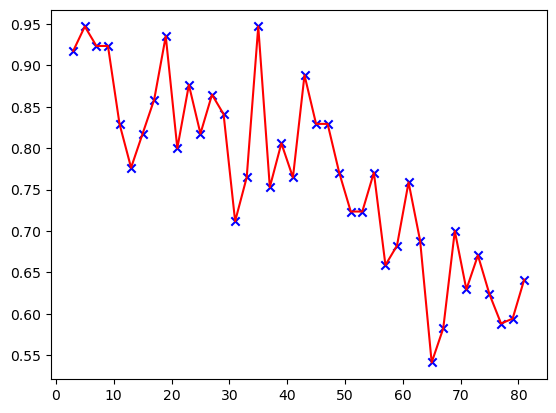

In [100]:
x = [perp_list[i] for i in range(40)]
plt.plot(x,acc_list,color='red')
plt.scatter(x,acc_list,marker = 'x',color = 'blue')
plt.show()

In [231]:
X_train_1 = np.hstack([multi_cancer[0].copy(), multi_cancer[1].copy(), multi_cancer[2].copy()])
X_train, X_test, y_train, y_test = train_test_split(X_train_1, Y_cancer, test_size=0.2)
X_train_multi = np.split(X_train, [10127, 10127+22503], axis=1)
X_test_multi = np.split(X_test, [10127, 10127+22503], axis=1)

In [232]:
multi_cancer_PCA, eigen, mu, var = pca_var(X_train_multi, 0.6, eigen = True)
X_test_multi_std = [ (X_test_multi[i] -mu[i]) / (var[i])**0.5 for i in range(len(X_test_multi))]
X_test_multi_pca = [X_test_multi_std[i]@eigen[i].T for i in range(len(X_test_multi_std))]

In [158]:
Yout_train = tsne_without_pca(multi_cancer_PCA[0],  no_dims = 2,  perplexity = 35.0)

Computing pairwise distances...
Computing P-values for point 0 of 266...


C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.181016
Iteration 10: error is 14.082544
Iteration 20: error is 13.169674
Iteration 30: error is 14.262634
Iteration 40: error is 14.910452
Iteration 50: error is 15.414246
Iteration 60: error is 15.586560
Iteration 70: error is 15.162417
Iteration 80: error is 15.260591
Iteration 90: error is 14.871532
Iteration 100: error is 14.649655
Iteration 110: error is 2.088978
Iteration 120: error is 1.660269
Iteration 130: error is 1.452490
Iteration 140: error is 1.294453
Iteration 150: error is 1.206392
Iteration 160: error is 1.151547
Iteration 170: error is 1.123155
Iteration 180: error is 1.088551
Iteration 190: error is 1.051618
Iteration 200: error is 1.025384
Iteration 210: error is 1.006016
Iteration 220: error is 0.991574
Iteration 230: error is 0.986484
Iteration 240: error is 0.980938
Iteration 250: error is 0.974687
Iteration 260: error is 0.963430
Iteration 270: error is 0.949672
Iteration 280: error is 0.939291
Iteration 290: error is 0.929848
Iteration 3

In [159]:
#t_sne_2D
a_train, a_test, b_train, b_test = train_test_split(Yout_train, y_train, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(a_train, b_train)
y_pred = knn.predict(a_test)
accuracy = accuracy_score(b_test, y_pred)
print(f"Model Accuracy: {accuracy}")
o_1.append(accuracy)

Model Accuracy: 0.9259259259259259


In [88]:
col_o = [col_cancer[i] for i in y_train]
col_t = [col_cancer[i] for i in y_test]
label_o = [label_cancer[i] for i in y_train]

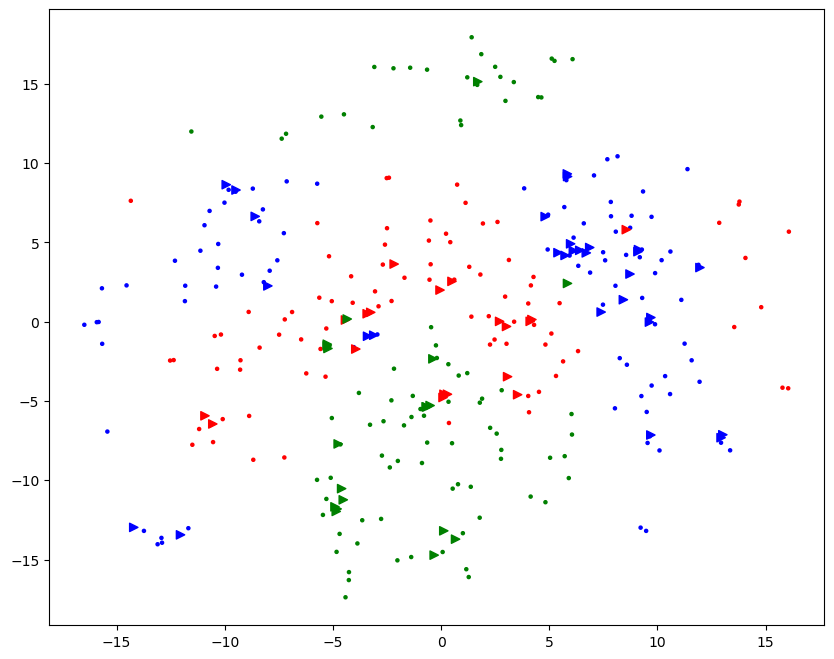

In [161]:
plt.figure(figsize=(10,8))
plt.scatter(Yout_train[:,0], Yout_train[:,1], c= col_o, marker = "o",s=5)
plt.scatter(np.array(Yout_test)[:,0], np.array(Yout_test)[:,1], c= col_t,marker = ">")
plt.show()

In [160]:
Yout_test, err, err_init = separate_multi_sne([multi_cancer_PCA[0]],Yout_train,[X_test_multi_pca[0]], perplexity =10, update =True)

computing for 0-th data point
267
267
computing for 1-th data point
268
268
computing for 2-th data point
269
269
computing for 3-th data point
270
270
computing for 4-th data point
271
271
computing for 5-th data point
272
272
computing for 6-th data point
273
273
computing for 7-th data point
274
274
computing for 8-th data point
275
275
computing for 9-th data point
276
276
computing for 10-th data point
277
277
computing for 11-th data point
278
278
computing for 12-th data point
279
279
computing for 13-th data point
280
280
computing for 14-th data point
281
281
computing for 15-th data point
282
282
computing for 16-th data point
283
283
computing for 17-th data point
284
284
computing for 18-th data point
285
285
computing for 19-th data point
286
286
computing for 20-th data point
287
287
computing for 21-th data point
288
288
computing for 22-th data point
289
289
computing for 23-th data point
290
290
computing for 24-th data point
291
291
computing for 25-th data point
292


In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(Yout_train[:,0], Yout_train[:,1], c= col_o,marker = "o",s=5)
plt.show()

In [78]:
multi_cancer_PCA[0].shape

(266, 40)

In [79]:
X_test_multi_pca[0].shape

(67, 40)

In [162]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Yout_train, y_train)
y_pred = knn.predict(np.array(Yout_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
a_1.append(accuracy)

Model Accuracy: 0.8507462686567164


In [97]:
o_1 = []
a_1 = []

In [116]:
print(np.mean(o_1))
print(np.mean(a_1))

0.9111111111111111
0.8597014925373134


In [171]:
Yout_train = multi_SNE_without_pca(multi_cancer_PCA,  no_dims = 2,  perplexity = 35.0)

m 3
baselineDim: 266
Computing pairwise distances...
Computing P-values for point 0 of 266...


C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.181016
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 47.023486
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.947077
Iteration 10: error is 14.248759
Iteration 10: error is 14.286710
Iteration 10: error is 14.236624
Iteration 20: error is 14.346695
Iteration 20: error is 14.381549
Iteration 20: error is 14.084573
Iteration 30: error is 16.228705
Iteration 30: error is 16.186382
Iteration 30: error is 15.982350
Iteration 40: error is 16.255730
Iteration 40: error is 16.242576
Iteration 40: error is 16.452179
Iteration 50: error is 16.272283
Iteration 50: error is 16.099327
Iteration 50: error is 16.324021
Iteration 60: error is 16.629721
Iteration 60: error is 16.143300
Iteration 60: error is 16.457318
Iteration 70: error is 16.134103
Iteration 70: error is 15.928152
Iteration 70: error is 16.286182
Iteration 80: error is 16.406825
Iteration 80: error is 16.271368
Ite

Iteration 820: error is 1.241272
Iteration 820: error is 1.252915
Iteration 820: error is 1.465324
Iteration 830: error is 1.241272
Iteration 830: error is 1.252915
Iteration 830: error is 1.465324
Iteration 840: error is 1.241272
Iteration 840: error is 1.252915
Iteration 840: error is 1.465324
Iteration 850: error is 1.241272
Iteration 850: error is 1.252915
Iteration 850: error is 1.465324
Iteration 860: error is 1.241272
Iteration 860: error is 1.252915
Iteration 860: error is 1.465324
Iteration 870: error is 1.241272
Iteration 870: error is 1.252915
Iteration 870: error is 1.465324
Iteration 880: error is 1.241272
Iteration 880: error is 1.252915
Iteration 880: error is 1.465324
Iteration 890: error is 1.241272
Iteration 890: error is 1.252915
Iteration 890: error is 1.465324
Iteration 900: error is 1.241272
Iteration 900: error is 1.252915
Iteration 900: error is 1.465324
Iteration 910: error is 1.241272
Iteration 910: error is 1.252915
Iteration 910: error is 1.465324
Iteration 

In [172]:
#t_sne_2D
a_train, a_test, b_train, b_test = train_test_split(Yout_train, y_train, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(a_train, b_train)
y_pred = knn.predict(a_test)
accuracy = accuracy_score(b_test, y_pred)
print(f"Model Accuracy: {accuracy}")
o_2.append(accuracy)

Model Accuracy: 0.9814814814814815


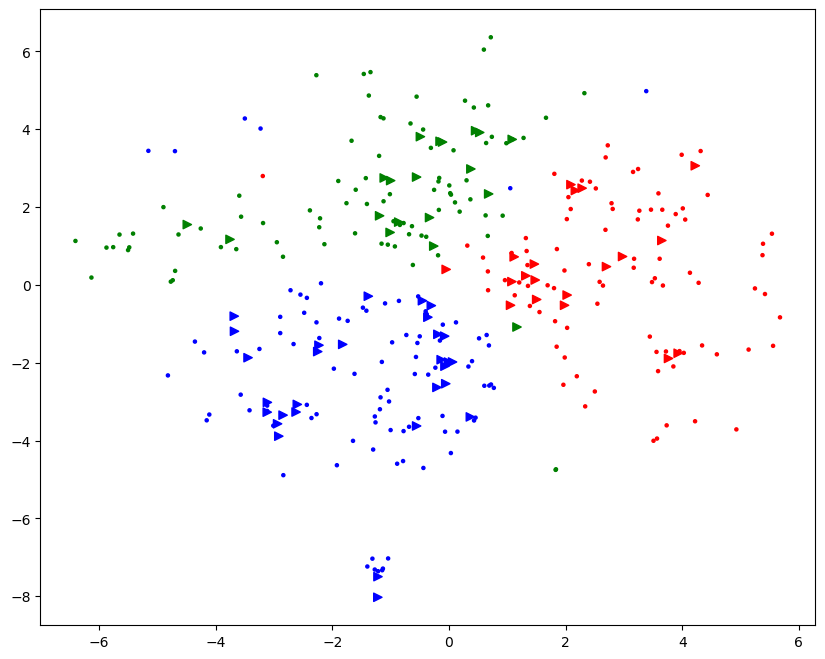

In [178]:
plt.figure(figsize=(10,8))
plt.scatter(Yout_train[:,0], Yout_train[:,1], c= col_o, marker = "o",s=5)
plt.scatter(np.array(Yout_test)[:,0], np.array(Yout_test)[:,1], c= col_t,marker = ">")
plt.show()

In [181]:
for i in range(len(multi_cancer_PCA)):
    
    multi_cancer_PCA[i] = multi_cancer_PCA[i][0:266]
    
Yout_train = Yout_train[0:266]

In [182]:
Yout_test, err, err_init = separate_multi_sne(multi_cancer_PCA,Yout_train,X_test_multi_pca, perplexity =10)

computing for 0-th data point
computing for 1-th data point
computing for 2-th data point
computing for 3-th data point
computing for 4-th data point
computing for 5-th data point
computing for 6-th data point
computing for 7-th data point
computing for 8-th data point
computing for 9-th data point
computing for 10-th data point
computing for 11-th data point
computing for 12-th data point
computing for 13-th data point
computing for 14-th data point
computing for 15-th data point
computing for 16-th data point
computing for 17-th data point
computing for 18-th data point
computing for 19-th data point
computing for 20-th data point
computing for 21-th data point
computing for 22-th data point
computing for 23-th data point
computing for 24-th data point
computing for 25-th data point
computing for 26-th data point
computing for 27-th data point
computing for 28-th data point
computing for 29-th data point
computing for 30-th data point
computing for 31-th data point
computing for 32-t

In [183]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Yout_train, y_train)
y_pred = knn.predict(np.array(Yout_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
a_2.append(accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [265, 266]

In [139]:
o_2 = []
a_2 = []

In [142]:
for i in range(4):
    Yout_train = multi_SNE_without_pca(multi_cancer_PCA,  no_dims = 2,  perplexity = 35.0)
    a_train, a_test, b_train, b_test = train_test_split(Yout_train, y_train, test_size=0.2)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    o_2.append(accuracy)
    Yout_test, err, err_init = separate_multi_sne(multi_cancer_PCA,Yout_train,X_test_multi_pca, perplexity =10)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(Yout_train, y_train)
    y_pred = knn.predict(np.array(Yout_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    a_2.append(accuracy)

m 3
baselineDim: 266
Computing pairwise distances...
Computing P-values for point 0 of 266...


C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.181016
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 47.023486
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.947077
Iteration 10: error is 14.300285
Iteration 10: error is 14.696885
Iteration 10: error is 14.302142
Iteration 20: error is 14.185327
Iteration 20: error is 14.370497
Iteration 20: error is 14.058673
Iteration 30: error is 16.157574
Iteration 30: error is 15.992712
Iteration 30: error is 15.974539
Iteration 40: error is 15.589755
Iteration 40: error is 15.338730
Iteration 40: error is 15.030451
Iteration 50: error is 15.787241
Iteration 50: error is 15.557892
Iteration 50: error is 15.392963
Iteration 60: error is 16.121576
Iteration 60: error is 15.723825
Iteration 60: error is 15.398721
Iteration 70: error is 15.899054
Iteration 70: error is 15.496811
Iteration 70: error is 15.199525
Iteration 80: error is 15.958280
Iteration 80: error is 15.699721
Ite

Iteration 820: error is 1.261842
Iteration 820: error is 1.279395
Iteration 820: error is 1.440387
Iteration 830: error is 1.261842
Iteration 830: error is 1.279395
Iteration 830: error is 1.440387
Iteration 840: error is 1.261842
Iteration 840: error is 1.279395
Iteration 840: error is 1.440387
Iteration 850: error is 1.261842
Iteration 850: error is 1.279395
Iteration 850: error is 1.440387
Iteration 860: error is 1.261842
Iteration 860: error is 1.279395
Iteration 860: error is 1.440387
Iteration 870: error is 1.261842
Iteration 870: error is 1.279395
Iteration 870: error is 1.440387
Iteration 880: error is 1.261842
Iteration 880: error is 1.279395
Iteration 880: error is 1.440387
Iteration 890: error is 1.261842
Iteration 890: error is 1.279395
Iteration 890: error is 1.440387
Iteration 900: error is 1.261842
Iteration 900: error is 1.279395
Iteration 900: error is 1.440387
Iteration 910: error is 1.261842
Iteration 910: error is 1.279395
Iteration 910: error is 1.440387
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.181016
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 47.023486
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.947077
Iteration 10: error is 14.622766
Iteration 10: error is 14.406014
Iteration 10: error is 14.182768
Iteration 20: error is 14.290354
Iteration 20: error is 14.552769
Iteration 20: error is 14.390936
Iteration 30: error is 16.223055
Iteration 30: error is 15.946098
Iteration 30: error is 16.029579
Iteration 40: error is 15.966319
Iteration 40: error is 15.502056
Iteration 40: error is 15.695233
Iteration 50: error is 15.817783
Iteration 50: error is 15.550252
Iteration 50: error is 15.864529
Iteration 60: error is 16.325832
Iteration 60: error is 15.559212
Iteration 60: error is 16.001093
Iteration 70: error is 16.220310
Iteration 70: error is 15.592820
Iteration 70: error is 15.738827
Iteration 80: error is 15.769535
Iteration 80: error is 15.297893
Ite

Iteration 820: error is 1.290177
Iteration 820: error is 1.283992
Iteration 820: error is 1.400694
Iteration 830: error is 1.290177
Iteration 830: error is 1.283992
Iteration 830: error is 1.400694
Iteration 840: error is 1.290177
Iteration 840: error is 1.283992
Iteration 840: error is 1.400694
Iteration 850: error is 1.290177
Iteration 850: error is 1.283992
Iteration 850: error is 1.400694
Iteration 860: error is 1.290177
Iteration 860: error is 1.283992
Iteration 860: error is 1.400694
Iteration 870: error is 1.290177
Iteration 870: error is 1.283992
Iteration 870: error is 1.400694
Iteration 880: error is 1.290177
Iteration 880: error is 1.283992
Iteration 880: error is 1.400694
Iteration 890: error is 1.290177
Iteration 890: error is 1.283992
Iteration 890: error is 1.400694
Iteration 900: error is 1.290177
Iteration 900: error is 1.283992
Iteration 900: error is 1.400694
Iteration 910: error is 1.290177
Iteration 910: error is 1.283992
Iteration 910: error is 1.400694
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.181016
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 47.023486
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.947077
Iteration 10: error is 14.230589
Iteration 10: error is 14.334797
Iteration 10: error is 14.175968
Iteration 20: error is 14.512881
Iteration 20: error is 14.519364
Iteration 20: error is 14.431765
Iteration 30: error is 16.276307
Iteration 30: error is 16.269835
Iteration 30: error is 16.275445
Iteration 40: error is 16.378255
Iteration 40: error is 16.072827
Iteration 40: error is 15.981047
Iteration 50: error is 16.203198
Iteration 50: error is 15.981273
Iteration 50: error is 15.988436
Iteration 60: error is 16.299200
Iteration 60: error is 16.048561
Iteration 60: error is 15.877112
Iteration 70: error is 16.438392
Iteration 70: error is 15.993990
Iteration 70: error is 15.761874
Iteration 80: error is 16.232147
Iteration 80: error is 15.877390
Ite

Iteration 820: error is 1.294659
Iteration 820: error is 1.258453
Iteration 820: error is 1.415499
Iteration 830: error is 1.294659
Iteration 830: error is 1.258453
Iteration 830: error is 1.415499
Iteration 840: error is 1.294659
Iteration 840: error is 1.258453
Iteration 840: error is 1.415499
Iteration 850: error is 1.294659
Iteration 850: error is 1.258453
Iteration 850: error is 1.415499
Iteration 860: error is 1.294659
Iteration 860: error is 1.258453
Iteration 860: error is 1.415499
Iteration 870: error is 1.294659
Iteration 870: error is 1.258453
Iteration 870: error is 1.415499
Iteration 880: error is 1.294659
Iteration 880: error is 1.258453
Iteration 880: error is 1.415499
Iteration 890: error is 1.294659
Iteration 890: error is 1.258453
Iteration 890: error is 1.415499
Iteration 900: error is 1.294659
Iteration 900: error is 1.258453
Iteration 900: error is 1.415499
Iteration 910: error is 1.294659
Iteration 910: error is 1.258453
Iteration 910: error is 1.415499
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.181016
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 47.023486
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.947077
Iteration 10: error is 14.592040
Iteration 10: error is 14.595012
Iteration 10: error is 14.329507
Iteration 20: error is 14.886553
Iteration 20: error is 14.711084
Iteration 20: error is 14.400149
Iteration 30: error is 16.074948
Iteration 30: error is 15.719787
Iteration 30: error is 15.591412
Iteration 40: error is 16.496411
Iteration 40: error is 16.121299
Iteration 40: error is 16.215332
Iteration 50: error is 17.183650
Iteration 50: error is 16.610783
Iteration 50: error is 16.612169
Iteration 60: error is 16.866492
Iteration 60: error is 16.276861
Iteration 60: error is 16.168206
Iteration 70: error is 16.846916
Iteration 70: error is 16.155977
Iteration 70: error is 16.050158
Iteration 80: error is 16.160063
Iteration 80: error is 15.835940
Ite

Iteration 820: error is 1.253907
Iteration 820: error is 1.304635
Iteration 820: error is 1.425755
Iteration 830: error is 1.253907
Iteration 830: error is 1.304635
Iteration 830: error is 1.425755
Iteration 840: error is 1.253907
Iteration 840: error is 1.304635
Iteration 840: error is 1.425755
Iteration 850: error is 1.253907
Iteration 850: error is 1.304635
Iteration 850: error is 1.425755
Iteration 860: error is 1.253907
Iteration 860: error is 1.304635
Iteration 860: error is 1.425755
Iteration 870: error is 1.253907
Iteration 870: error is 1.304635
Iteration 870: error is 1.425755
Iteration 880: error is 1.253907
Iteration 880: error is 1.304635
Iteration 880: error is 1.425755
Iteration 890: error is 1.253907
Iteration 890: error is 1.304635
Iteration 890: error is 1.425755
Iteration 900: error is 1.253907
Iteration 900: error is 1.304635
Iteration 900: error is 1.425755
Iteration 910: error is 1.253907
Iteration 910: error is 1.304635
Iteration 910: error is 1.425755
Iteration 

In [143]:
print(np.mean(o_2))
print(np.mean(a_2))

0.9592592592592591
0.9582089552238806


In [146]:
print(Yout_train)
type(Yout_train)

[[ 1.50710008e+00  2.15731219e+00]
 [-2.47048385e+00  3.01536332e+00]
 [ 2.63640157e+00 -2.22107132e+00]
 [-9.65214489e-01 -2.02004841e+00]
 [ 2.55659413e+00  2.55875346e+00]
 [-6.97607907e-01  1.05027962e+00]
 [ 2.86418404e+00  3.45014653e+00]
 [ 3.24988486e+00  3.35608749e+00]
 [ 3.41601771e+00 -3.95636382e+00]
 [-6.94506042e-01 -1.62486130e+00]
 [-1.35130742e+00 -2.10463513e+00]
 [ 4.30563718e+00  3.60221282e+00]
 [ 1.77166796e+00  3.10793388e+00]
 [ 1.15474674e+00 -4.38216233e-01]
 [-3.56472788e+00 -6.60938120e-01]
 [-6.40357020e+00 -1.94510773e+00]
 [ 2.50794610e+00  3.42769561e+00]
 [-1.47159362e+00  1.36033286e+00]
 [ 4.33661515e+00  3.31429489e+00]
 [ 4.31873298e+00  1.80894847e+00]
 [ 3.77170525e+00 -2.86573190e+00]
 [ 1.68894067e+00 -3.67813268e+00]
 [ 8.98279559e-01  2.18694425e+00]
 [ 1.92019363e+00 -2.90433953e+00]
 [ 3.29000989e+00 -1.42628884e+00]
 [ 2.98577021e-01 -3.15621616e+00]
 [ 2.93811445e+00 -2.28848950e+00]
 [-5.85536374e-01 -2.06318376e+00]
 [-8.96914054e-01 -1

numpy.ndarray

In [237]:
for i in range(5):
    Yout_train = tsne_without_pca(multi_cancer_PCA[0],  no_dims = 2,  perplexity = 35.0)
    a_train, a_test, b_train, b_test = train_test_split(Yout_train, y_train, test_size=0.2)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    o_3.append(accuracy)
    Yout_test, err, err_init = separate_multi_sne([multi_cancer_PCA[0]].copy(),Yout_train.copy(),[X_test_multi_pca[0]], perplexity =10, update =True)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(Yout_train, y_train)
    y_pred = knn.predict(np.array(Yout_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    a_3.append(accuracy)

Computing pairwise distances...
Computing P-values for point 0 of 266...


C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 13.748656
Iteration 20: error is 13.245740
Iteration 30: error is 13.653081
Iteration 40: error is 13.806100
Iteration 50: error is 14.190523
Iteration 60: error is 14.481388
Iteration 70: error is 15.166551
Iteration 80: error is 14.334231
Iteration 90: error is 13.878364
Iteration 100: error is 14.274891
Iteration 110: error is 1.948934
Iteration 120: error is 1.505173
Iteration 130: error is 1.279103
Iteration 140: error is 1.126032
Iteration 150: error is 1.022477
Iteration 160: error is 0.986539
Iteration 170: error is 0.969925
Iteration 180: error is 0.960708
Iteration 190: error is 0.954233
Iteration 200: error is 0.949775
Iteration 210: error is 0.947461
Iteration 220: error is 0.939376
Iteration 230: error is 0.930253
Iteration 240: error is 0.923983
Iteration 250: error is 0.920699
Iteration 260: error is 0.918316
Iteration 270: error is 0.915990
Iteration 280: error is 0.913029
Iteration 290: error is 0.910151
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 13.904683
Iteration 20: error is 13.573741
Iteration 30: error is 14.565396
Iteration 40: error is 14.027527
Iteration 50: error is 15.238125
Iteration 60: error is 14.953143
Iteration 70: error is 15.625853
Iteration 80: error is 15.735115
Iteration 90: error is 15.375332
Iteration 100: error is 15.455914
Iteration 110: error is 2.033575
Iteration 120: error is 1.560520
Iteration 130: error is 1.366075
Iteration 140: error is 1.211495
Iteration 150: error is 1.121352
Iteration 160: error is 1.049147
Iteration 170: error is 1.015618
Iteration 180: error is 0.985797
Iteration 190: error is 0.921198
Iteration 200: error is 0.912874
Iteration 210: error is 0.899676
Iteration 220: error is 0.887886
Iteration 230: error is 0.880142
Iteration 240: error is 0.874247
Iteration 250: error is 0.869984
Iteration 260: error is 0.867319
Iteration 270: error is 0.865327
Iteration 280: error is 0.863325
Iteration 290: error is 0.861504
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 14.057039
Iteration 20: error is 13.561285
Iteration 30: error is 14.194142
Iteration 40: error is 15.131780
Iteration 50: error is 15.217693
Iteration 60: error is 15.036776
Iteration 70: error is 15.412937
Iteration 80: error is 14.922298
Iteration 90: error is 15.835155
Iteration 100: error is 15.633897
Iteration 110: error is 1.915029
Iteration 120: error is 1.448300
Iteration 130: error is 1.201232
Iteration 140: error is 1.070417
Iteration 150: error is 0.990749
Iteration 160: error is 0.956452
Iteration 170: error is 0.941187
Iteration 180: error is 0.934829
Iteration 190: error is 0.930914
Iteration 200: error is 0.928066
Iteration 210: error is 0.925153
Iteration 220: error is 0.923497
Iteration 230: error is 0.922093
Iteration 240: error is 0.920154
Iteration 250: error is 0.910657
Iteration 260: error is 0.908337
Iteration 270: error is 0.903900
Iteration 280: error is 0.901840
Iteration 290: error is 0.899366
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 13.852353
Iteration 20: error is 13.253826
Iteration 30: error is 13.580428
Iteration 40: error is 14.113050
Iteration 50: error is 14.717161
Iteration 60: error is 14.637727
Iteration 70: error is 15.313964
Iteration 80: error is 15.213597
Iteration 90: error is 15.541024
Iteration 100: error is 15.361842
Iteration 110: error is 1.974569
Iteration 120: error is 1.452031
Iteration 130: error is 1.226122
Iteration 140: error is 1.116479
Iteration 150: error is 1.071914
Iteration 160: error is 1.021111
Iteration 170: error is 0.969564
Iteration 180: error is 0.939965
Iteration 190: error is 0.919891
Iteration 200: error is 0.901142
Iteration 210: error is 0.884109
Iteration 220: error is 0.865886
Iteration 230: error is 0.857776
Iteration 240: error is 0.852630
Iteration 250: error is 0.849176
Iteration 260: error is 0.847129
Iteration 270: error is 0.846043
Iteration 280: error is 0.845217
Iteration 290: error is 0.842099
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 14.027571
Iteration 20: error is 13.399813
Iteration 30: error is 14.066661
Iteration 40: error is 14.279800
Iteration 50: error is 14.587848
Iteration 60: error is 14.960417
Iteration 70: error is 14.651622
Iteration 80: error is 14.916598
Iteration 90: error is 15.221053
Iteration 100: error is 14.853007
Iteration 110: error is 1.780213
Iteration 120: error is 1.282693
Iteration 130: error is 1.046689
Iteration 140: error is 0.953745
Iteration 150: error is 0.909252
Iteration 160: error is 0.877344
Iteration 170: error is 0.859961
Iteration 180: error is 0.850753
Iteration 190: error is 0.845952
Iteration 200: error is 0.842328
Iteration 210: error is 0.838774
Iteration 220: error is 0.836249
Iteration 230: error is 0.834902
Iteration 240: error is 0.833964
Iteration 250: error is 0.833200
Iteration 260: error is 0.832119
Iteration 270: error is 0.830016
Iteration 280: error is 0.828646
Iteration 290: error is 0.826489
Iteration 3

In [236]:
o_3 = []
a_3 = []

In [238]:
print(np.mean(o_3))
print(np.mean(a_3))

0.9222222222222222
0.8238805970149254


In [234]:
for i in range(5):
    Yout_train = tsne_without_pca(multi_cancer_PCA[0],  no_dims = 2,  perplexity = 35.0)
    a_train, a_test, b_train, b_test = train_test_split(Yout_train, y_train, test_size=0.2)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    o_1.append(accuracy)
    Yout_test, err, err_init = separate_multi_sne([multi_cancer_PCA[0]],Yout_train,[X_test_multi_pca[0]], perplexity =10)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(Yout_train, y_train)
    y_pred = knn.predict(np.array(Yout_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    a_1.append(accuracy)

Computing pairwise distances...
Computing P-values for point 0 of 266...


C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 13.605070
Iteration 20: error is 13.714291
Iteration 30: error is 14.340568
Iteration 40: error is 14.451247
Iteration 50: error is 14.590260
Iteration 60: error is 15.077858
Iteration 70: error is 14.751245
Iteration 80: error is 14.444357
Iteration 90: error is 15.598563
Iteration 100: error is 15.324598
Iteration 110: error is 2.057082
Iteration 120: error is 1.608508
Iteration 130: error is 1.413587
Iteration 140: error is 1.222423
Iteration 150: error is 1.147538
Iteration 160: error is 1.093831
Iteration 170: error is 1.051161
Iteration 180: error is 1.009496
Iteration 190: error is 0.992495
Iteration 200: error is 0.983461
Iteration 210: error is 0.974231
Iteration 220: error is 0.967189
Iteration 230: error is 0.956961
Iteration 240: error is 0.935692
Iteration 250: error is 0.923701
Iteration 260: error is 0.918020
Iteration 270: error is 0.913077
Iteration 280: error is 0.901228
Iteration 290: error is 0.895490
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 14.595712
Iteration 20: error is 13.968005
Iteration 30: error is 14.494879
Iteration 40: error is 14.604980
Iteration 50: error is 15.123277
Iteration 60: error is 14.959393
Iteration 70: error is 14.562515
Iteration 80: error is 14.949694
Iteration 90: error is 14.304979
Iteration 100: error is 14.337432
Iteration 110: error is 1.931622
Iteration 120: error is 1.485794
Iteration 130: error is 1.264909
Iteration 140: error is 1.114805
Iteration 150: error is 1.033798
Iteration 160: error is 0.972742
Iteration 170: error is 0.940953
Iteration 180: error is 0.919863
Iteration 190: error is 0.902701
Iteration 200: error is 0.895433
Iteration 210: error is 0.891767
Iteration 220: error is 0.889429
Iteration 230: error is 0.888330
Iteration 240: error is 0.886629
Iteration 250: error is 0.878180
Iteration 260: error is 0.857740
Iteration 270: error is 0.845208
Iteration 280: error is 0.837459
Iteration 290: error is 0.834125
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 14.468511
Iteration 20: error is 13.437918
Iteration 30: error is 13.817410
Iteration 40: error is 14.732021
Iteration 50: error is 14.621781
Iteration 60: error is 14.916211
Iteration 70: error is 14.719789
Iteration 80: error is 15.172767
Iteration 90: error is 15.029315
Iteration 100: error is 15.411454
Iteration 110: error is 1.991472
Iteration 120: error is 1.474216
Iteration 130: error is 1.262906
Iteration 140: error is 1.147164
Iteration 150: error is 1.064742
Iteration 160: error is 0.999857
Iteration 170: error is 0.955682
Iteration 180: error is 0.928681
Iteration 190: error is 0.917323
Iteration 200: error is 0.912216
Iteration 210: error is 0.904996
Iteration 220: error is 0.896834
Iteration 230: error is 0.892715
Iteration 240: error is 0.886364
Iteration 250: error is 0.882216
Iteration 260: error is 0.879350
Iteration 270: error is 0.877631
Iteration 280: error is 0.876318
Iteration 290: error is 0.873779
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 14.097322
Iteration 20: error is 13.399330
Iteration 30: error is 14.355939
Iteration 40: error is 14.827839
Iteration 50: error is 14.905863
Iteration 60: error is 15.268322
Iteration 70: error is 15.964048
Iteration 80: error is 15.694671
Iteration 90: error is 15.913901
Iteration 100: error is 15.489407
Iteration 110: error is 1.980166
Iteration 120: error is 1.531091
Iteration 130: error is 1.364875
Iteration 140: error is 1.224111
Iteration 150: error is 1.142587
Iteration 160: error is 1.087352
Iteration 170: error is 1.014215
Iteration 180: error is 0.954043
Iteration 190: error is 0.921181
Iteration 200: error is 0.896679
Iteration 210: error is 0.886963
Iteration 220: error is 0.877207
Iteration 230: error is 0.865241
Iteration 240: error is 0.857764
Iteration 250: error is 0.851489
Iteration 260: error is 0.845691
Iteration 270: error is 0.842426
Iteration 280: error is 0.838576
Iteration 290: error is 0.837023
Iteration 3

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Iteration 10: error is 14.258820
Iteration 20: error is 13.533427
Iteration 30: error is 14.400140
Iteration 40: error is 14.581277
Iteration 50: error is 15.304339
Iteration 60: error is 15.097740
Iteration 70: error is 15.070951
Iteration 80: error is 15.362120
Iteration 90: error is 14.731510
Iteration 100: error is 15.377113
Iteration 110: error is 1.879504
Iteration 120: error is 1.381133
Iteration 130: error is 1.189835
Iteration 140: error is 1.053389
Iteration 150: error is 0.990858
Iteration 160: error is 0.949449
Iteration 170: error is 0.933775
Iteration 180: error is 0.922894
Iteration 190: error is 0.911354
Iteration 200: error is 0.894092
Iteration 210: error is 0.886405
Iteration 220: error is 0.882379
Iteration 230: error is 0.874626
Iteration 240: error is 0.863213
Iteration 250: error is 0.859034
Iteration 260: error is 0.856079
Iteration 270: error is 0.854185
Iteration 280: error is 0.851467
Iteration 290: error is 0.850236
Iteration 3

In [233]:
o_1 = []
a_1 = []

In [235]:
print(np.mean(o_1))
print(np.mean(a_1))

0.9407407407407407
0.8477611940298507


In [239]:
o_4 = []
a_4 = []

In [240]:
for i in range(5):
    Yout_train = multi_SNE_without_pca(multi_cancer_PCA,  no_dims = 2,  perplexity = 35.0)
    print(Yout_train.shape)
    a_train, a_test, b_train, b_test = train_test_split(Yout_train, y_train, test_size=0.2)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(a_train, b_train)
    y_pred = knn.predict(a_test)
    accuracy = accuracy_score(b_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    o_4.append(accuracy)
    Yout_test, err, err_init = separate_multi_sne(multi_cancer_PCA.copy(),Yout_train.copy(),X_test_multi_pca, perplexity =10, update =True)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(Yout_train, y_train)
    y_pred = knn.predict(np.array(Yout_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    a_4.append(accuracy)

m 3
baselineDim: 266
Computing pairwise distances...
Computing P-values for point 0 of 266...


C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 46.915950
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.919459
Iteration 10: error is 15.096777
Iteration 10: error is 14.973088
Iteration 10: error is 14.808897
Iteration 20: error is 15.787825
Iteration 20: error is 15.387634
Iteration 20: error is 15.150330
Iteration 30: error is 16.879692
Iteration 30: error is 16.711944
Iteration 30: error is 16.322172
Iteration 40: error is 17.215933
Iteration 40: error is 16.639676
Iteration 40: error is 16.292430
Iteration 50: error is 16.266940
Iteration 50: error is 16.238769
Iteration 50: error is 16.063103
Iteration 60: error is 16.250339
Iteration 60: error is 16.251055
Iteration 60: error is 16.361888
Iteration 70: error is 16.204447
Iteration 70: error is 16.127933
Iteration 70: error is 15.888550
Iteration 80: error is 16.675303
Iteration 80: error is 16.544319
Ite

Iteration 820: error is 1.256332
Iteration 820: error is 1.261367
Iteration 820: error is 1.377290
Iteration 830: error is 1.256332
Iteration 830: error is 1.261367
Iteration 830: error is 1.377290
Iteration 840: error is 1.256332
Iteration 840: error is 1.261367
Iteration 840: error is 1.377290
Iteration 850: error is 1.256332
Iteration 850: error is 1.261367
Iteration 850: error is 1.377290
Iteration 860: error is 1.256332
Iteration 860: error is 1.261367
Iteration 860: error is 1.377290
Iteration 870: error is 1.256332
Iteration 870: error is 1.261367
Iteration 870: error is 1.377290
Iteration 880: error is 1.256332
Iteration 880: error is 1.261367
Iteration 880: error is 1.377290
Iteration 890: error is 1.256332
Iteration 890: error is 1.261367
Iteration 890: error is 1.377290
Iteration 900: error is 1.256332
Iteration 900: error is 1.261367
Iteration 900: error is 1.377290
Iteration 910: error is 1.256332
Iteration 910: error is 1.261367
Iteration 910: error is 1.377290
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 46.915950
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.919459
Iteration 10: error is 14.403391
Iteration 10: error is 14.368163
Iteration 10: error is 14.037484
Iteration 20: error is 15.213004
Iteration 20: error is 14.936829
Iteration 20: error is 14.608274
Iteration 30: error is 15.601261
Iteration 30: error is 15.655396
Iteration 30: error is 15.165438
Iteration 40: error is 16.343645
Iteration 40: error is 16.351287
Iteration 40: error is 16.062515
Iteration 50: error is 16.359993
Iteration 50: error is 16.254368
Iteration 50: error is 15.975798
Iteration 60: error is 17.168682
Iteration 60: error is 16.623348
Iteration 60: error is 16.659275
Iteration 70: error is 15.955818
Iteration 70: error is 15.736124
Iteration 70: error is 15.500094
Iteration 80: error is 16.900673
Iteration 80: error is 16.569755
Ite

Iteration 820: error is 1.245653
Iteration 820: error is 1.310119
Iteration 820: error is 1.419661
Iteration 830: error is 1.245653
Iteration 830: error is 1.310119
Iteration 830: error is 1.419661
Iteration 840: error is 1.245653
Iteration 840: error is 1.310119
Iteration 840: error is 1.419661
Iteration 850: error is 1.245653
Iteration 850: error is 1.310119
Iteration 850: error is 1.419661
Iteration 860: error is 1.245653
Iteration 860: error is 1.310119
Iteration 860: error is 1.419661
Iteration 870: error is 1.245653
Iteration 870: error is 1.310119
Iteration 870: error is 1.419661
Iteration 880: error is 1.245653
Iteration 880: error is 1.310119
Iteration 880: error is 1.419661
Iteration 890: error is 1.245653
Iteration 890: error is 1.310119
Iteration 890: error is 1.419661
Iteration 900: error is 1.245653
Iteration 900: error is 1.310119
Iteration 900: error is 1.419661
Iteration 910: error is 1.245653
Iteration 910: error is 1.310119
Iteration 910: error is 1.419661
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 46.915950
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.919459
Iteration 10: error is 14.416597
Iteration 10: error is 14.257256
Iteration 10: error is 14.086874
Iteration 20: error is 14.394582
Iteration 20: error is 14.294865
Iteration 20: error is 14.323093
Iteration 30: error is 16.382409
Iteration 30: error is 16.230305
Iteration 30: error is 16.077818
Iteration 40: error is 16.244198
Iteration 40: error is 15.786626
Iteration 40: error is 15.632663
Iteration 50: error is 16.833576
Iteration 50: error is 16.087711
Iteration 50: error is 16.065993
Iteration 60: error is 16.844553
Iteration 60: error is 16.393120
Iteration 60: error is 16.278253
Iteration 70: error is 16.659951
Iteration 70: error is 16.650760
Iteration 70: error is 16.260760
Iteration 80: error is 16.749494
Iteration 80: error is 16.668587
Ite

Iteration 820: error is 1.293051
Iteration 820: error is 1.327721
Iteration 820: error is 1.400550
Iteration 830: error is 1.293051
Iteration 830: error is 1.327721
Iteration 830: error is 1.400550
Iteration 840: error is 1.293051
Iteration 840: error is 1.327721
Iteration 840: error is 1.400550
Iteration 850: error is 1.293051
Iteration 850: error is 1.327721
Iteration 850: error is 1.400550
Iteration 860: error is 1.293051
Iteration 860: error is 1.327721
Iteration 860: error is 1.400550
Iteration 870: error is 1.293051
Iteration 870: error is 1.327721
Iteration 870: error is 1.400550
Iteration 880: error is 1.293051
Iteration 880: error is 1.327721
Iteration 880: error is 1.400550
Iteration 890: error is 1.293051
Iteration 890: error is 1.327721
Iteration 890: error is 1.400550
Iteration 900: error is 1.293051
Iteration 900: error is 1.327721
Iteration 900: error is 1.400550
Iteration 910: error is 1.293051
Iteration 910: error is 1.327721
Iteration 910: error is 1.400550
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 46.915950
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.919459
Iteration 10: error is 14.424783
Iteration 10: error is 14.284900
Iteration 10: error is 14.155243
Iteration 20: error is 14.999946
Iteration 20: error is 14.639531
Iteration 20: error is 14.464398
Iteration 30: error is 17.182428
Iteration 30: error is 16.780620
Iteration 30: error is 16.617970
Iteration 40: error is 15.966500
Iteration 40: error is 15.636590
Iteration 40: error is 15.664023
Iteration 50: error is 16.469050
Iteration 50: error is 16.295840
Iteration 50: error is 16.331136
Iteration 60: error is 16.437320
Iteration 60: error is 16.134762
Iteration 60: error is 15.938483
Iteration 70: error is 16.615134
Iteration 70: error is 15.931597
Iteration 70: error is 15.912788
Iteration 80: error is 16.976200
Iteration 80: error is 16.641082
Ite

Iteration 820: error is 1.243514
Iteration 820: error is 1.269805
Iteration 820: error is 1.439063
Iteration 830: error is 1.243514
Iteration 830: error is 1.269805
Iteration 830: error is 1.439063
Iteration 840: error is 1.243514
Iteration 840: error is 1.269805
Iteration 840: error is 1.439063
Iteration 850: error is 1.243514
Iteration 850: error is 1.269805
Iteration 850: error is 1.439063
Iteration 860: error is 1.243514
Iteration 860: error is 1.269805
Iteration 860: error is 1.439063
Iteration 870: error is 1.243514
Iteration 870: error is 1.269805
Iteration 870: error is 1.439063
Iteration 880: error is 1.243514
Iteration 880: error is 1.269805
Iteration 880: error is 1.439063
Iteration 890: error is 1.243514
Iteration 890: error is 1.269805
Iteration 890: error is 1.439063
Iteration 900: error is 1.243514
Iteration 900: error is 1.269805
Iteration 900: error is 1.439063
Iteration 910: error is 1.243514
Iteration 910: error is 1.269805
Iteration 910: error is 1.439063
Iteration 

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\1760564944.py:17: RuntimeWarning: overflow encountered in divide
  P = P / sumP


Mean value of sigma: 32.169049
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 46.915950
Computing pairwise distances...
Computing P-values for point 0 of 266...
Mean value of sigma: 4.919459
Iteration 10: error is 14.274201
Iteration 10: error is 14.201041
Iteration 10: error is 14.276433
Iteration 20: error is 14.712395
Iteration 20: error is 14.799613
Iteration 20: error is 14.528088
Iteration 30: error is 16.064222
Iteration 30: error is 15.807192
Iteration 30: error is 15.817555
Iteration 40: error is 16.854308
Iteration 40: error is 16.208380
Iteration 40: error is 16.238198
Iteration 50: error is 16.892189
Iteration 50: error is 16.294089
Iteration 50: error is 16.230498
Iteration 60: error is 16.918615
Iteration 60: error is 16.611516
Iteration 60: error is 16.508701
Iteration 70: error is 16.927624
Iteration 70: error is 16.432491
Iteration 70: error is 16.375762
Iteration 80: error is 17.165427
Iteration 80: error is 16.864250
Ite

Iteration 820: error is 1.219765
Iteration 820: error is 1.248335
Iteration 820: error is 1.387499
Iteration 830: error is 1.219765
Iteration 830: error is 1.248335
Iteration 830: error is 1.387499
Iteration 840: error is 1.219765
Iteration 840: error is 1.248335
Iteration 840: error is 1.387499
Iteration 850: error is 1.219765
Iteration 850: error is 1.248335
Iteration 850: error is 1.387499
Iteration 860: error is 1.219765
Iteration 860: error is 1.248335
Iteration 860: error is 1.387499
Iteration 870: error is 1.219765
Iteration 870: error is 1.248335
Iteration 870: error is 1.387499
Iteration 880: error is 1.219765
Iteration 880: error is 1.248335
Iteration 880: error is 1.387499
Iteration 890: error is 1.219765
Iteration 890: error is 1.248335
Iteration 890: error is 1.387499
Iteration 900: error is 1.219765
Iteration 900: error is 1.248335
Iteration 900: error is 1.387499
Iteration 910: error is 1.219765
Iteration 910: error is 1.248335
Iteration 910: error is 1.387499
Iteration 

In [241]:
print(np.mean(o_4))
print(np.mean(a_4))

0.951851851851852
0.9343283582089551


In [217]:
multi_cancer_PCA[0].shape

(266, 40)

In [242]:
for i in range(6):
    print(multi_dig[i].shape)

(2000, 216)
(2000, 76)
(2000, 64)
(2000, 6)
(2000, 240)
(2000, 47)


In [246]:
216+76+64+6+240

602

In [248]:
X_train_1 = np.hstack([multi_dig[0].copy(), multi_dig[1].copy(), multi_dig[2].copy(),multi_dig[3].copy(),multi_dig[4].copy(),multi_dig[5].copy()])
X_train, X_test, y_train, y_test = train_test_split(X_train_1, Y_dig, test_size=0.2)
X_train_multi = np.split(X_train, [216, 292, 356, 362, 602], axis=1)
X_test_multi = np.split(X_test, [216, 292, 356, 362, 602], axis=1)

In [249]:
multi_cancer_PCA, eigen, mu, var = pca_var(X_train_multi, 0.8, eigen = True)
X_test_multi_std = [ (X_test_multi[i] -mu[i]) / (var[i])**0.5 for i in range(len(X_test_multi))]
X_test_multi_pca = [X_test_multi_std[i]@eigen[i].T for i in range(len(X_test_multi_std))]

In [250]:
Yout_train = multi_SNE_without_pca(multi_cancer_PCA,  no_dims = 2,  perplexity = 35.0)

m 6
baselineDim: 1600
Computing pairwise distances...
Computing P-values for point 0 of 1600...
Computing P-values for point 500 of 1600...
Computing P-values for point 1000 of 1600...
Computing P-values for point 1500 of 1600...
Mean value of sigma: 3.776395
Computing pairwise distances...
Computing P-values for point 0 of 1600...
Computing P-values for point 500 of 1600...
Computing P-values for point 1000 of 1600...
Computing P-values for point 1500 of 1600...
Mean value of sigma: 2.732466
Computing pairwise distances...
Computing P-values for point 0 of 1600...
Computing P-values for point 500 of 1600...
Computing P-values for point 1000 of 1600...
Computing P-values for point 1500 of 1600...
Mean value of sigma: 2.650203
Computing pairwise distances...
Computing P-values for point 0 of 1600...
Computing P-values for point 500 of 1600...
Computing P-values for point 1000 of 1600...
Computing P-values for point 1500 of 1600...
Mean value of sigma: 0.128163
Computing pairwise distanc

Iteration 360: error is 1.327696
Iteration 360: error is 2.464286
Iteration 360: error is 1.559219
Iteration 360: error is 2.769631
Iteration 360: error is 1.197474
Iteration 360: error is 2.186200
Iteration 370: error is 1.327050
Iteration 370: error is 2.464548
Iteration 370: error is 1.558515
Iteration 370: error is 2.770375
Iteration 370: error is 1.196925
Iteration 370: error is 2.186592
Iteration 380: error is 1.326534
Iteration 380: error is 2.464704
Iteration 380: error is 1.558055
Iteration 380: error is 2.771320
Iteration 380: error is 1.196365
Iteration 380: error is 2.186718
Iteration 390: error is 1.326035
Iteration 390: error is 2.464829
Iteration 390: error is 1.557640
Iteration 390: error is 2.772265
Iteration 390: error is 1.195783
Iteration 390: error is 2.186895
Iteration 400: error is 1.325612
Iteration 400: error is 2.464983
Iteration 400: error is 1.557289
Iteration 400: error is 2.773064
Iteration 400: error is 1.195275
Iteration 400: error is 2.187024
Iteration 

Iteration 780: error is 1.322928
Iteration 780: error is 2.465256
Iteration 780: error is 1.554476
Iteration 780: error is 2.779585
Iteration 780: error is 1.191474
Iteration 780: error is 2.188600
Iteration 790: error is 1.322922
Iteration 790: error is 2.465261
Iteration 790: error is 1.554469
Iteration 790: error is 2.779596
Iteration 790: error is 1.191465
Iteration 790: error is 2.188606
Iteration 800: error is 1.322917
Iteration 800: error is 2.465265
Iteration 800: error is 1.554462
Iteration 800: error is 2.779605
Iteration 800: error is 1.191458
Iteration 800: error is 2.188611
Iteration 810: error is 1.322913
Iteration 810: error is 2.465270
Iteration 810: error is 1.554455
Iteration 810: error is 2.779613
Iteration 810: error is 1.191451
Iteration 810: error is 2.188616
Iteration 820: error is 1.322909
Iteration 820: error is 2.465273
Iteration 820: error is 1.554450
Iteration 820: error is 2.779621
Iteration 820: error is 1.191445
Iteration 820: error is 2.188620
Iteration 

In [251]:
col = ['red','blue','green','cyan', 'm','y','k','navy','gold','salmon']
d_col_o = [col[i] for i in y_train]
d_col_t = [col[i] for i in y_test]

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\3474722722.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx = np.where(Y_dig == i)


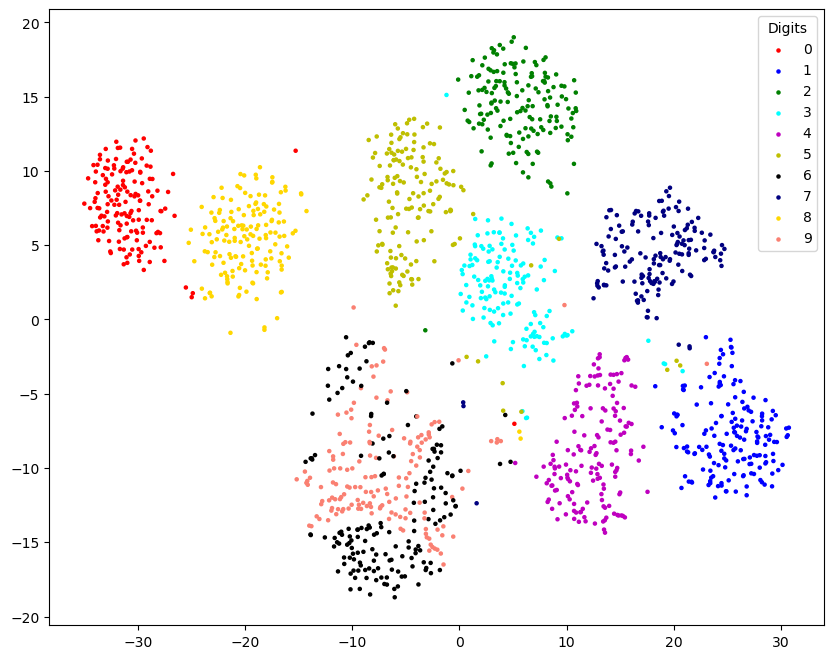

In [252]:

#a = np.array(Yout_test)
plt.figure(figsize=(10,8))
plt.scatter(Yout_train[:,0], Yout_train[:,1], c= d_col_o,marker = "o",s=5)
#plt.scatter(a[:,0], a[:,1], c= y_test,marker = ">")
for i in range(10):
    idx = np.where(Y_dig == i)
    plt.scatter(Yout_dig[idx, 0], Yout_dig[idx, 1], c=col[i], label=labels[i], s=5)

# Add legend
plt.legend(title='Digits')
plt.show()

In [253]:
a_train, a_test, b_train, b_test = train_test_split(Yout_train, y_train, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(a_train, b_train)
y_pred = knn.predict(a_test)
accuracy = accuracy_score(b_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.95625


In [256]:
Yout_test, err, err_init = separate_multi_sne(multi_cancer_PCA.copy(),Yout_train.copy(),X_test_multi_pca, perplexity =10)

computing for 0-th data point
computing for 1-th data point
computing for 2-th data point
computing for 3-th data point
computing for 4-th data point
computing for 5-th data point
computing for 6-th data point
computing for 7-th data point
computing for 8-th data point
computing for 9-th data point
computing for 10-th data point
computing for 11-th data point
computing for 12-th data point
computing for 13-th data point
computing for 14-th data point
computing for 15-th data point
computing for 16-th data point
computing for 17-th data point
computing for 18-th data point
computing for 19-th data point
computing for 20-th data point
computing for 21-th data point
computing for 22-th data point
computing for 23-th data point
computing for 24-th data point
computing for 25-th data point
computing for 26-th data point
computing for 27-th data point
computing for 28-th data point
computing for 29-th data point
computing for 30-th data point
computing for 31-th data point
computing for 32-t

computing for 260-th data point
computing for 261-th data point
computing for 262-th data point
computing for 263-th data point
computing for 264-th data point
computing for 265-th data point
computing for 266-th data point
computing for 267-th data point
computing for 268-th data point
computing for 269-th data point
computing for 270-th data point
computing for 271-th data point
computing for 272-th data point
computing for 273-th data point
computing for 274-th data point
computing for 275-th data point
computing for 276-th data point
computing for 277-th data point
computing for 278-th data point
computing for 279-th data point
computing for 280-th data point
computing for 281-th data point
computing for 282-th data point
computing for 283-th data point
computing for 284-th data point
computing for 285-th data point
computing for 286-th data point
computing for 287-th data point
computing for 288-th data point
computing for 289-th data point
computing for 290-th data point
computin

In [257]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Yout_train, y_train)
y_pred = knn.predict(np.array(Yout_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.955


In [260]:
Yout_test

[array([-31.15581758,   6.1383875 ]),
 array([  7.23680642, -11.08677008]),
 array([14.54611058,  5.91024726]),
 array([-21.05480566,   3.47778018]),
 array([ -6.67069222, -21.19326896]),
 array([-11.27347608, -15.86409211]),
 array([-23.05986342,   1.1591861 ]),
 array([14.47098481, -9.07664264]),
 array([-5.85163897,  5.68877191]),
 array([4.59652112, 3.04071212]),
 array([5.57529198, 5.63072397]),
 array([ 24.56576155, -10.87425856]),
 array([23.98938488, -9.24491834]),
 array([16.21986544,  7.18027427]),
 array([ -4.66449395, -14.65528898]),
 array([5.66317813, 3.02006421]),
 array([ 4.11713502, 18.35262825]),
 array([-5.77767858, -3.46761429]),
 array([ -7.89623887, -13.93354233]),
 array([ 7.40727   , 14.82936578]),
 array([ 6.11979093, 13.09052482]),
 array([13.43284039, -3.51044031]),
 array([ -3.1317605 , -20.43385844]),
 array([ -9.456071  , -11.94684529]),
 array([3.82381157, 0.48273997]),
 array([10.25471275, 14.76367444]),
 array([23.02018468,  4.77427971]),
 array([-19.12

C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\3602869124.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx = np.where(Y_dig == i)


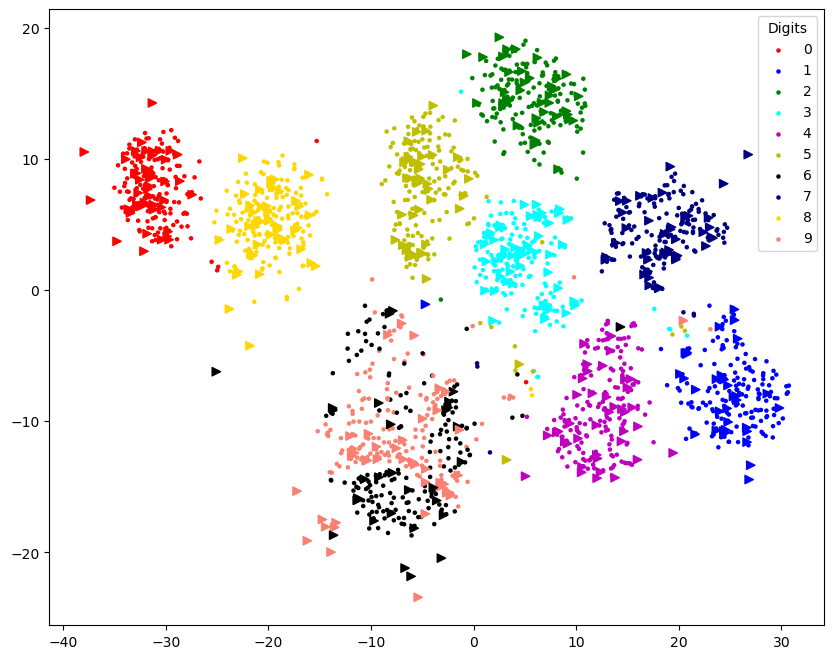

In [262]:

#a = np.array(Yout_test)
plt.figure(figsize=(10,8))
plt.scatter(Yout_train[:,0], Yout_train[:,1], c= d_col_o,marker = "o",s=5)
plt.scatter(np.array(Yout_test)[:,0], np.array(Yout_test)[:,1], c= d_col_t,marker = ">")
for i in range(10):
    idx = np.where(Y_dig == i)
    plt.scatter(Yout_dig[idx, 0], Yout_dig[idx, 1], c=col[i], label=labels[i], s=5)

# Add legend
plt.legend(title='Digits')
plt.show()

In [263]:
Yout_test, err, err_init = separate_multi_sne(multi_cancer_PCA.copy(),Yout_train.copy(),X_test_multi_pca, perplexity =10, update= True)

computing for 0-th data point
1601
1601
1600
1600
computing for 1-th data point
1602
1602
1600
1600
computing for 2-th data point
1603
1603
1600
1600
computing for 3-th data point
1604
1604
1600
1600
computing for 4-th data point
1605
1605
1600
1600
computing for 5-th data point
1606
1606
1600
1600
computing for 6-th data point
1607
1607
1600
1600
computing for 7-th data point
1608
1608
1600
1600
computing for 8-th data point
1609
1609
1600
1600
computing for 9-th data point
1610
1610
1600
1600
computing for 10-th data point
1611
1611
1600
1600
computing for 11-th data point
1612
1612
1600
1600
computing for 12-th data point
1613
1613
1600
1600
computing for 13-th data point
1614
1614
1600
1600
computing for 14-th data point
1615
1615
1600
1600
computing for 15-th data point
1616
1616
1600
1600
computing for 16-th data point
1617
1617
1600
1600
computing for 17-th data point
1618
1618
1600
1600
computing for 18-th data point
1619
1619
1600
1600
computing for 19-th data point
1620
1620


1761
1761
1600
1600
computing for 161-th data point
1762
1762
1600
1600
computing for 162-th data point
1763
1763
1600
1600
computing for 163-th data point
1764
1764
1600
1600
computing for 164-th data point
1765
1765
1600
1600
computing for 165-th data point
1766
1766
1600
1600
computing for 166-th data point
1767
1767
1600
1600
computing for 167-th data point
1768
1768
1600
1600
computing for 168-th data point
1769
1769
1600
1600
computing for 169-th data point
1770
1770
1600
1600
computing for 170-th data point
1771
1771
1600
1600
computing for 171-th data point
1772
1772
1600
1600
computing for 172-th data point
1773
1773
1600
1600
computing for 173-th data point
1774
1774
1600
1600
computing for 174-th data point
1775
1775
1600
1600
computing for 175-th data point
1776
1776
1600
1600
computing for 176-th data point
1777
1777
1600
1600
computing for 177-th data point
1778
1778
1600
1600
computing for 178-th data point
1779
1779
1600
1600
computing for 179-th data point
1780
1780
16

1919
1919
1600
1600
computing for 319-th data point
1920
1920
1600
1600
computing for 320-th data point
1921
1921
1600
1600
computing for 321-th data point
1922
1922
1600
1600
computing for 322-th data point
1923
1923
1600
1600
computing for 323-th data point
1924
1924
1600
1600
computing for 324-th data point
1925
1925
1600
1600
computing for 325-th data point
1926
1926
1600
1600
computing for 326-th data point
1927
1927
1600
1600
computing for 327-th data point
1928
1928
1600
1600
computing for 328-th data point
1929
1929
1600
1600
computing for 329-th data point
1930
1930
1600
1600
computing for 330-th data point
1931
1931
1600
1600
computing for 331-th data point
1932
1932
1600
1600
computing for 332-th data point
1933
1933
1600
1600
computing for 333-th data point
1934
1934
1600
1600
computing for 334-th data point
1935
1935
1600
1600
computing for 335-th data point
1936
1936
1600
1600
computing for 336-th data point
1937
1937
1600
1600
computing for 337-th data point
1938
1938
16

In [264]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Yout_train, y_train)
y_pred = knn.predict(np.array(Yout_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9575


C:\Users\lzl\AppData\Local\Temp\ipykernel_11716\35029611.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx = np.where(Y_dig == i)


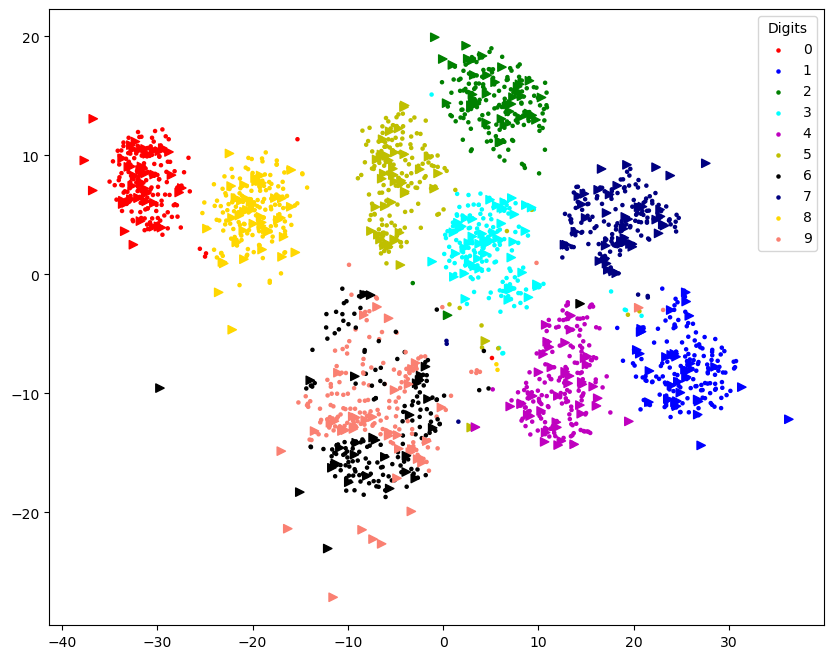

In [265]:
#a = np.array(Yout_test)
plt.figure(figsize=(10,8))
plt.scatter(Yout_train[:,0], Yout_train[:,1], c= d_col_o,marker = "o",s=5)
plt.scatter(np.array(Yout_test)[:,0], np.array(Yout_test)[:,1], c= d_col_t,marker = ">")
for i in range(10):
    idx = np.where(Y_dig == i)
    plt.scatter(Yout_dig[idx, 0], Yout_dig[idx, 1], c=col[i], label=labels[i], s=5)

# Add legend
plt.legend(title='Digits')
plt.show()